# 🏢 Prédiction du Turnover - ESN TechNova

> **Objectif :** Construire un modèle de Machine Learning capable de prédire quels employés risquent de quitter l'entreprise, afin de permettre aux RH d'identifier les causes racines du départ des employés

**Contexte métier :** TechNova est une ESN (Entreprise de Services Numériques) confrontée à un turnover important. Ce projet vise à identifier les facteurs de départ.

---

## 📑 Table des Matières

0. **Configuration & Setup**
1. **Chargement & Exploration Initiale**
2. **Analyse Exploratoire (EDA)**
3. **Preprocessing & Feature Engineering**
4. **Modélisation - Baseline & Modèles Simples**
5. **Modélisation - Optimisation**
6. **Interprétabilité & Analyse des Erreurs**
7. **Améliorations Avancées**
8. **Conclusion & Recommandations**

---
# 0. Configuration & Setup

Cette section centralise tous les imports, constantes et fonctions utilitaires réutilisables dans le notebook. Cela garantit :
- 🔒 **Reproductibilité** : un seul endroit pour gérer les dépendances
- 🧹 **Lisibilité** : le code métier n'est pas pollué par les imports
- ♻️ **Réutilisabilité** : les fonctions helper sont définies une seule fois

## 0.1 Imports Centralisés

Tous les imports nécessaires au projet sont regroupés ici pour faciliter la maintenance et éviter les imports dispersés.

In [1]:
# ============================================================
# IMPORTS - Data Manipulation & Analysis
# ============================================================
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# ============================================================
# IMPORTS - Visualization
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

# Configuration visuelle globale
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# ============================================================
# IMPORTS - Machine Learning (sklearn)
# ============================================================
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    precision_score,
    recall_score,
    roc_curve,
    RocCurveDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay,
    make_scorer
)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFECV
from scipy.stats import randint, uniform

# ============================================================
# IMPORTS - Advanced ML
# ============================================================
import xgboost as xgb
import shap

# ============================================================
# IMPORTS - Imbalanced Learning
# ============================================================
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as IMBPipeline

print("✅ Tous les imports chargés avec succès !")

✅ Tous les imports chargés avec succès !


## 0.2 Configuration Globale

Définition des constantes utilisées dans tout le notebook pour garantir la cohérence et la reproductibilité.

In [2]:
# ============================================================
# CONFIGURATION GLOBALE
# ============================================================

# Reproductibilité
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Chemins des données sources
DATA_PATH = 'source/'
SIRH_FILE = DATA_PATH + 'extrait_sirh.csv'
EVAL_FILE = DATA_PATH + 'extrait_eval.csv'
SONDAGE_FILE = DATA_PATH + 'extrait_sondage.csv'

# Variable cible
TARGET = 'a_quitte_l_entreprise'

# Ratio Train/Test
TEST_SIZE = 0.25

# Seuils d'analyse
CORRELATION_THRESHOLD = 0.90  # Pour suppression des colonnes fortement corrélées
CRAMER_V_THRESHOLD = 0.20     # Pour association catégorielle significative

print(f"🎯 Configuration chargée:")
print(f"   - Random State: {RANDOM_STATE}")
print(f"   - Target: '{TARGET}'")
print(f"   - Test Size: {TEST_SIZE*100:.0f}%")

🎯 Configuration chargée:
   - Random State: 42
   - Target: 'a_quitte_l_entreprise'
   - Test Size: 25%


## 0.3 Fonctions Utilitaires

Ces fonctions réutilisables sont définies une seule fois et appelées tout au long du notebook. Elles encapsulent la logique métier récurrente.

In [3]:
# ============================================================
# FONCTIONS UTILITAIRES - Data Loading & Cleaning
# ============================================================

def merge_and_report(sirh_df, eval_df, sondage_df, show=True):
    """
    Fusionne les 3 sources de données (SIRH, Évaluations, Sondage) et génère un rapport.

    Parameters:
    -----------
    sirh_df : DataFrame - Données SIRH
    eval_df : DataFrame - Données d'évaluation
    sondage_df : DataFrame - Données de sondage
    show : bool - Afficher le rapport de fusion

    Returns:
    --------
    tuple : (merged_df, report_dict)
    """
    eval_copy = eval_df.copy()

    # Parsing sécurisé de eval_number (format: "eval_XXX" -> XXX)
    if 'eval_number' in eval_copy.columns and eval_copy['eval_number'].dtype == object:
        eval_copy['eval_number'] = eval_copy['eval_number'].apply(
            lambda x: int(str(x).strip().split('_')[-1]) if pd.notna(x) else x
        )

    # Stockage des tailles avant fusion
    before = {'sirh': len(sirh_df), 'eval': len(eval_df), 'sondage': len(sondage_df)}

    # Double jointure interne
    merged = sirh_df.merge(eval_copy, left_on='id_employee', right_on='eval_number', how='inner')
    merged = merged.merge(sondage_df, left_on='id_employee', right_on='code_sondage', how='inner')

    # Rapport
    report = {
        'before': before,
        'after': len(merged),
        'lost_rows': before['sirh'] - len(merged),
        'retention_rate': len(merged) / before['sirh'] * 100
    }

    if show:
        print(f"📊 Rapport de fusion:")
        print(f"   - Lignes avant : SIRH={before['sirh']}, Eval={before['eval']}, Sondage={before['sondage']}")
        print(f"   - Lignes après fusion : {report['after']}")
        print(f"   - Lignes perdues : {report['lost_rows']} ({100 - report['retention_rate']:.1f}%)")

    return merged, report


def clean_basic(df, drop_cols=None):
    """
    Nettoyage de base du DataFrame : suppression de colonnes et parsing.

    Parameters:
    -----------
    df : DataFrame - Données à nettoyer
    drop_cols : list - Colonnes à supprimer

    Returns:
    --------
    DataFrame nettoyé
    """
    result = df.copy()

    if drop_cols is not None:
        result = result.drop(columns=drop_cols, errors='ignore')

    # Parsing de la colonne augmentation (format: "XX%" -> XX)
    col = 'augementation_salaire_precedente'
    if col in result.columns and result[col].dtype == object:
        result[col] = result[col].apply(
            lambda x: int(str(x).strip().split('%')[0]) if pd.notna(x) else x
        )

    return result.reset_index(drop=True)


def cramers_v(x, y):
    """
    Calcule le V de Cramér entre deux variables catégorielles.

    Le V de Cramér mesure l'association entre variables catégorielles.
    Valeurs : 0 (aucune association) à 1 (association parfaite)

    Parameters:
    -----------
    x, y : Series - Variables catégorielles à comparer

    Returns:
    --------
    float : V de Cramér
    """
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape

    # Correction pour les petits échantillons
    with np.errstate(divide='ignore', invalid='ignore'):
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


def classify_columns(df, continuous_threshold=20):
    """
    Classifie automatiquement les colonnes du DataFrame par type.

    Parameters:
    -----------
    df : DataFrame
    continuous_threshold : int - Seuil de valeurs uniques pour considérer une variable comme continue

    Returns:
    --------
    dict : {'continuous': [...], 'ordinal': [...], 'categorical': [...]}
    """
    data_types = {
        'continuous': [],      # Variables numériques continues
        'ordinal': [],         # Variables numériques ordinales (peu de valeurs)
        'categorical': []      # Variables textuelles
    }

    for col in df.columns:
        n_unique = df[col].nunique()
        dtype = df[col].dtype

        if dtype in ['int64', 'float64']:
            if n_unique > continuous_threshold:
                data_types['continuous'].append(col)
            elif n_unique > 1:
                data_types['ordinal'].append(col)
        elif dtype == 'object' and n_unique > 1:
            data_types['categorical'].append(col)

    return data_types


print("✅ Fonctions utilitaires chargées !")

✅ Fonctions utilitaires chargées !


---
# 1. Chargement & Exploration Initiale des Données

Cette section couvre le chargement des 3 sources de données RH, leur fusion et le nettoyage préliminaire nécessaire avant l'analyse exploratoire.

## 1.1 Chargement des Sources de Données

Nous disposons de **3 fichiers CSV** complémentaires :

| Fichier | Description | Clé de jointure |
|---------|-------------|-----------------|
| `extrait_sirh.csv` | Données RH (âge, salaire, ancienneté, département...) | `id_employee` |
| `extrait_eval.csv` | Évaluations de performance | `eval_number` |
| `extrait_sondage.csv` | Résultats du sondage de satisfaction | `code_sondage` |

In [4]:
# Chargement des 3 sources
sirh = pd.read_csv(SIRH_FILE)
eval_data = pd.read_csv(EVAL_FILE)
sondage = pd.read_csv(SONDAGE_FILE)

print(f"📂 Fichiers chargés avec succès !")
print(f"   - SIRH     : {sirh.shape[0]:,} lignes × {sirh.shape[1]} colonnes")
print(f"   - Eval     : {eval_data.shape[0]:,} lignes × {eval_data.shape[1]} colonnes")
print(f"   - Sondage  : {sondage.shape[0]:,} lignes × {sondage.shape[1]} colonnes")

📂 Fichiers chargés avec succès !
   - SIRH     : 1,470 lignes × 12 colonnes
   - Eval     : 1,470 lignes × 10 colonnes
   - Sondage  : 1,470 lignes × 12 colonnes


## 1.2 Aperçu Rapide des Données Sources

Avant toute fusion, examinons rapidement la structure et le contenu de chaque fichier.

In [5]:
# Fonction d'affichage condensé pour chaque source
def display_source_overview(df, name):
    """Affiche un résumé condensé d'un DataFrame source."""
    print(f"\n{'='*60}")
    print(f"📋 {name.upper()}")
    print(f"{'='*60}")

    # Types de données
    print(f"\n🔢 Types de données :")
    print(df.dtypes.value_counts().to_string())

    # Valeurs manquantes
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"\n⚠️ Valeurs manquantes :")
        print(missing[missing > 0].to_string())
    else:
        print(f"\n✅ Aucune valeur manquante")

    # Aperçu
    print(f"\n📊 Aperçu (3 premières lignes) :")
    display(df.head(3))

# Affichage pour chaque source
for df, name in [(sirh, "SIRH"), (eval_data, "Évaluations"), (sondage, "Sondage")]:
    display_source_overview(df, name)


📋 SIRH

🔢 Types de données :
int64     8
object    4

✅ Aucune valeur manquante

📊 Aperçu (3 premières lignes) :


id_employee  age genre  revenu_mensuel statut_marital departement  \
0            1   41     F            5993    Célibataire  Commercial   
1            2   49     M            5130       Marié(e)  Consulting   
2            4   37     M            2090    Célibataire  Consulting   

                    poste  nombre_experiences_precedentes  \
0        Cadre Commercial                               8   
1  Assistant de Direction                               1   
2              Consultant                               6   

   nombre_heures_travailless  annee_experience_totale  \
0                         80                        8   
1                         80                       10   
2                         80                        7   

   annees_dans_l_entreprise  annees_dans_le_poste_actuel  
0                         6                            4  
1                        10                            7  
2                         0                            0


📋 ÉVALUATIONS

🔢 Types de données :
int64     7
object    3

✅ Aucune valeur manquante

📊 Aperçu (3 premières lignes) :


satisfaction_employee_environnement  note_evaluation_precedente  \
0                                    2                           3   
1                                    3                           2   
2                                    4                           2   

   niveau_hierarchique_poste  satisfaction_employee_nature_travail  \
0                          2                                     4   
1                          2                                     2   
2                          1                                     3   

   satisfaction_employee_equipe  satisfaction_employee_equilibre_pro_perso  \
0                             1                                          1   
1                             4                                          3   
2                             2                                          3   

  eval_number  note_evaluation_actuelle heure_supplementaires  \
0         E_1                         3                   Oui   
1         E_2                         4                   Non   
2         E_4                         3                   Oui   

  augementation_salaire_precedente  
0                             11 %  
1                             23 %  
2                             15 %


📋 SONDAGE

🔢 Types de données :
int64     8
object    4

✅ Aucune valeur manquante

📊 Aperçu (3 premières lignes) :


a_quitte_l_entreprise  nombre_participation_pee  nb_formations_suivies  \
0                   Oui                         0                      0   
1                   Non                         1                      3   
2                   Oui                         0                      3   

   nombre_employee_sous_responsabilite  code_sondage  \
0                                    1             1   
1                                    1             2   
2                                    1             4   

   distance_domicile_travail  niveau_education  domaine_etude ayant_enfants  \
0                          1                 2  Infra & Cloud             Y   
1                          8                 1  Infra & Cloud             Y   
2                          2                 2          Autre             Y   

  frequence_deplacement  annees_depuis_la_derniere_promotion  \
0           Occasionnel                                    0   
1              Frequent                                    1   
2           Occasionnel                                    0   

   annes_sous_responsable_actuel  
0                              5  
1                              7  
2                              0

## 1.3 Fusion des Datasets

Les 3 sources partagent un identifiant commun (l'employé). Nous allons les fusionner via des jointures internes pour obtenir un dataset unifié.

> ⚠️ **Point d'attention** : Une jointure interne peut exclure des lignes si les clés ne correspondent pas parfaitement. Nous surveillons le nombre de lignes perdues.

In [6]:
# Fusion des 3 sources avec rapport détaillé
merged_data, merge_report = merge_and_report(sirh, eval_data, sondage, show=True)

print(f"\n📐 Dimensions du dataset fusionné : {merged_data.shape}")
print(f"\n📋 Colonnes disponibles ({len(merged_data.columns)}) :")
print(merged_data.columns.tolist())

📊 Rapport de fusion:
   - Lignes avant : SIRH=1470, Eval=1470, Sondage=1470
   - Lignes après fusion : 1470
   - Lignes perdues : 0 (0.0%)

📐 Dimensions du dataset fusionné : (1470, 34)

📋 Colonnes disponibles (34) :
['id_employee', 'age', 'genre', 'revenu_mensuel', 'statut_marital', 'departement', 'poste', 'nombre_experiences_precedentes', 'nombre_heures_travailless', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'eval_number', 'note_evaluation_actuelle', 'heure_supplementaires', 'augementation_salaire_precedente', 'a_quitte_l_entreprise', 'nombre_participation_pee', 'nb_formations_suivies', 'nombre_employee_sous_responsabilite', 'code_sondage', 'distance_domicile_travail', 'niveau_education', 'domaine_etude', 'ayant_enfants', 'freque

## 1.4 Nettoyage Initial

Avant l'analyse exploratoire, nous effectuons un nettoyage préliminaire :
1. **Suppression des colonnes redondantes** (clés de jointure dupliquées)
2. **Suppression des colonnes à variance nulle** (une seule valeur)
3. **Parsing des données** (ex: "15%" → 15)

In [7]:
# Identification des colonnes à supprimer
cols_to_drop = merged_data.columns[
    (merged_data.nunique() == 1) |  # Variance nulle
    merged_data.columns.isin(['id_employee', 'code_sondage', 'eval_number'])  # Clés de jointure
].tolist()

print(f"🗑️ Colonnes à supprimer ({len(cols_to_drop)}) :")
for col in cols_to_drop:
    reason = "variance nulle" if merged_data[col].nunique() == 1 else "clé de jointure"
    print(f"   - {col} ({reason})")

# Application du nettoyage
merged_cleaned = clean_basic(merged_data, drop_cols=cols_to_drop)

print(f"\n✅ Nettoyage terminé !")
print(f"   - Dimensions finales : {merged_cleaned.shape[0]:,} lignes × {merged_cleaned.shape[1]} colonnes")

🗑️ Colonnes à supprimer (6) :
   - id_employee (clé de jointure)
   - nombre_heures_travailless (variance nulle)
   - eval_number (clé de jointure)
   - nombre_employee_sous_responsabilite (variance nulle)
   - code_sondage (clé de jointure)
   - ayant_enfants (variance nulle)

✅ Nettoyage terminé !
   - Dimensions finales : 1,470 lignes × 28 colonnes


In [8]:
# Classification automatique des colonnes par type
col_types = classify_columns(merged_cleaned)

print("📊 Classification des variables :")
print(f"\n🔵 Variables continues ({len(col_types['continuous'])}) :")
print(f"   {col_types['continuous']}")
print(f"\n🟡 Variables ordinales ({len(col_types['ordinal'])}) :")
print(f"   {col_types['ordinal']}")
print(f"\n🟢 Variables catégorielles ({len(col_types['categorical'])}) :")
print(f"   {col_types['categorical']}")

📊 Classification des variables :

🔵 Variables continues (5) :
   ['age', 'revenu_mensuel', 'annee_experience_totale', 'annees_dans_l_entreprise', 'distance_domicile_travail']

🟡 Variables ordinales (15) :
   ['nombre_experiences_precedentes', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'note_evaluation_actuelle', 'augementation_salaire_precedente', 'nombre_participation_pee', 'nb_formations_suivies', 'niveau_education', 'annees_depuis_la_derniere_promotion', 'annes_sous_responsable_actuel']

🟢 Variables catégorielles (8) :
   ['genre', 'statut_marital', 'departement', 'poste', 'heure_supplementaires', 'a_quitte_l_entreprise', 'domaine_etude', 'frequence_deplacement']


In [9]:
# Aperçu du dataset nettoyé
print("📋 Aperçu du dataset nettoyé (merged_cleaned) :")
merged_cleaned.info()
print("\n" + "="*60)
display(merged_cleaned.head())

📋 Aperçu du dataset nettoyé (merged_cleaned) :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 28 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   age                                        1470 non-null   int64 
 1   genre                                      1470 non-null   object
 2   revenu_mensuel                             1470 non-null   int64 
 3   statut_marital                             1470 non-null   object
 4   departement                                1470 non-null   object
 5   poste                                      1470 non-null   object
 6   nombre_experiences_precedentes             1470 non-null   int64 
 7   annee_experience_totale                    1470 non-null   int64 
 8   annees_dans_l_entreprise                   1470 non-null   int64 
 9   annees_dans_le_poste_actuel                1470 non-null   i

age genre  revenu_mensuel statut_marital departement  \
0   41     F            5993    Célibataire  Commercial   
1   49     M            5130       Marié(e)  Consulting   
2   37     M            2090    Célibataire  Consulting   
3   33     F            2909       Marié(e)  Consulting   
4   27     M            3468       Marié(e)  Consulting   

                    poste  nombre_experiences_precedentes  \
0        Cadre Commercial                               8   
1  Assistant de Direction                               1   
2              Consultant                               6   
3  Assistant de Direction                               1   
4              Consultant                               9   

   annee_experience_totale  annees_dans_l_entreprise  \
0                        8                         6   
1                       10                        10   
2                        7                         0   
3                        8                         8   
4                        6                         2   

   annees_dans_le_poste_actuel  ...  augementation_salaire_precedente  \
0                            4  ...                                11   
1                            7  ...                                23   
2                            0  ...                                15   
3                            7  ...                                11   
4                            2  ...                                12   

   a_quitte_l_entreprise  nombre_participation_pee  nb_formations_suivies  \
0                    Oui                         0                      0   
1                    Non                         1                      3   
2                    Oui                         0                      3   
3                    Non                         0                      3   
4                    Non                         1                      3   

   distance_domicile_travail  niveau_education            domaine_etude  \
0                          1                 2            Infra & Cloud   
1                          8                 1            Infra & Cloud   
2                          2                 2                    Autre   
3                          3                 4            Infra & Cloud   
4                          2                 1  Transformation Digitale   

  frequence_deplacement  annees_depuis_la_derniere_promotion  \
0           Occasionnel                                    0   
1              Frequent                                    1   
2           Occasionnel                                    0   
3              Frequent                                    3   
4           Occasionnel                                    2   

  annes_sous_responsable_actuel  
0                             5  
1                             7  
2                             0  
3                             0  
4                             2  

[5 rows x 28 columns]

### 💡 Bilan Section 1

| Étape | Résultat |
|-------|----------|
| **Sources chargées** | 3 fichiers CSV (SIRH, Eval, Sondage) |
| **Fusion** | Jointure interne sur l'ID employé |
| **Lignes conservées** | 100% (aucune perte) |
| **Colonnes après nettoyage** | ~25 variables exploitables |
| **Variable cible** | `a_quitte_l_entreprise` (Oui/Non) |

**Prochaine étape →** Analyse Exploratoire des Données (EDA)

# 2. Analyse Exploratoire des Données (EDA)

Cette section analyse en profondeur les données fusionnées pour :
- **Comprendre la distribution** de la variable cible (turnover)
- **Identifier les patterns** dans les variables explicatives
- **Détecter les corrélations** entre variables (numériques et catégorielles)
- **Formuler des hypothèses** métier pour guider la modélisation

> 📊 **Stratégie** : On travaille directement sur le dataset fusionné `merged_cleaned` pour une analyse cohérente et non-redondante.

## 2.1 Vue d'ensemble du Dataset

In [10]:
# Classification automatique des colonnes
col_types = classify_columns(merged_cleaned)

print("📊 Structure du Dataset fusionné :")
print(f"   • Observations : {merged_cleaned.shape[0]:,}")
print(f"   • Variables    : {merged_cleaned.shape[1]}")
print(f"\n📋 Classification des variables :")
print(f"   • Numériques continues : {len(col_types['continuous'])}")
print(f"   • Ordinales numériques : {len(col_types['ordinal'])}")
print(f"   • Catégorielles       : {len(col_types['categorical'])}")
print(f"\n🎯 Variable cible : '{TARGET}'")

# Aperçu de la classification
for cat, cols in col_types.items():
    if cols:
        print(f"\n{cat}: {cols[:5]}{'...' if len(cols) > 5 else ''}")

📊 Structure du Dataset fusionné :
   • Observations : 1,470
   • Variables    : 28

📋 Classification des variables :
   • Numériques continues : 5
   • Ordinales numériques : 15
   • Catégorielles       : 8

🎯 Variable cible : 'a_quitte_l_entreprise'

continuous: ['age', 'revenu_mensuel', 'annee_experience_totale', 'annees_dans_l_entreprise', 'distance_domicile_travail']

ordinal: ['nombre_experiences_precedentes', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'niveau_hierarchique_poste']...

categorical: ['genre', 'statut_marital', 'departement', 'poste', 'heure_supplementaires']...


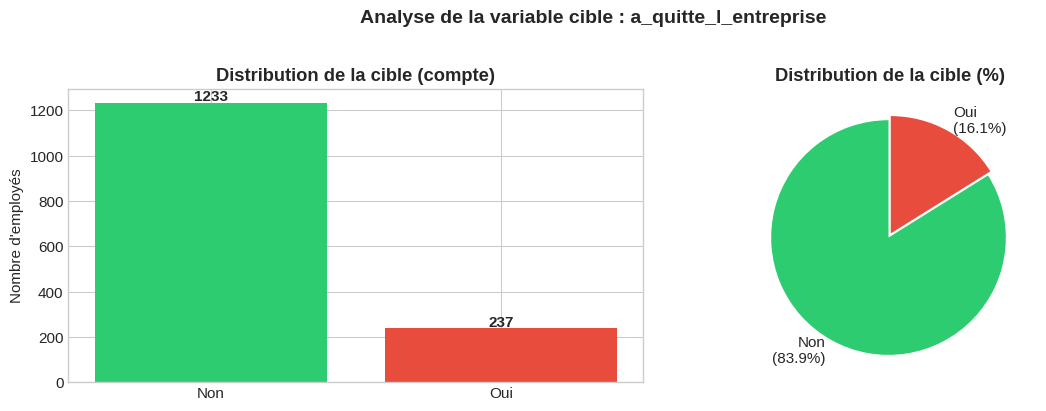


⚠️  Taux de départ global : 16.1%
   → Dataset déséquilibré - À considérer pour la stratégie de modélisation


In [11]:
# Distribution de la variable cible
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Compte absolu
target_counts = merged_cleaned[TARGET].value_counts()
colors = {'Oui': '#e74c3c', 'Non': '#2ecc71'}
axes[0].bar(target_counts.index, target_counts.values,
            color=[colors.get(x, '#3498db') for x in target_counts.index])
axes[0].set_title("Distribution de la cible (compte)", fontweight='bold')
axes[0].set_ylabel("Nombre d'employés")
for i, v in enumerate(target_counts.values):
    axes[0].text(i, v + 10, str(v), ha='center', fontweight='bold')

# Pourcentage
target_pct = target_counts / len(merged_cleaned) * 100
axes[1].pie(target_pct, labels=[f"{k}\n({v:.1f}%)" for k, v in target_pct.items()],
            colors=[colors.get(x, '#3498db') for x in target_pct.index],
            autopct='', startangle=90, explode=[0.02]*len(target_pct))
axes[1].set_title("Distribution de la cible (%)", fontweight='bold')

plt.suptitle(f"Analyse de la variable cible : {TARGET}", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Calcul du déséquilibre
taux_depart = (merged_cleaned[TARGET] == 'Oui').mean()
print(f"\n⚠️  Taux de départ global : {taux_depart:.1%}")
print(f"   → Dataset {'déséquilibré' if taux_depart < 0.3 or taux_depart > 0.7 else 'relativement équilibré'}"
      f" - À considérer pour la stratégie de modélisation")

In [12]:
# Statistiques descriptives des variables numériques
merged_cleaned.describe(include='number').T.style.format("{:.2f}").background_gradient(cmap='Blues', axis=1)

## 2.2 Analyse Univariée

Visualisation de la distribution de chaque variable, segmentée par la variable cible pour identifier les différences entre les employés qui partent et ceux qui restent.

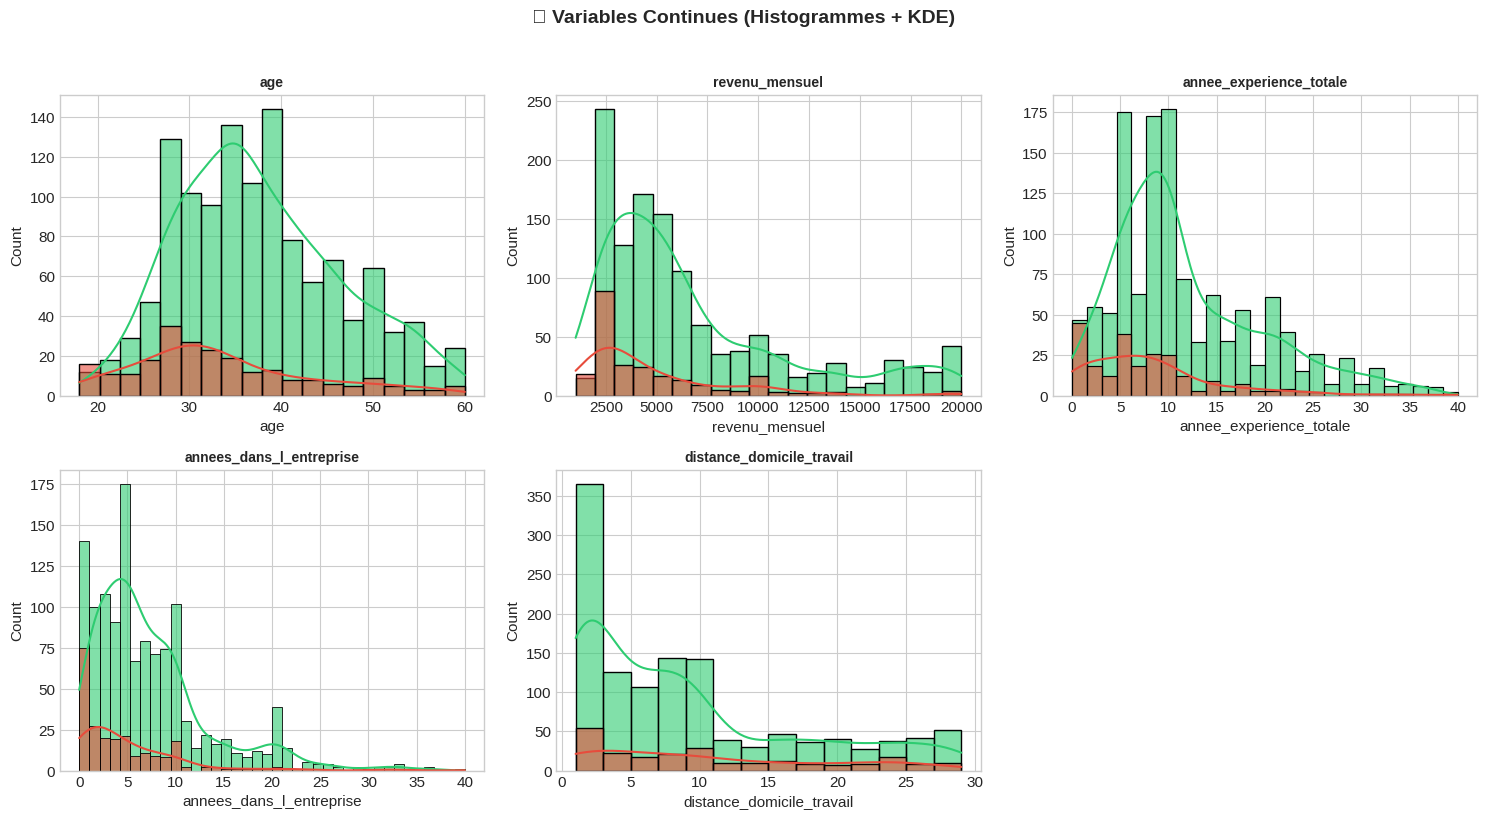

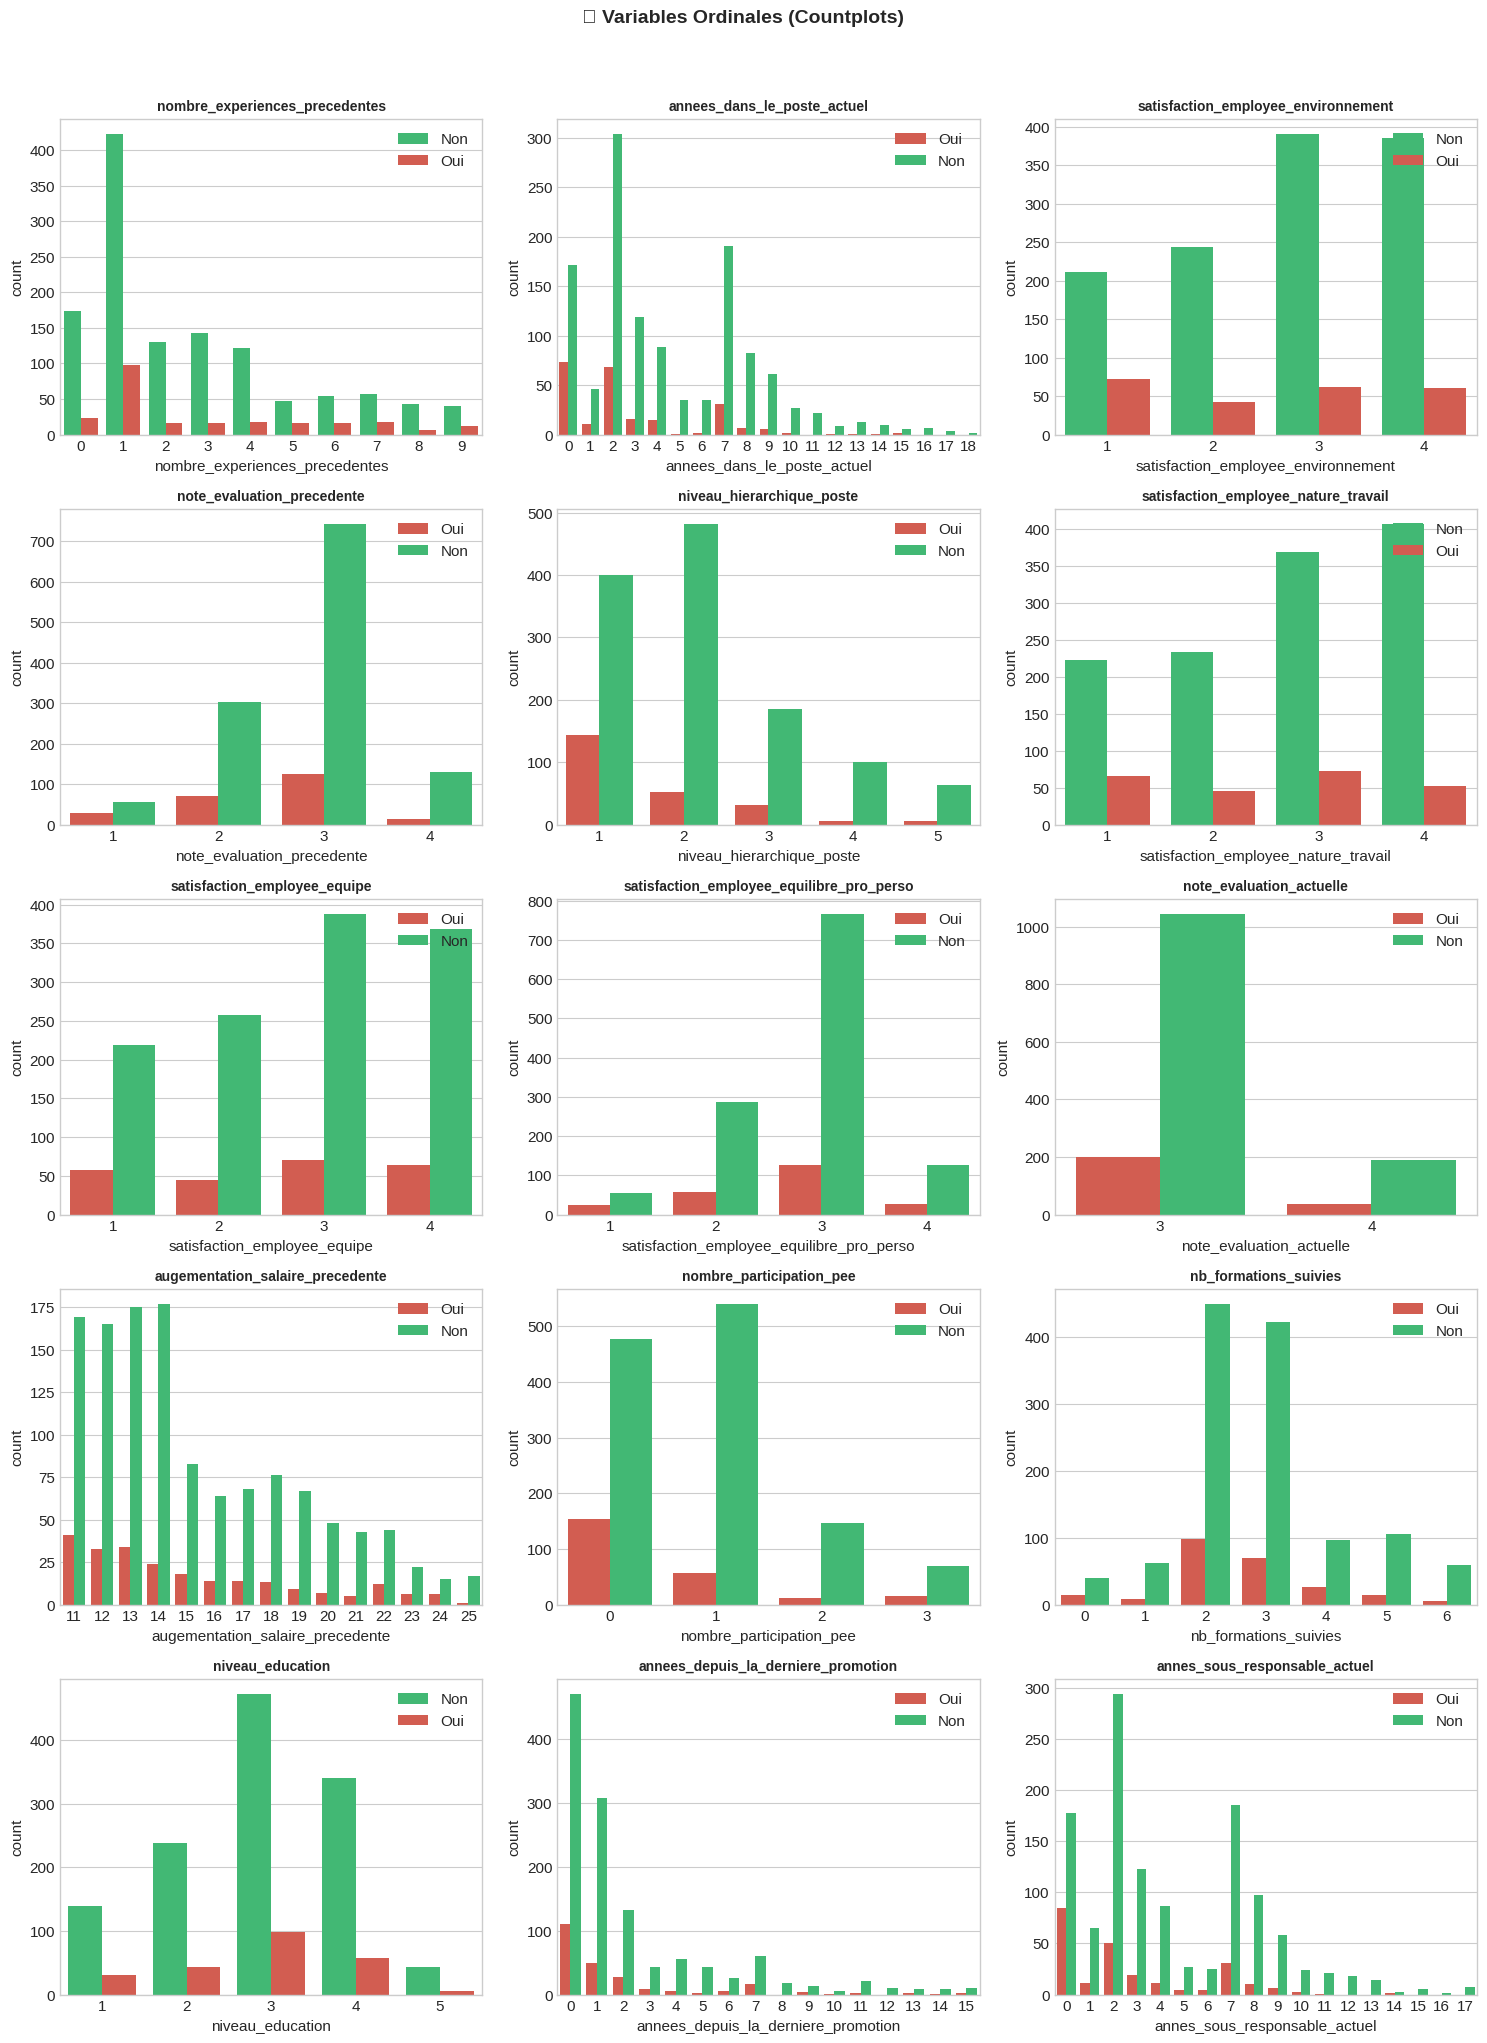

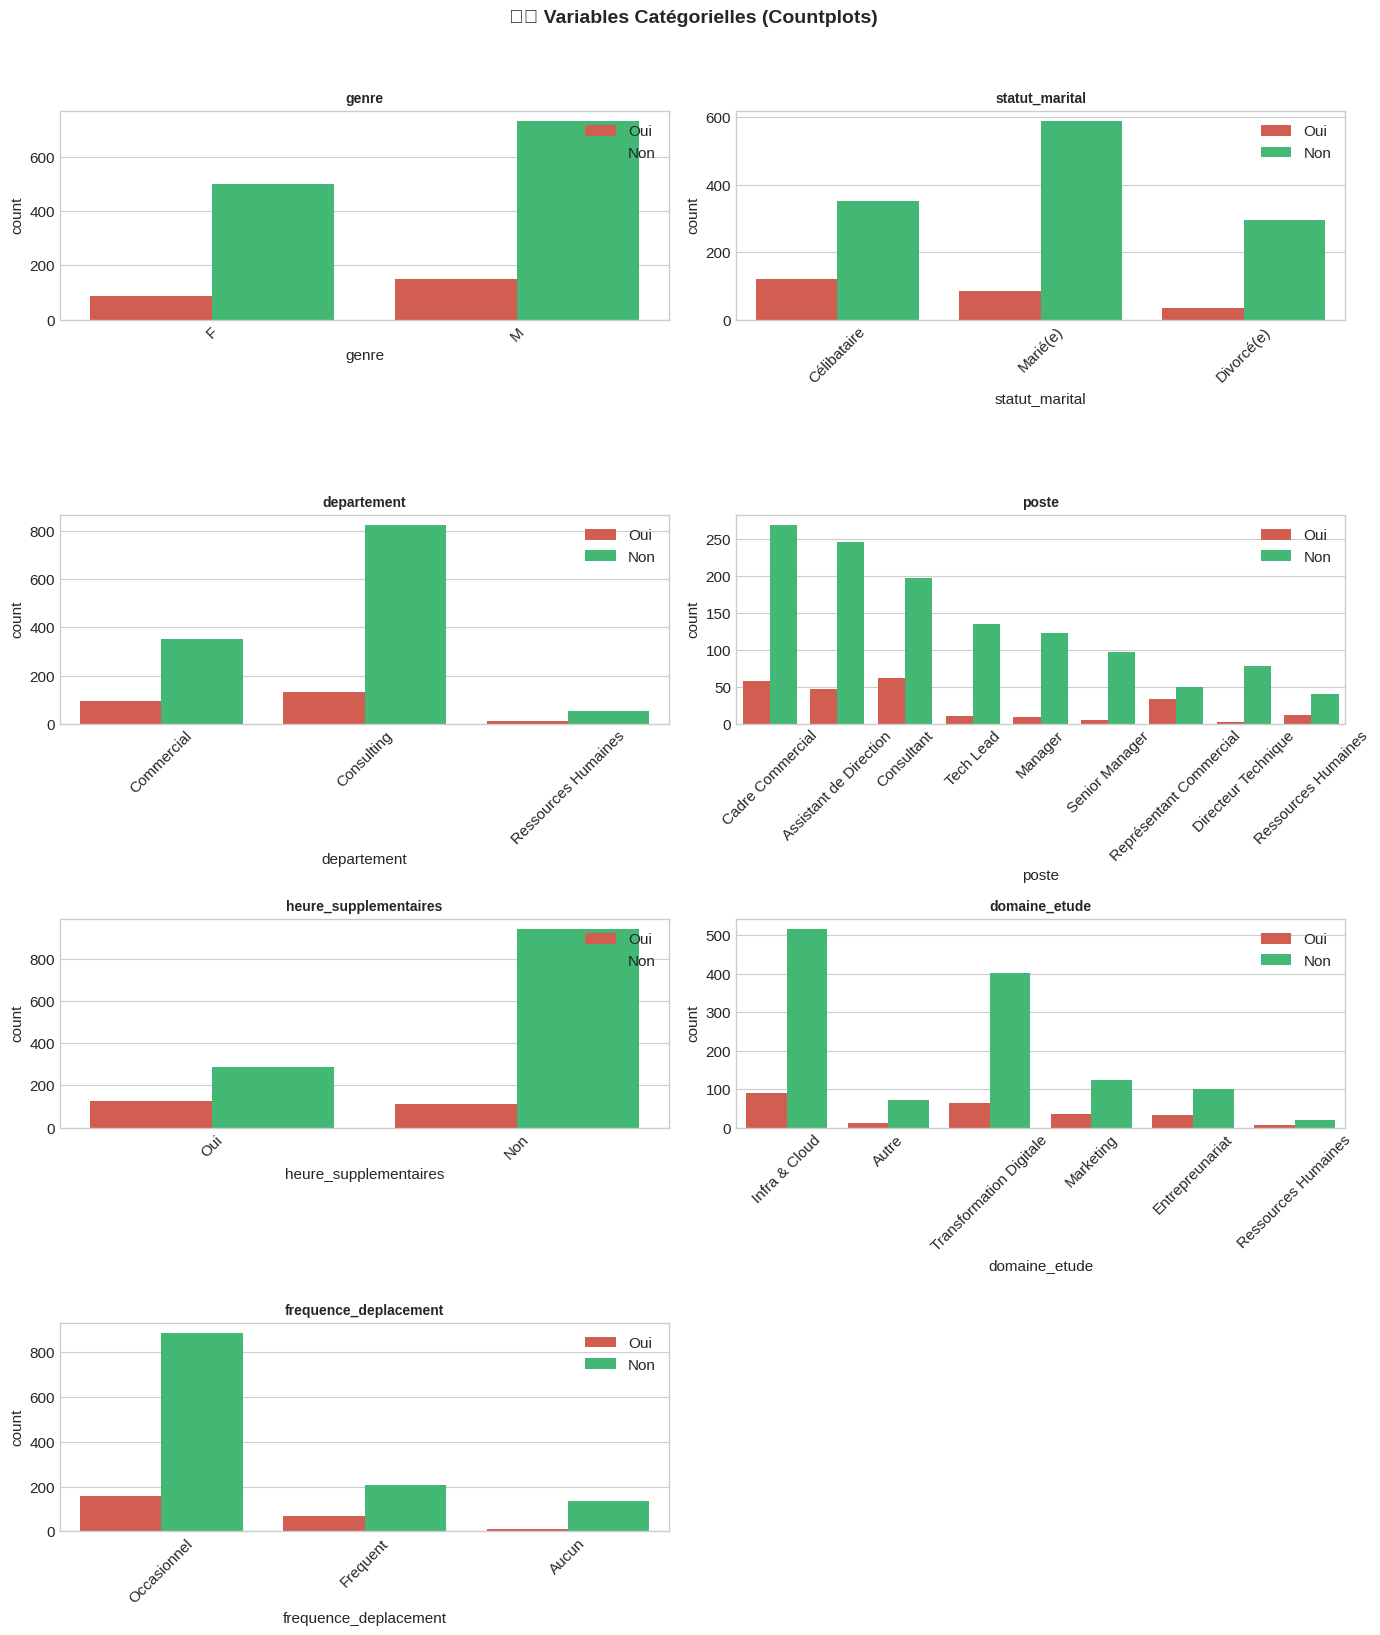

In [13]:
def plot_univariate_analysis(df, col_types, target, palette={'Oui': '#e74c3c', 'Non': '#2ecc71'}):
    """Génère les visualisations univariées pour toutes les variables."""

    # Variables continues - Histogrammes avec KDE
    continuous_cols = [c for c in col_types['continuous'] if c not in ['id_employee', 'eval_number', 'code_sondage']]
    if continuous_cols:
        n_cols = min(3, len(continuous_cols))
        n_rows = (len(continuous_cols) + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
        axes = np.array(axes).flatten() if n_rows * n_cols > 1 else [axes]

        for i, col in enumerate(continuous_cols):
            sns.histplot(data=df, x=col, hue=target, kde=True, ax=axes[i], palette=palette, alpha=0.6)
            axes[i].set_title(f'{col}', fontweight='bold', fontsize=10)
            axes[i].legend(title='', loc='upper right')

        for j in range(i+1, len(axes)):
            axes[j].set_visible(False)

        plt.suptitle('📈 Variables Continues (Histogrammes + KDE)', fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

    # Variables ordinales - Countplots
    ordinal_cols = [c for c in col_types['ordinal'] if c != target]
    if ordinal_cols:
        n_cols = min(3, len(ordinal_cols))
        n_rows = (len(ordinal_cols) + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
        axes = np.array(axes).flatten() if n_rows * n_cols > 1 else [axes]

        for i, col in enumerate(ordinal_cols):
            sns.countplot(data=df, x=col, hue=target, ax=axes[i], palette=palette)
            axes[i].set_title(f'{col}', fontweight='bold', fontsize=10)
            axes[i].legend(title='', loc='upper right')

        for j in range(i+1, len(axes)):
            axes[j].set_visible(False)

        plt.suptitle('📊 Variables Ordinales (Countplots)', fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

    # Variables catégorielles - Countplots
    cat_cols = [c for c in col_types['categorical'] if c != target]
    if cat_cols:
        n_cols = min(2, len(cat_cols))
        n_rows = (len(cat_cols) + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(7*n_cols, 4*n_rows))
        axes = np.array(axes).flatten() if n_rows * n_cols > 1 else [axes]

        for i, col in enumerate(cat_cols):
            sns.countplot(data=df, x=col, hue=target, ax=axes[i], palette=palette)
            axes[i].set_title(f'{col}', fontweight='bold', fontsize=10)
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].legend(title='', loc='upper right')

        for j in range(i+1, len(axes)):
            axes[j].set_visible(False)

        plt.suptitle('🏷️ Variables Catégorielles (Countplots)', fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

# Exécution de l'analyse univariée
plot_univariate_analysis(merged_cleaned, col_types, TARGET)

## 2.3 Analyse Bivariée (vs Variable Cible)

Identification des variables les plus discriminantes pour prédire le départ. Nous analysons :
1. **Écart relatif des moyennes** entre les deux groupes (partants vs restants)
2. **Boxplots comparatifs** pour les variables à fort écart
3. **Taux de départ par segment** (profilage du risque)

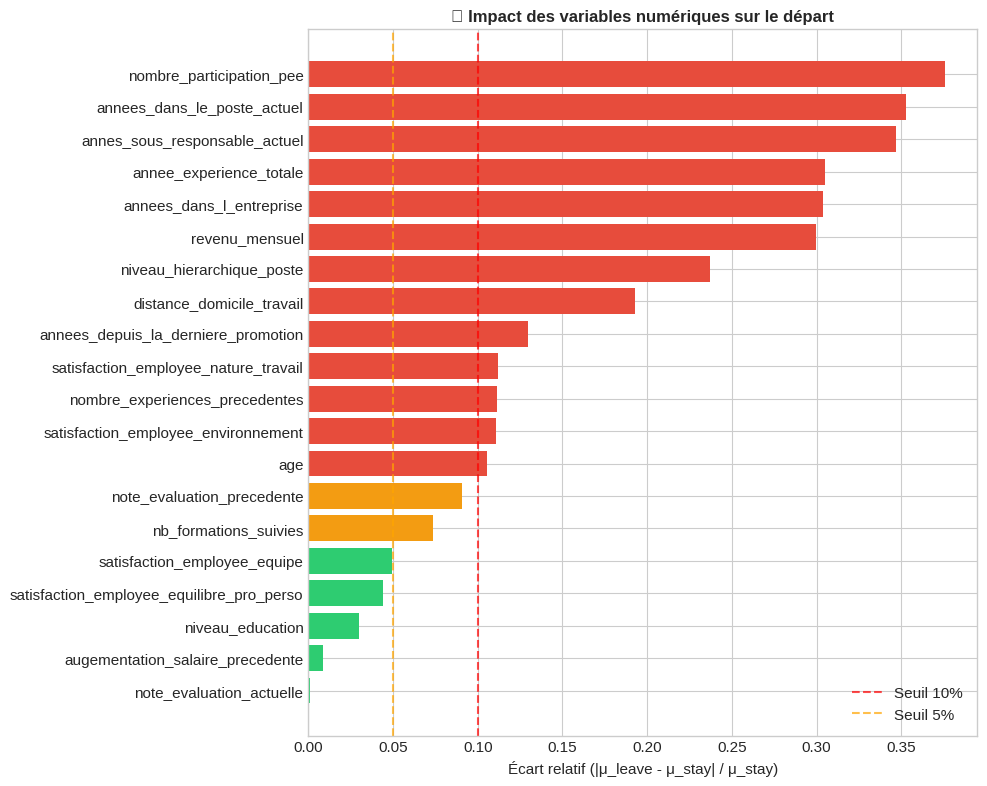


🔍 Top 5 variables avec le plus grand écart : ['nombre_participation_pee', 'annees_dans_le_poste_actuel', 'annes_sous_responsable_actuel', 'annee_experience_totale', 'annees_dans_l_entreprise']


In [14]:
# Séparation des groupes pour analyse comparative
df_leave = merged_cleaned[merged_cleaned[TARGET] == 'Oui']
df_stay = merged_cleaned[merged_cleaned[TARGET] == 'Non']

# Calcul de l'écart relatif des moyennes (uniquement sur les colonnes numériques)
numeric_cols = col_types['continuous'] + col_types['ordinal']
numeric_cols = [c for c in numeric_cols if c in merged_cleaned.select_dtypes(include=[np.number]).columns]

desc_leave = df_leave[numeric_cols].describe().loc['mean']
desc_stay = df_stay[numeric_cols].describe().loc['mean']

ecart_relatif = ((desc_leave - desc_stay).abs() / desc_stay.replace(0, np.nan)).dropna()
ecart_relatif_sorted = ecart_relatif.sort_values(ascending=True)

# Visualisation de l'écart relatif
fig, ax = plt.subplots(figsize=(10, max(6, len(ecart_relatif_sorted) * 0.4)))
colors = ['#e74c3c' if x > 0.1 else '#f39c12' if x > 0.05 else '#2ecc71' for x in ecart_relatif_sorted]
bars = ax.barh(ecart_relatif_sorted.index, ecart_relatif_sorted.values, color=colors)
ax.axvline(x=0.1, color='red', linestyle='--', alpha=0.7, label='Seuil 10%')
ax.axvline(x=0.05, color='orange', linestyle='--', alpha=0.7, label='Seuil 5%')
ax.set_xlabel("Écart relatif (|μ_leave - μ_stay| / μ_stay)")
ax.set_title("🎯 Impact des variables numériques sur le départ", fontweight='bold', fontsize=12)
ax.legend()
plt.tight_layout()
plt.show()

# Top 5 variables à fort écart
top5 = ecart_relatif_sorted.tail(5).index.tolist()[::-1]
print(f"\n🔍 Top 5 variables avec le plus grand écart : {top5}")

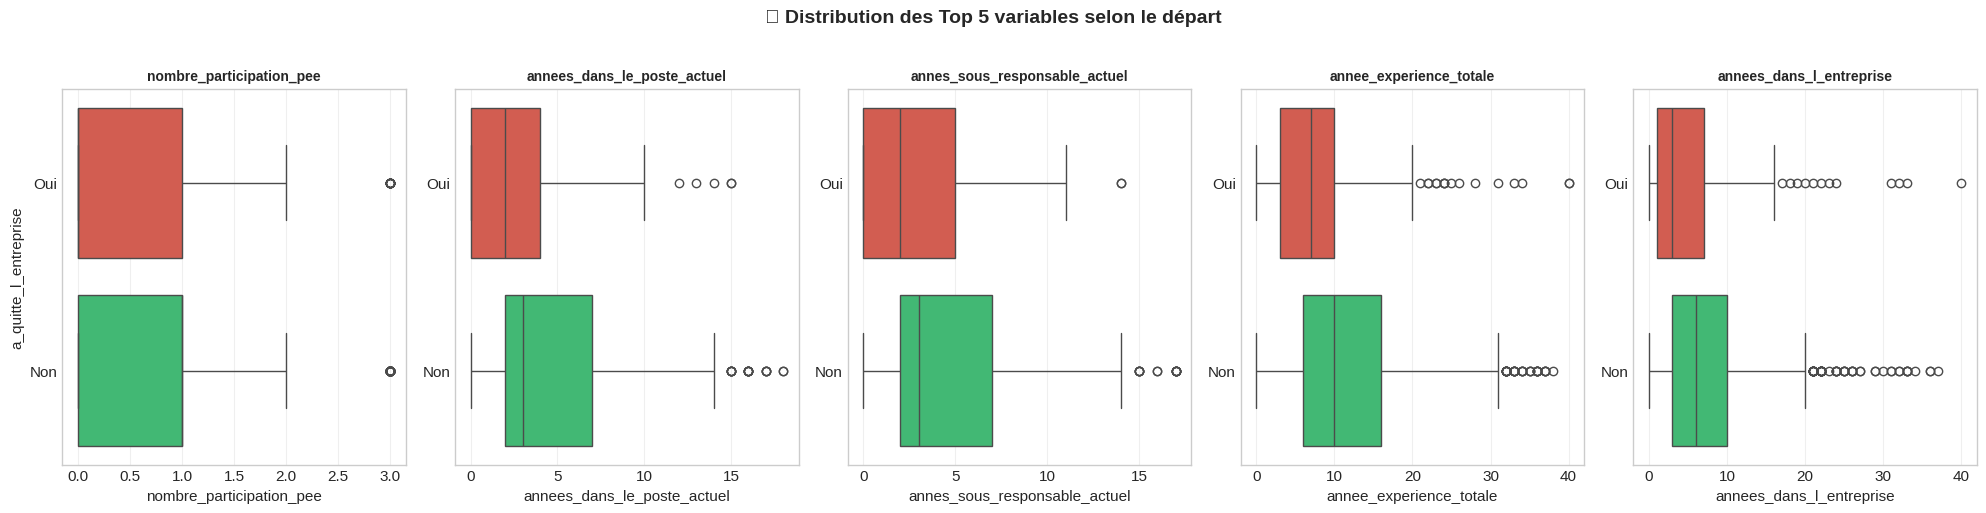

In [15]:
# Boxplots comparatifs pour les Top 5 variables
if len(top5) > 0:
    fig, axes = plt.subplots(1, min(5, len(top5)), figsize=(4*min(5, len(top5)), 5))
    axes = np.array([axes]).flatten() if len(top5) == 1 else axes

    for i, var in enumerate(top5[:5]):
        sns.boxplot(data=merged_cleaned, y=TARGET, x=var, ax=axes[i],
                    palette={'Oui': '#e74c3c', 'Non': '#2ecc71'}, orient='h')
        axes[i].set_title(f'{var}', fontweight='bold', fontsize=10)
        if i > 0:
            axes[i].set_ylabel('')
        axes[i].grid(axis='x', alpha=0.3)

    plt.suptitle("📦 Distribution des Top 5 variables selon le départ", fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

In [16]:
# Profilage du risque : taux de départ par segment pour les variables catégorielles
print(f"📊 Taux de départ global : {taux_depart:.1%}\n")
print("=" * 60)
print("🚨 SEGMENTS À RISQUE (taux de départ supérieur à la moyenne)")
print("=" * 60)

risk_data = []
cat_cols_analysis = col_types['categorical'] + [c for c in col_types['ordinal'] if merged_cleaned[c].nunique() <= 10]

for col in cat_cols_analysis:
    if col == TARGET:
        continue
    ct = pd.crosstab(merged_cleaned[col], merged_cleaned[TARGET], normalize='index')
    if 'Oui' in ct.columns:
        for segment in ct.index:
            rate = ct.loc[segment, 'Oui']
            if rate > taux_depart:
                risk_data.append({
                    'Variable': col,
                    'Segment': segment,
                    'Taux_Départ': rate,
                    'Écart_vs_Global': rate - taux_depart,
                    'Effectif': len(merged_cleaned[merged_cleaned[col] == segment])
                })

df_risk = pd.DataFrame(risk_data).sort_values('Taux_Départ', ascending=False)
display(df_risk.head(15).style.format({
    'Taux_Départ': '{:.1%}',
    'Écart_vs_Global': '{:+.1%}'
}).background_gradient(subset=['Taux_Départ'], cmap='Reds'))

📊 Taux de départ global : 16.1%

🚨 SEGMENTS À RISQUE (taux de départ supérieur à la moyenne)


## 2.4 Analyse des Corrélations et Associations

Deux types d'analyses complémentaires :
- **Corrélation de Pearson** : pour les variables numériques (robuste aux outliers et relations non-linéaires)
- **V de Cramér** : pour mesurer l'association entre variables catégorielles

> 💡 **Interprétation** : Un coefficient > 0.3 indique une corrélation modérée, > 0.5 une corrélation forte.

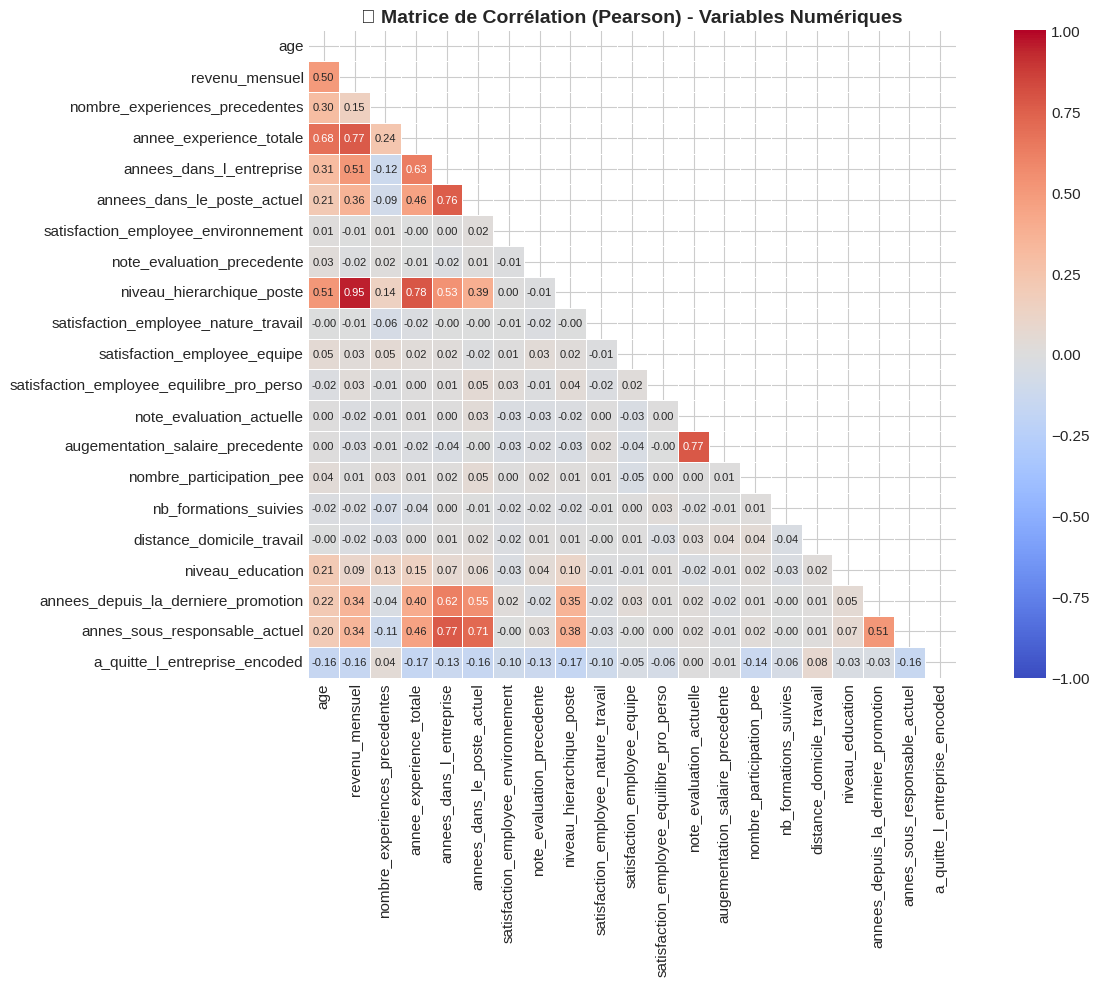


📌 Top corrélations avec 'a_quitte_l_entreprise':
   ↘️ annee_experience_totale: 0.171
   ↘️ niveau_hierarchique_poste: 0.169
   ↘️ annees_dans_le_poste_actuel: 0.161
   ↘️ revenu_mensuel: 0.160
   ↘️ age: 0.159
   ↘️ annes_sous_responsable_actuel: 0.156
   ↘️ nombre_participation_pee: 0.137
   ↘️ annees_dans_l_entreprise: 0.134
   ↘️ note_evaluation_precedente: 0.130
   ↘️ satisfaction_employee_nature_travail: 0.103


In [17]:
# Préparation : encodage de la cible pour les corrélations
df_corr = merged_cleaned.copy()
df_corr[TARGET + '_encoded'] = (df_corr[TARGET] == 'Oui').astype(int)

# Sélection des colonnes numériques pour Pearson
num_cols_corr = [c for c in merged_cleaned.select_dtypes(include=[np.number]).columns
                 if c not in ['id_employee', 'eval_number', 'code_sondage']]
num_cols_corr.append(TARGET + '_encoded')

# Matrice de corrélation Pearson
pearson_matrix = df_corr[num_cols_corr].corr(method='pearson')

# Visualisation
fig, ax = plt.subplots(figsize=(14, 10))
mask = np.triu(np.ones_like(pearson_matrix, dtype=bool))
sns.heatmap(pearson_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0,
            vmin=-1, vmax=1, mask=mask, linewidths=0.5, square=True, ax=ax,
            annot_kws={'size': 8})
ax.set_title("🔗 Matrice de Corrélation (Pearson) - Variables Numériques", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Top corrélations avec la cible
target_corr = pearson_matrix[TARGET + '_encoded'].drop(TARGET + '_encoded').abs().sort_values(ascending=False)
print(f"\n📌 Top corrélations avec '{TARGET}':")
for var, corr in target_corr.head(10).items():
    direction = "↗️" if pearson_matrix.loc[var, TARGET + '_encoded'] > 0 else "↘️"
    print(f"   {direction} {var}: {corr:.3f}")

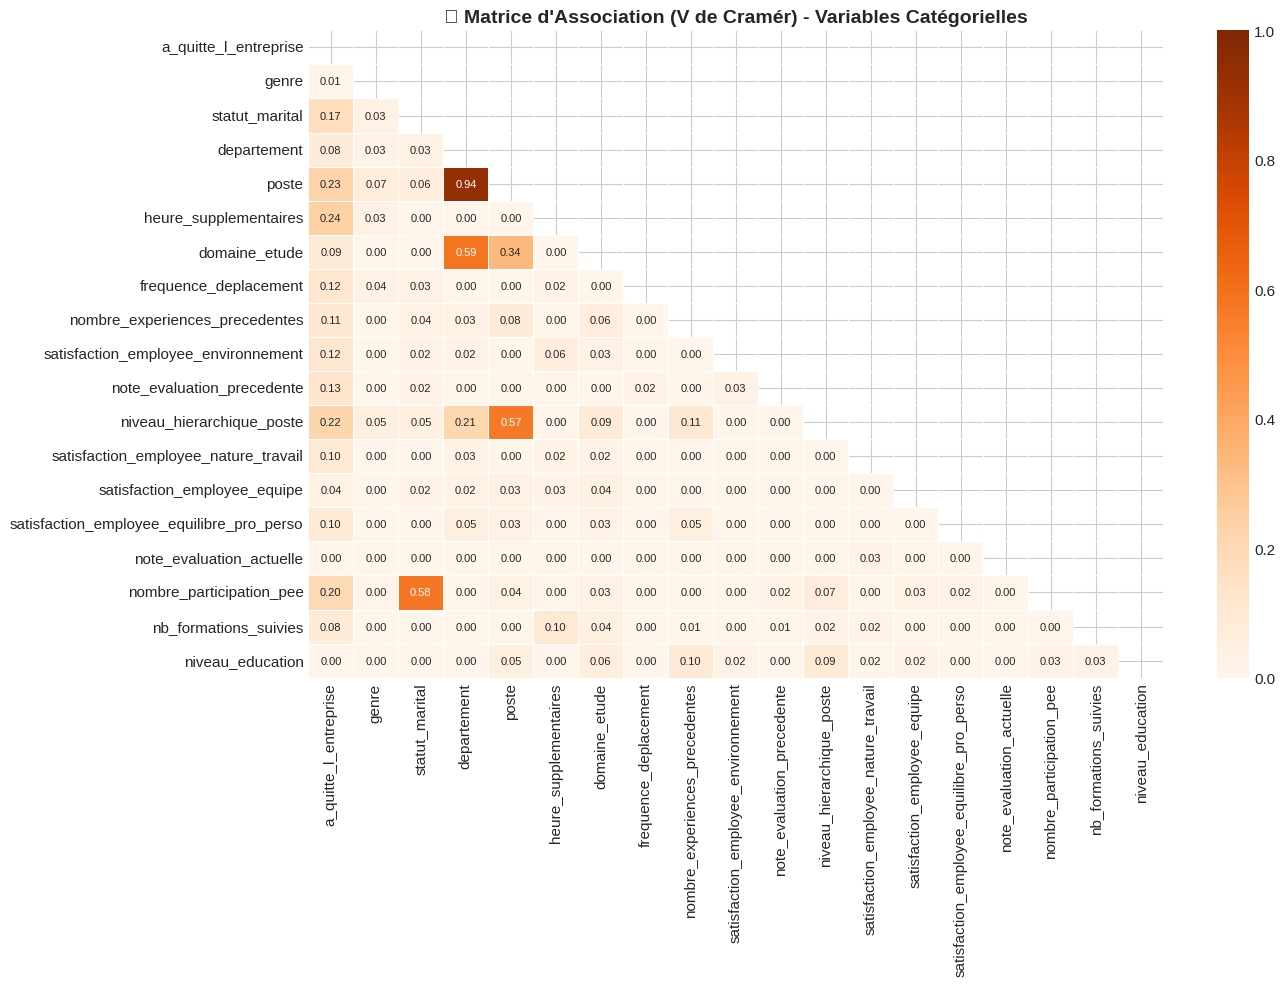


📌 Top associations avec 'a_quitte_l_entreprise' (V de Cramér):
   🟠 Modéré heure_supplementaires: 0.243
   🟠 Modéré poste: 0.231
   🟠 Modéré niveau_hierarchique_poste: 0.216
   🟠 Modéré nombre_participation_pee: 0.198
   🟠 Modéré statut_marital: 0.173
   🟢 Faible note_evaluation_precedente: 0.132
   🟢 Faible frequence_deplacement: 0.123
   🟢 Faible satisfaction_employee_environnement: 0.115
   🟢 Faible nombre_experiences_precedentes: 0.107
   🟢 Faible satisfaction_employee_nature_travail: 0.099


In [18]:
# V de Cramér pour les variables catégorielles
cat_cols_cramer = [TARGET] + [c for c in col_types['categorical'] if c != TARGET]
# Ajouter les variables ordinales avec peu de modalités
cat_cols_cramer += [c for c in col_types['ordinal'] if merged_cleaned[c].nunique() <= 10]
cat_cols_cramer = list(dict.fromkeys(cat_cols_cramer))  # Supprimer doublons en préservant l'ordre

# Calcul de la matrice de Cramér
cramers_matrix = pd.DataFrame(index=cat_cols_cramer, columns=cat_cols_cramer, dtype=float)
for col1 in cat_cols_cramer:
    for col2 in cat_cols_cramer:
        cramers_matrix.loc[col1, col2] = cramers_v(merged_cleaned[col1], merged_cleaned[col2])

# Visualisation
fig, ax = plt.subplots(figsize=(14, 10))
mask = np.triu(np.ones_like(cramers_matrix, dtype=bool))
sns.heatmap(cramers_matrix.astype(float), annot=True, fmt=".2f", cmap='Oranges',
            vmin=0, vmax=1, mask=mask, linewidths=0.5, ax=ax, annot_kws={'size': 8})
ax.set_title("🔗 Matrice d'Association (V de Cramér) - Variables Catégorielles", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Top associations avec la cible
target_cramer = cramers_matrix[TARGET].drop(TARGET).astype(float).sort_values(ascending=False)
print(f"\n📌 Top associations avec '{TARGET}' (V de Cramér):")
for var, v in target_cramer.head(10).items():
    strength = "🔴 Fort" if v > 0.3 else "🟠 Modéré" if v > 0.15 else "🟢 Faible"
    print(f"   {strength} {var}: {v:.3f}")

## 2.5 Conclusions de l'EDA

### 📊 Synthèse des insights clés

In [19]:
# Résumé automatique des findings
print("=" * 70)
print("📋 BILAN DE L'ANALYSE EXPLORATOIRE")
print("=" * 70)

print(f"\n1️⃣  DÉSÉQUILIBRE DE LA CIBLE")
print(f"    • Taux de départ : {taux_depart:.1%}")
print(f"    • Implication : {'Utiliser SMOTE ou class_weight pour rééquilibrer' if taux_depart < 0.3 else 'Dataset relativement équilibré'}")

print(f"\n2️⃣  VARIABLES NUMÉRIQUES LES PLUS DISCRIMINANTES")
for i, (var, ecart) in enumerate(ecart_relatif_sorted.tail(5)[::-1].items(), 1):
    print(f"    {i}. {var} (écart relatif: {ecart:.1%})")

print(f"\n3️⃣  SEGMENTS À PLUS HAUT RISQUE")
if len(df_risk) > 0:
    for _, row in df_risk.head(5).iterrows():
        print(f"    • {row['Variable']}='{row['Segment']}' → {row['Taux_Départ']:.1%} de départ (+{row['Écart_vs_Global']:.1%} vs global)")

print(f"\n4️⃣  CORRÉLATIONS NOTABLES AVEC LA CIBLE")
print("    Pearson (numériques):")
for var, corr in target_corr.head(3).items():
    print(f"      • {var}: {corr:.3f}")
print("    Cramér V (catégorielles):")
for var, v in target_cramer.head(3).items():
    print(f"      • {var}: {v:.3f}")

print(f"\n5️⃣  RECOMMANDATIONS POUR LA MODÉLISATION")
print("    • Feature Engineering : créer des ratios (ancienneté/âge, salaire/expérience)")
print("    • Encodage : One-Hot pour catégorielles à faible cardinalité, Target pour haute cardinalité")
print("    • Gestion du déséquilibre : SMOTE, class_weight='balanced', ou sous-échantillonnage")
print("    • Variables à surveiller : celles identifiées avec fort écart relatif et V de Cramér élevé")
print("=" * 70)

📋 BILAN DE L'ANALYSE EXPLORATOIRE

1️⃣  DÉSÉQUILIBRE DE LA CIBLE
    • Taux de départ : 16.1%
    • Implication : Utiliser SMOTE ou class_weight pour rééquilibrer

2️⃣  VARIABLES NUMÉRIQUES LES PLUS DISCRIMINANTES
    1. nombre_participation_pee (écart relatif: 37.6%)
    2. annees_dans_le_poste_actuel (écart relatif: 35.3%)
    3. annes_sous_responsable_actuel (écart relatif: 34.7%)
    4. annee_experience_totale (écart relatif: 30.5%)
    5. annees_dans_l_entreprise (écart relatif: 30.4%)

3️⃣  SEGMENTS À PLUS HAUT RISQUE
    • poste='Représentant Commercial' → 39.8% de départ (+23.6% vs global)
    • note_evaluation_precedente='1' → 33.7% de départ (+17.6% vs global)
    • satisfaction_employee_equilibre_pro_perso='1' → 31.2% de départ (+15.1% vs global)
    • heure_supplementaires='Oui' → 30.5% de départ (+14.4% vs global)
    • nb_formations_suivies='0' → 27.8% de départ (+11.7% vs global)

4️⃣  CORRÉLATIONS NOTABLES AVEC LA CIBLE
    Pearson (numériques):
      • annee_experience

# 3. Préparation des Données & Feature Engineering

Cette section prépare les données pour la modélisation en suivant les bonnes pratiques ML :
1. **Séparation X/y** avant tout preprocessing (éviter les fuites de données)
2. **Feature Engineering** : création de variables métier pertinentes
3. **Pipeline sklearn** : encapsulation du preprocessing pour reproductibilité
4. **Gestion du déséquilibre** : stratégies pour la classe minoritaire

> ⚠️ **Principe clé** : Le preprocessing (scaling, encoding) doit être *fit* uniquement sur le train et *transform* sur le test.

## 3.1 Séparation Features / Target & Train-Test Split

La séparation train/test doit être faite **avant** le feature engineering et le preprocessing pour éviter toute fuite de données.

In [20]:
# Colonnes à exclure (identifiants, constantes)
COLS_TO_DROP = ['id_employee', 'code_sondage', 'eval_number']

# Préparation du dataset
df_model = merged_cleaned.copy()

# Suppression des colonnes inutiles
cols_to_drop_existing = [c for c in COLS_TO_DROP if c in df_model.columns]
df_model = df_model.drop(columns=cols_to_drop_existing)

# Séparation X / y
X = df_model.drop(columns=[TARGET])
y = df_model[TARGET].map({'Oui': 1, 'Non': 0})  # Encodage binaire de la cible

print(f"📊 Dimensions du dataset :")
print(f"   • X : {X.shape[0]} observations × {X.shape[1]} features")
print(f"   • y : {y.shape[0]} observations")
print(f"\n🎯 Distribution de la cible :")
print(f"   • Classe 0 (Non) : {(y == 0).sum()} ({(y == 0).mean():.1%})")
print(f"   • Classe 1 (Oui) : {(y == 1).sum()} ({(y == 1).mean():.1%})")

📊 Dimensions du dataset :
   • X : 1470 observations × 27 features
   • y : 1470 observations

🎯 Distribution de la cible :
   • Classe 0 (Non) : 1233 (83.9%)
   • Classe 1 (Oui) : 237 (16.1%)


In [21]:
# Train-Test Split STRATIFIÉ (conserve les proportions de la cible)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=y  # Important pour dataset déséquilibré
)

print(f"✅ Split réalisé (75% train / 25% test)")
print(f"\n📊 Dimensions :")
print(f"   • Train : {X_train.shape[0]} observations")
print(f"   • Test  : {X_test.shape[0]} observations")
print(f"\n🎯 Vérification stratification :")
print(f"   • Train - Classe 1 : {y_train.mean():.1%}")
print(f"   • Test  - Classe 1 : {y_test.mean():.1%}")

✅ Split réalisé (75% train / 25% test)

📊 Dimensions :
   • Train : 1102 observations
   • Test  : 368 observations

🎯 Vérification stratification :
   • Train - Classe 1 : 16.2%
   • Test  - Classe 1 : 16.0%


## 3.2 Feature Engineering

Création de nouvelles variables métier basées sur l'analyse exploratoire :
- **Ratios de frustration** : salaire vs expérience/âge
- **Indicateurs de stagnation** : évolution de carrière, fidélité au manager
- **Job hopping** : durée moyenne par emploi
- **Discrétisation** : transformation de variables continues en catégories

In [22]:
def create_features(df):
    """
    Crée des features métier pertinentes pour la prédiction du turnover.
    Applique les mêmes transformations sur train et test.
    """
    df = df.copy()

    # 1. Ratios de Frustration (salaire vs expérience/âge)
    if 'revenu_mensuel' in df.columns:
        if 'annee_experience_totale' in df.columns:
            df['ratio_revenu_experience'] = df['revenu_mensuel'] / (df['annee_experience_totale'] + 1)
        if 'age' in df.columns:
            df['ratio_revenu_age'] = df['revenu_mensuel'] / df['age']

    # 2. Indicateurs de Stagnation
    if 'annees_dans_le_poste_actuel' in df.columns and 'annees_dans_l_entreprise' in df.columns:
        df['taux_stagnation'] = df['annees_dans_le_poste_actuel'] / (df['annees_dans_l_entreprise'] + 1)

    if 'annes_sous_responsable_actuel' in df.columns and 'annees_dans_le_poste_actuel' in df.columns:
        df['fidelite_manager'] = df['annes_sous_responsable_actuel'] / (df['annees_dans_le_poste_actuel'] + 1)

    # 3. Job Hopping (faible = turnover fréquent)
    if 'annee_experience_totale' in df.columns and 'nombre_experiences_precedentes' in df.columns:
        df['duree_moyenne_par_job'] = df['annee_experience_totale'] / (df['nombre_experiences_precedentes'] + 1)

    # 4. Discrétisation de la distance domicile-travail
    if 'distance_domicile_travail' in df.columns:
        df['distance_cat'] = pd.cut(
            df['distance_domicile_travail'],
            bins=[-1, 2, 7, 14, np.inf],
            labels=[0, 1, 2, 3]  # proche, moyen, loin, très loin
        ).astype(int)
    
    # 5. Interaction Job hopping et participation au pee
    if 'nombre_participation_pee' in df.columns and 'duree_moyenne_par_job' in df.columns:
        df['job_hopping_x_participation_pee'] = df['duree_moyenne_par_job'] / (df['nombre_participation_pee'] + 1)

    return df

# Liste des nouvelles features créées
NEW_FEATURES = ['ratio_revenu_experience', 'ratio_revenu_age', 'taux_stagnation',
                'fidelite_manager', 'duree_moyenne_par_job', 'distance_cat', 'job_hopping_x_participation_pee']

# Application sur train et test
X_train_fe = create_features(X_train)
X_test_fe = create_features(X_test)

# Affichage des nouvelles features
created = [f for f in NEW_FEATURES if f in X_train_fe.columns]
print(f"✅ {len(created)} nouvelles features créées : {created}")
print(f"\n📊 Aperçu des nouvelles features (train) :")
display(X_train_fe[created].describe().T.style.format("{:.2f}").background_gradient(cmap='Blues', axis=1))

✅ 7 nouvelles features créées : ['ratio_revenu_experience', 'ratio_revenu_age', 'taux_stagnation', 'fidelite_manager', 'duree_moyenne_par_job', 'distance_cat', 'job_hopping_x_participation_pee']

📊 Aperçu des nouvelles features (train) :


## 3.3 Pipeline de Preprocessing (sklearn)

Construction d'un `ColumnTransformer` pour appliquer les transformations appropriées :
- **Variables numériques** : `StandardScaler` (normalisation)
- **Variables catégorielles** : `OneHotEncoder` (encodage one-hot)
- **Variables binaires** : `OrdinalEncoder` (0/1)

> 💡 Le pipeline garantit que le même preprocessing est appliqué de manière cohérente sur train et test.

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline

# Classification automatique des colonnes après feature engineering
def get_column_types(df):
    """Identifie les types de colonnes pour le preprocessing."""
    numeric_cols = []
    binary_cols = []
    categorical_cols = []

    for col in df.columns:
        n_unique = df[col].nunique()
        dtype = df[col].dtype

        if dtype == 'object':
            if n_unique == 2:
                binary_cols.append(col)
            else:
                categorical_cols.append(col)
        elif dtype in ['int64', 'float64']:
            if n_unique == 2:
                binary_cols.append(col)
            elif n_unique > 10:  # Continue
                numeric_cols.append(col)
            else:  # Ordinal traité comme numérique
                numeric_cols.append(col)

    return numeric_cols, binary_cols, categorical_cols

# Identification des types de colonnes
numeric_cols, binary_cols, categorical_cols = get_column_types(X_train_fe)

print("📋 Classification des colonnes pour le preprocessing :")
print(f"   • Numériques ({len(numeric_cols)}) : {numeric_cols[:5]}..." if len(numeric_cols) > 5 else f"   • Numériques ({len(numeric_cols)}) : {numeric_cols}")
print(f"   • Binaires ({len(binary_cols)}) : {binary_cols}")
print(f"   • Catégorielles ({len(categorical_cols)}) : {categorical_cols}")

📋 Classification des colonnes pour le preprocessing :
   • Numériques (26) : ['age', 'revenu_mensuel', 'nombre_experiences_precedentes', 'annee_experience_totale', 'annees_dans_l_entreprise']...
   • Binaires (3) : ['genre', 'note_evaluation_actuelle', 'heure_supplementaires']
   • Catégorielles (5) : ['statut_marital', 'departement', 'poste', 'domaine_etude', 'frequence_deplacement']


In [24]:
# Construction du ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('bin', OrdinalEncoder(), binary_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough',  # Conserver les colonnes non spécifiées
    verbose_feature_names_out=False
)

# Fit sur le train, transform sur train et test
X_train_processed = preprocessor.fit_transform(X_train_fe)
X_test_processed = preprocessor.transform(X_test_fe)

# Récupération des noms de features après transformation
feature_names = preprocessor.get_feature_names_out()

# Conversion en DataFrame pour lisibilité
X_train = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train_fe.index)
X_test = pd.DataFrame(X_test_processed, columns=feature_names, index=X_test_fe.index)



print(f"✅ Preprocessing terminé")
print(f"\n📊 Dimensions après transformation :")
print(f"   • Train : {X_train_processed.shape}")
print(f"   • Test  : {X_test_processed.shape}")
print(f"\n📋 Features après encoding ({len(feature_names)} total) :")
print(f"   {list(feature_names)[:10]}..." if len(feature_names) > 10 else f"   {list(feature_names)}")

✅ Preprocessing terminé

📊 Dimensions après transformation :
   • Train : (1102, 48)
   • Test  : (368, 48)

📋 Features après encoding (48 total) :
   ['age', 'revenu_mensuel', 'nombre_experiences_precedentes', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail']...


## 3.4 Gestion du Déséquilibre des Classes

Le dataset présente un déséquilibre significatif (~16% de départs). Plusieurs stratégies sont possibles :

| Stratégie | Description | Avantages | Inconvénients |
|-----------|-------------|-----------|---------------|
| **class_weight='balanced'** | Pondération dans le modèle | Simple, pas de modification des données | Dépend du modèle |
| **SMOTE** | Sur-échantillonnage synthétique | Augmente la classe minoritaire | Peut créer du bruit |
| **Sous-échantillonnage** | Réduction de la classe majoritaire | Simple | Perte d'information |

> 💡 Pour ce projet, nous utiliserons principalement `class_weight='balanced'` dans les modèles, avec SMOTE en option pour comparaison.

In [25]:
# Calcul des poids de classe pour les modèles
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}

print(f"⚖️ Poids de classe calculés (pour class_weight='balanced') :")
print(f"   • Classe 0 (Non) : {class_weight_dict[0]:.3f}")
print(f"   • Classe 1 (Oui) : {class_weight_dict[1]:.3f}")
print(f"\n   → La classe minoritaire sera pondérée {class_weight_dict[1]/class_weight_dict[0]:.1f}x plus")

⚖️ Poids de classe calculés (pour class_weight='balanced') :
   • Classe 0 (Non) : 0.596
   • Classe 1 (Oui) : 3.096

   → La classe minoritaire sera pondérée 5.2x plus


In [26]:
# Optionnel : SMOTE pour sur-échantillonnage (à utiliser uniquement sur le train)
try:
    from imblearn.over_sampling import SMOTE

    smote = SMOTE(random_state=RANDOM_STATE)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

    print(f"✅ SMOTE disponible et appliqué sur le train")
    print(f"\n📊 Distribution AVANT SMOTE :")
    print(f"   • Classe 0 : {(y_train == 0).sum()}")
    print(f"   • Classe 1 : {(y_train == 1).sum()}")
    print(f"\n📊 Distribution APRÈS SMOTE :")
    print(f"   • Classe 0 : {(y_train_smote == 0).sum()}")
    print(f"   • Classe 1 : {(y_train_smote == 1).sum()}")
    SMOTE_AVAILABLE = True
except ImportError:
    print("⚠️ imbalanced-learn non installé. SMOTE non disponible.")
    print("   Pour l'installer : pip install imbalanced-learn")
    X_train_smote, y_train_smote = X_train_processed, y_train
    SMOTE_AVAILABLE = False

✅ SMOTE disponible et appliqué sur le train

📊 Distribution AVANT SMOTE :
   • Classe 0 : 924
   • Classe 1 : 178

📊 Distribution APRÈS SMOTE :
   • Classe 0 : 924
   • Classe 1 : 924


## 3.5 Bilan du Preprocessing

In [27]:
# Résumé du preprocessing
print("=" * 70)
print("📋 BILAN DU PREPROCESSING")
print("=" * 70)

print(f"\n1️⃣  SÉPARATION DES DONNÉES")
print(f"    • Train : {X_train_processed.shape[0]} observations")
print(f"    • Test  : {X_test_processed.shape[0]} observations")
print(f"    • Ratio : 75% / 25% (stratifié)")

print(f"\n2️⃣  FEATURE ENGINEERING")
print(f"    • Features créées : {len(created)}")
print(f"    • Nouvelles variables : {created}")

print(f"\n3️⃣  PREPROCESSING PIPELINE")
print(f"    • Variables numériques ({len(numeric_cols)}) : StandardScaler")
print(f"    • Variables binaires ({len(binary_cols)}) : OrdinalEncoder")
print(f"    • Variables catégorielles ({len(categorical_cols)}) : OneHotEncoder")
print(f"    • Features finales : {X_train_processed.shape[1]}")

print(f"\n4️⃣  GESTION DU DÉSÉQUILIBRE")
print(f"    • Taux de classe minoritaire : {y_train.mean():.1%}")
print(f"    • Stratégie principale : class_weight='balanced'")
print(f"    • SMOTE disponible : {'Oui' if SMOTE_AVAILABLE else 'Non'}")

print(f"\n5️⃣  DATASETS PRÊTS POUR LA MODÉLISATION")
print(f"    • X_train_processed : {X_train_processed.shape}")
print(f"    • X_test_processed  : {X_test_processed.shape}")
print(f"    • y_train : {y_train.shape}")
print(f"    • y_test  : {y_test.shape}")
if SMOTE_AVAILABLE:
    print(f"    • X_train_smote (optionnel) : {X_train_smote.shape}")
print("=" * 70)
X_train.describe()

📋 BILAN DU PREPROCESSING

1️⃣  SÉPARATION DES DONNÉES
    • Train : 1102 observations
    • Test  : 368 observations
    • Ratio : 75% / 25% (stratifié)

2️⃣  FEATURE ENGINEERING
    • Features créées : 7
    • Nouvelles variables : ['ratio_revenu_experience', 'ratio_revenu_age', 'taux_stagnation', 'fidelite_manager', 'duree_moyenne_par_job', 'distance_cat', 'job_hopping_x_participation_pee']

3️⃣  PREPROCESSING PIPELINE
    • Variables numériques (26) : StandardScaler
    • Variables binaires (3) : OrdinalEncoder
    • Variables catégorielles (5) : OneHotEncoder
    • Features finales : 48

4️⃣  GESTION DU DÉSÉQUILIBRE
    • Taux de classe minoritaire : 16.2%
    • Stratégie principale : class_weight='balanced'
    • SMOTE disponible : Oui

5️⃣  DATASETS PRÊTS POUR LA MODÉLISATION
    • X_train_processed : (1102, 48)
    • X_test_processed  : (368, 48)
    • y_train : (1102,)
    • y_test  : (368,)
    • X_train_smote (optionnel) : (1848, 48)


age  revenu_mensuel  nombre_experiences_precedentes  \
count  1.102000e+03    1.102000e+03                    1.102000e+03   
mean  -1.611939e-17    9.752231e-17                    1.031641e-16   
std    1.000454e+00    1.000454e+00                    1.000454e+00   
min   -2.064815e+00   -1.189589e+00                   -1.080154e+00   
25%   -7.556569e-01   -7.700768e-01                   -6.792348e-01   
50%   -1.556259e-01   -3.269331e-01                   -2.783153e-01   
75%    6.625982e-01    3.997339e-01                    5.235238e-01   
max    2.517239e+00    2.921849e+00                    2.528121e+00   

       annee_experience_totale  annees_dans_l_entreprise  \
count             1.102000e+03              1.102000e+03   
mean             -4.835817e-17              7.898501e-17   
std               1.000454e+00              1.000454e+00   
min              -1.453861e+00             -1.156655e+00   
25%              -6.796864e-01             -6.573860e-01   
50%              -1.635697e-01             -3.245400e-01   
75%               4.815763e-01              3.411521e-01   
max               3.707306e+00              5.000996e+00   

       annees_dans_le_poste_actuel  satisfaction_employee_environnement  \
count                 1.102000e+03                         1.102000e+03   
mean                  8.220889e-17                        -7.414920e-17   
std                   1.000454e+00                         1.000454e+00   
min                  -1.170867e+00                        -1.577764e+00   
25%                  -6.125394e-01                        -6.568445e-01   
50%                  -3.333754e-01                         2.640749e-01   
75%                   7.832803e-01                         1.184994e+00   
max                   3.574919e+00                         1.184994e+00   

       note_evaluation_precedente  niveau_hierarchique_poste  \
count                1.102000e+03               1.102000e+03   
mean                -4.916414e-17              -1.362089e-16   
std                  1.000454e+00               1.000454e+00   
min                 -2.457082e+00              -9.849193e-01   
25%                 -1.043137e+00              -9.849193e-01   
50%                  3.708076e-01              -6.276036e-02   
75%                  3.708076e-01               8.593986e-01   
max                  1.784752e+00               2.703716e+00   

       satisfaction_employee_nature_travail  ...  poste_Ressources Humaines  \
count                          1.102000e+03  ...                1102.000000   
mean                          -9.026859e-17  ...                   0.034483   
std                            1.000454e+00  ...                   0.182548   
min                           -1.541493e+00  ...                   0.000000   
25%                           -6.412677e-01  ...                   0.000000   
50%                            2.589578e-01  ...                   0.000000   
75%                            1.159183e+00  ...                   0.000000   
max                            1.159183e+00  ...                   1.000000   

       poste_Senior Manager  poste_Tech Lead  domaine_etude_Entrepreunariat  \
count           1102.000000      1102.000000                    1102.000000   
mean               0.069873         0.096189                       0.100726   
std                0.255049         0.294984                       0.301102   
min                0.000000         0.000000                       0.000000   
25%                0.000000         0.000000                       0.000000   
50%                0.000000         0.000000                       0.000000   
75%                0.000000         0.000000                       0.000000   
max                1.000000         1.000000                       1.000000   

       domaine_etude_Infra & Cloud  domaine_etude_Marketing  \
count                  1102.000000              1102.000000   
mean                      0.4056

# 4. Modélisation 🤖

**Objectif :** Entraîner et comparer plusieurs modèles de classification pour prédire le turnover.

**Stratégie :**
1. **Baseline** : DummyClassifier + LogisticRegression (références)
2. **Ensembles** : RandomForest, GradientBoosting, XGBoost (avec hyperparameter tuning)
3. **Évaluation** : Focus sur le **F1-score** et le **Recall** (classe 1 = démission)
4. **Optimisation** : Ajustement du seuil de décision

> ⚠️ **Note métier** : Dans un contexte RH, un Faux Négatif (ne pas détecter un démissionnaire) est plus coûteux qu'un Faux Positif (fausse alerte). On privilégiera donc le **Recall**.

## 4.1 Configuration & Fonctions Helper

Centralisation des outils pour l'entraînement et l'évaluation des modèles.

In [70]:
# ============================================================
# CONFIGURATION MODÉLISATION
# ============================================================

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    f1_score, precision_score, recall_score, make_scorer,
    roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
)
import xgboost as xgb

# Cross-validation standard
CV_FOLDS = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Scorer pour optimiser le F1 de la classe 1 (démission)
F1_SCORER = make_scorer(f1_score, average='binary', pos_label=1)

# Stockage des résultats
models_results = {}

print("✅ Configuration modélisation chargée")

✅ Configuration modélisation chargée


### 📊 Importance de l'analyse de la variance en Cross-Validation

L'écart-type (std) des scores CV par fold est un indicateur crucial de la **stabilité** du modèle :

| Écart-type | Interprétation | Action |
|------------|----------------|--------|
| **< 0.02** | Très stable | ✅ Modèle robuste |
| **0.02 - 0.05** | Acceptable | 🟡 Surveiller sur nouveaux jeux |
| **> 0.05** | Instable | ⚠️ Risque de variance élevée |

**Pourquoi c'est important :**
- Un **std élevé** indique que le modèle est sensible à la composition des données d'entraînement
- Cela peut révéler un **overfitting** ou une **taille d'échantillon insuffisante**
- Un modèle avec un F1 moyen légèrement inférieur mais un std plus faible peut être **préférable en production**

**Comment interpréter :**
- Calculer `mean ± 2*std` donne un intervalle de confiance à ~95%
- Si cet intervalle est trop large, le modèle manque de fiabilité

In [71]:
# ============================================================
# FONCTIONS HELPER
# ============================================================

def evaluate_model(model, model_name, X_tr, y_tr, X_te, y_te, store=True, show_cv=True):
    """
    Évalue un modèle et stocke les résultats.
    
    Parameters:
    -----------
    show_cv : bool - Si True, affiche l'analyse CV par fold
    
    Returns:
        dict avec les métriques et prédictions
    """
    # Prédictions
    y_pred_train = model.predict(X_tr)
    y_pred_test = model.predict(X_te)

    # Métriques sur TEST
    metrics = {
        'accuracy': (y_pred_test == y_te).mean(),
        'f1_class1': f1_score(y_te, y_pred_test, pos_label=1),
        'precision_class1': precision_score(y_te, y_pred_test, pos_label=1, zero_division=0),
        'recall_class1': recall_score(y_te, y_pred_test, pos_label=1),
        'confusion_matrix': confusion_matrix(y_te, y_pred_test)
    }

    # Affichage
    print(f"\n{'='*60}")
    print(f"📊 Modèle : {model_name}")
    print(f"{'='*60}")

    # ============================================================
    # ANALYSE CROSS-VALIDATION PAR FOLD
    # ============================================================
    if show_cv:
        print("\n--- Analyse Cross-Validation (5 folds) ---")
        
        # Pour XGBoost avec early_stopping, créer une version sans early stopping pour CV
        from sklearn.base import clone
        
        try:
            # Tenter de cloner le modèle pour CV
            if hasattr(model, 'early_stopping_rounds') and model.early_stopping_rounds is not None:
                # Créer un nouveau modèle XGBoost sans early stopping pour CV
                cv_model = clone(model)
                cv_model.set_params(early_stopping_rounds=None)
            else:
                cv_model = model
        except Exception:
            # Si le clone échoue, utiliser le modèle original
            cv_model = model
        
        try:
            # Scores par fold pour plusieurs métriques
            cv_f1 = cross_val_score(cv_model, X_tr, y_tr, cv=CV_FOLDS, scoring='f1')
            cv_precision = cross_val_score(cv_model, X_tr, y_tr, cv=CV_FOLDS, scoring='precision')
            cv_recall = cross_val_score(cv_model, X_tr, y_tr, cv=CV_FOLDS, scoring='recall')
            
            # Stockage des stats CV
            metrics['cv_f1_scores'] = cv_f1
            metrics['cv_f1_mean'] = cv_f1.mean()
            metrics['cv_f1_std'] = cv_f1.std()
            metrics['cv_precision_mean'] = cv_precision.mean()
            metrics['cv_precision_std'] = cv_precision.std()
            metrics['cv_recall_mean'] = cv_recall.mean()
            metrics['cv_recall_std'] = cv_recall.std()
            
            # Affichage détaillé par fold
            print(f"\n📈 F1-Score par fold : {[f'{x:.3f}' for x in cv_f1]}")
            print(f"   → Moyenne: {cv_f1.mean():.3f} ± {cv_f1.std():.3f} (std)")
            print(f"   → Intervalle 95%: [{cv_f1.mean() - 2*cv_f1.std():.3f}, {cv_f1.mean() + 2*cv_f1.std():.3f}]")
            
            print(f"\n📈 Precision par fold : {[f'{x:.3f}' for x in cv_precision]}")
            print(f"   → Moyenne: {cv_precision.mean():.3f} ± {cv_precision.std():.3f} (std)")
            
            print(f"\n📈 Recall par fold : {[f'{x:.3f}' for x in cv_recall]}")
            print(f"   → Moyenne: {cv_recall.mean():.3f} ± {cv_recall.std():.3f} (std)")
            
            # Évaluation de la stabilité
            if cv_f1.std() < 0.02:
                stability = "✅ Très stable"
            elif cv_f1.std() < 0.05:
                stability = "🟡 Acceptable"
            else:
                stability = "⚠️ Instable - Variance élevée"
            print(f"\n🎯 Stabilité du modèle : {stability}")
            
        except Exception as e:
            print(f"⚠️ Cross-validation non disponible pour ce modèle: {str(e)[:100]}")

    print("\n--- Sur le jeu TRAIN ---")
    print(classification_report(y_tr, y_pred_train))

    print("\n--- Sur le jeu TEST ---")
    print(classification_report(y_te, y_pred_test))

    # Matrice de confusion
    fig, ax = plt.subplots(figsize=(6, 5))
    ConfusionMatrixDisplay.from_estimator(model, X_te, y_te, ax=ax, cmap='Blues')
    ax.set_title(f'Matrice de confusion - {model_name}')
    plt.tight_layout()
    plt.show()

    # Stockage
    if store:
        models_results[model_name] = {
            'model': model,
            'metrics': metrics,
            'y_pred_test': y_pred_test
        }

    return metrics


def get_feature_importance(model, feature_names, top_k=15):
    """
    Récupère et affiche les features les plus importantes.
    """
    if not hasattr(model, 'feature_importances_'):
        print("Ce modèle n'a pas d'attribut feature_importances_")
        return None

    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    top_features = importance_df.head(top_k)
    plt.barh(top_features['feature'][::-1], top_features['importance'][::-1], color='steelblue')
    plt.xlabel('Importance')
    plt.title(f'Top {top_k} Features')
    plt.tight_layout()
    plt.show()

    return importance_df


def compare_models_table(results_dict):
    """
    Crée un tableau comparatif des modèles incluant les stats CV.
    """
    rows = []
    for name, data in results_dict.items():
        m = data['metrics']
        cm = m['confusion_matrix']
        tn, fp, fn, tp = cm.ravel()

        row = {
            'Modèle': name,
            'Accuracy': m['accuracy'],
            'F1 (Classe 1)': m['f1_class1'],
            'Precision (Classe 1)': m['precision_class1'],
            'Recall (Classe 1)': m['recall_class1'],
            'TP': tp,
            'FP': fp,
            'TN': tn,
            'FN': fn
        }
        
        # Ajout des stats CV si disponibles
        if 'cv_f1_mean' in m:
            row['CV F1 (mean±std)'] = f"{m['cv_f1_mean']:.3f}±{m['cv_f1_std']:.3f}"
            row['CV_F1_std'] = m['cv_f1_std']
        
        rows.append(row)

    df = pd.DataFrame(rows).sort_values('F1 (Classe 1)', ascending=False)
    return df


print("✅ Fonctions helper définies (avec analyse CV)")

✅ Fonctions helper définies (avec analyse CV)


## 4.2 Modèles Baseline

Les modèles de référence pour établir un seuil minimum de performance.


📊 Modèle : DummyClassifier

--- Analyse Cross-Validation (5 folds) ---

📈 F1-Score par fold : ['0.000', '0.000', '0.000', '0.000', '0.000']
   → Moyenne: 0.000 ± 0.000 (std)
   → Intervalle 95%: [0.000, 0.000]

📈 Precision par fold : ['0.000', '0.000', '0.000', '0.000', '0.000']
   → Moyenne: 0.000 ± 0.000 (std)

📈 Recall par fold : ['0.000', '0.000', '0.000', '0.000', '0.000']
   → Moyenne: 0.000 ± 0.000 (std)

🎯 Stabilité du modèle : ✅ Très stable

--- Sur le jeu TRAIN ---
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       924
           1       0.00      0.00      0.00       178

    accuracy                           0.84      1102
   macro avg       0.42      0.50      0.46      1102
weighted avg       0.70      0.84      0.76      1102


--- Sur le jeu TEST ---
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       309
           1       0.00      0.00      0.00        59

   

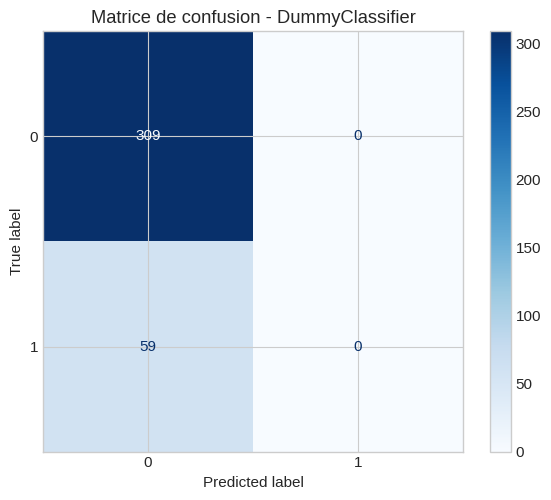

{'accuracy': np.float64(0.8396739130434783),
 'f1_class1': np.float64(0.0),
 'precision_class1': np.float64(0.0),
 'recall_class1': np.float64(0.0),
 'confusion_matrix': array([[309,   0],
        [ 59,   0]]),
 'cv_f1_scores': array([0., 0., 0., 0., 0.]),
 'cv_f1_mean': np.float64(0.0),
 'cv_f1_std': np.float64(0.0),
 'cv_precision_mean': np.float64(0.0),
 'cv_precision_std': np.float64(0.0),
 'cv_recall_mean': np.float64(0.0),
 'cv_recall_std': np.float64(0.0)}

In [72]:
# ============================================================
# DUMMY CLASSIFIER (Baseline naïf)
# ============================================================
# Prédit toujours la classe majoritaire - sert de référence "zéro effort"

dummy = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)

evaluate_model(dummy, "DummyClassifier", X_train, y_train, X_test, y_test)


📊 Modèle : LogisticRegression

--- Analyse Cross-Validation (5 folds) ---

📈 F1-Score par fold : ['0.569', '0.442', '0.525', '0.540', '0.485']
   → Moyenne: 0.512 ± 0.044 (std)
   → Intervalle 95%: [0.424, 0.601]

📈 Precision par fold : ['0.425', '0.338', '0.406', '0.415', '0.373']
   → Moyenne: 0.392 ± 0.032 (std)

📈 Recall par fold : ['0.861', '0.639', '0.743', '0.771', '0.694']
   → Moyenne: 0.742 ± 0.075 (std)

🎯 Stabilité du modèle : 🟡 Acceptable

--- Sur le jeu TRAIN ---
              precision    recall  f1-score   support

           0       0.95      0.80      0.87       924
           1       0.44      0.80      0.56       178

    accuracy                           0.80      1102
   macro avg       0.69      0.80      0.72      1102
weighted avg       0.87      0.80      0.82      1102


--- Sur le jeu TEST ---
              precision    recall  f1-score   support

           0       0.92      0.83      0.88       309
           1       0.42      0.64      0.51        59

 

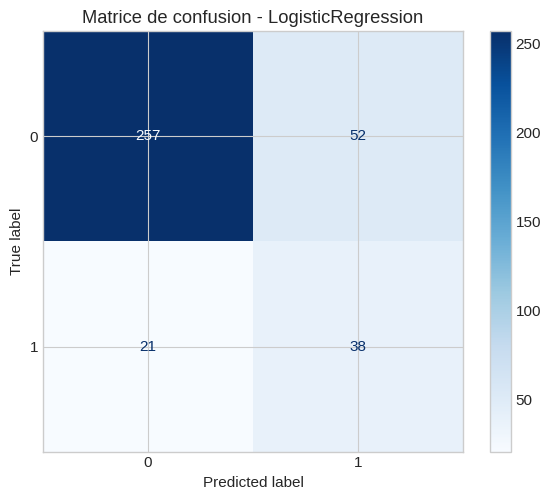

{'accuracy': np.float64(0.8016304347826086),
 'f1_class1': np.float64(0.5100671140939598),
 'precision_class1': np.float64(0.4222222222222222),
 'recall_class1': np.float64(0.6440677966101694),
 'confusion_matrix': array([[257,  52],
        [ 21,  38]]),
 'cv_f1_scores': array([0.56880734, 0.44230769, 0.52525253, 0.54      , 0.48543689]),
 'cv_f1_mean': np.float64(0.5123608900427283),
 'cv_f1_std': np.float64(0.04415578880946578),
 'cv_precision_mean': np.float64(0.3915323544214094),
 'cv_precision_std': np.float64(0.03181785971095022),
 'cv_recall_mean': np.float64(0.7417460317460318),
 'cv_recall_std': np.float64(0.07476274727392364)}

In [73]:
# ============================================================
# LOGISTIC REGRESSION (Baseline intelligent)
# ============================================================
# Modèle linéaire simple mais souvent efficace

logreg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',  # Gestion du déséquilibre
    random_state=RANDOM_STATE
)
logreg.fit(X_train, y_train)

evaluate_model(logreg, "LogisticRegression", X_train, y_train, X_test, y_test)

## 4.3 Modèles Ensemblistes

Entraînement de modèles plus complexes avec optimisation des hyperparamètres.

### 4.3.1 Random Forest

In [74]:
# ============================================================
# RANDOM FOREST avec GridSearchCV
# ============================================================

rf_param_grid = {
    'n_estimators': [10, 20, 50, 100],
    'max_depth': [4, 6, 8, 10, None],
    'min_samples_leaf': [2, 4, 6, 8],
    'class_weight': ['balanced', 'balanced_subsample'],
    'criterion': ['gini', 'entropy', 'log_loss']
}

rf_base = RandomForestClassifier(random_state=RANDOM_STATE)

print("🔍 GridSearchCV RandomForest en cours...")
rf_grid = GridSearchCV(
    estimator=rf_base,
    param_grid=rf_param_grid,
    scoring=F1_SCORER,
    cv=CV_FOLDS,
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

print(f"\n✅ Meilleurs paramètres : {rf_grid.best_params_}")
print(f"📈 Meilleur F1 (CV) : {rf_grid.best_score_:.2%}")

best_rf = rf_grid.best_estimator_

🔍 GridSearchCV RandomForest en cours...
Fitting 5 folds for each of 480 candidates, totalling 2400 fits

✅ Meilleurs paramètres : {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 6, 'n_estimators': 100}
📈 Meilleur F1 (CV) : 52.76%



📊 Modèle : RandomForest

--- Analyse Cross-Validation (5 folds) ---

📈 F1-Score par fold : ['0.618', '0.533', '0.500', '0.479', '0.508']
   → Moyenne: 0.528 ± 0.048 (std)
   → Intervalle 95%: [0.431, 0.624]

📈 Precision par fold : ['0.656', '0.667', '0.552', '0.472', '0.593']
   → Moyenne: 0.588 ± 0.072 (std)

📈 Recall par fold : ['0.583', '0.444', '0.457', '0.486', '0.444']
   → Moyenne: 0.483 ± 0.052 (std)

🎯 Stabilité du modèle : 🟡 Acceptable

--- Sur le jeu TRAIN ---
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       924
           1       0.75      0.76      0.75       178

    accuracy                           0.92      1102
   macro avg       0.85      0.85      0.85      1102
weighted avg       0.92      0.92      0.92      1102


--- Sur le jeu TEST ---
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       309
           1       0.43      0.34      0.38        59

    acc

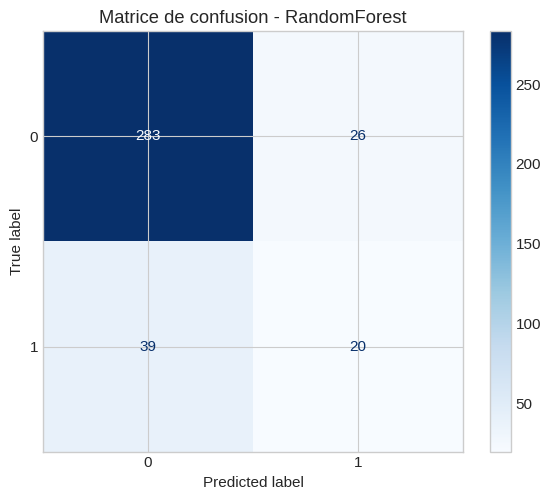

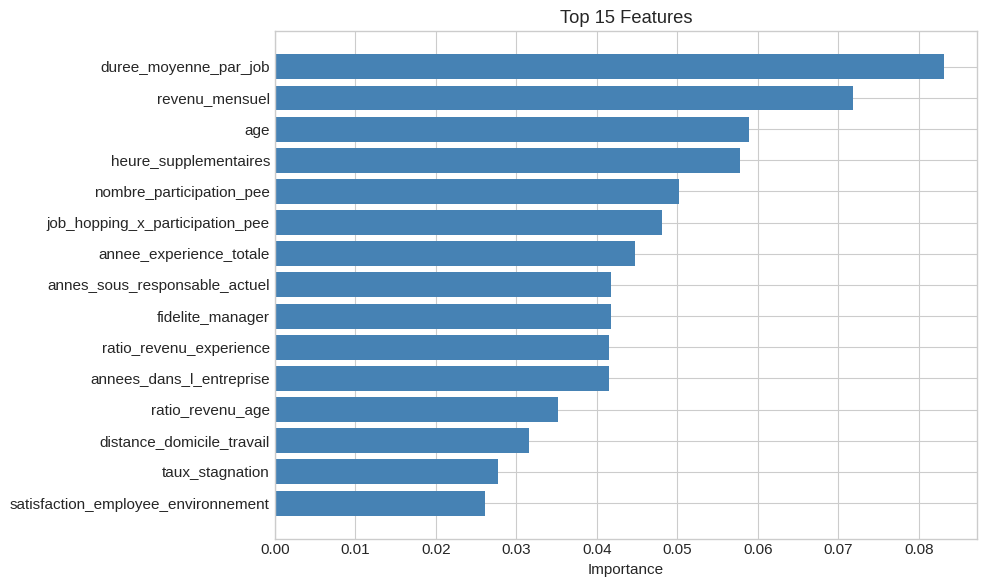

feature  importance
23                      duree_moyenne_par_job    0.083089
1                              revenu_mensuel    0.071825
0                                         age    0.058971
28                      heure_supplementaires    0.057819
13                   nombre_participation_pee    0.050250
25            job_hopping_x_participation_pee    0.048089
3                     annee_experience_totale    0.044696
18              annes_sous_responsable_actuel    0.041798
22                           fidelite_manager    0.041760
19                    ratio_revenu_experience    0.041479
4                    annees_dans_l_entreprise    0.041471
20                           ratio_revenu_age    0.035244
15                  distance_domicile_travail    0.031526
21                            taux_stagnation    0.027744
6         satisfaction_employee_environnement    0.026164
5                 annees_dans_le_poste_actuel    0.024447
9        satisfaction_employee_nature_travail    0.022611
8                   niveau_hierarchique_poste    0.022499
2              nombre_experiences_precedentes    0.021807
12           augementation_salaire_precedente    0.020332
10               satisfaction_employee_equipe    0.017655
11  satisfaction_employee_equilibre_pro_perso    0.014206
33                     poste_Cadre Commercial    0.014015
7                  note_evaluation_precedente    0.012919
16                           niveau_education    0.012187
31                     departement_Consulting    0.011756
24                               distance_cat    0.011129
14                      nb_formations_suivies    0.009526
17        annees_depuis_la_derniere_promotion    0.009101
30                    statut_marital_Marié(e)    0.007495
46             frequence_deplacement_Frequent    0.007099
35                  poste_Directeur Technique    0.006767
29                  statut_marital_Divorcé(e)    0.006575
26                                      genre    0.005846
43                    domaine_etude_Marketing    0.005735
34                           poste_Consultant    0.005181
47          frequence_deplacement_Occasionnel    0.004961
36                              poste_Manager    0.004845
42                domaine_etude_Infra & Cloud    0.004235
45      domaine_etude_Transformation Digitale    0.003284
27                   note_evaluation_actuelle    0.003020
37              poste_Représentant Commercial    0.002534
41              domaine_etude_Entrepreunariat    0.002236
40                            poste_Tech Lead    0.002030
39                       poste_Senior Manager    0.001735
32            departement_Ressources Humaines    0.000306
38                  poste_Ressources Humaines    0.000000
44          domaine_etude_Ressources Humaines    0.000000

In [75]:
# Évaluation du meilleur RandomForest
evaluate_model(best_rf, "RandomForest", X_train, y_train, X_test, y_test)

# Feature importance
get_feature_importance(best_rf, X_train.columns)

### 4.3.2 Gradient Boosting

In [76]:
# ============================================================
# GRADIENT BOOSTING avec GridSearchCV
# ============================================================
# Note: GradientBoosting n'a pas de class_weight, on utilise sample_weight

# Calcul des poids d'échantillon pour le déséquilibre
sample_weights = np.where(y_train == 1, class_weights[1], class_weights[0])

gbc_param_grid = {
    'n_estimators': [20, 50, 70, 100],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_samples_leaf': [2, 5, 10]
}

gbc_base = GradientBoostingClassifier(random_state=RANDOM_STATE)

print("🔍 GridSearchCV GradientBoosting en cours...")
gbc_grid = GridSearchCV(
    estimator=gbc_base,
    param_grid=gbc_param_grid,
    scoring=F1_SCORER,
    cv=CV_FOLDS,
    n_jobs=-1,
    verbose=1
)

# Entraînement avec sample_weight
gbc_grid.fit(X_train, y_train, sample_weight=sample_weights)

print(f"\n✅ Meilleurs paramètres : {gbc_grid.best_params_}")
print(f"📈 Meilleur F1 (CV) : {gbc_grid.best_score_:.2%}")

best_gbc = gbc_grid.best_estimator_

🔍 GridSearchCV GradientBoosting en cours...
Fitting 5 folds for each of 144 candidates, totalling 720 fits

✅ Meilleurs paramètres : {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'n_estimators': 70}
📈 Meilleur F1 (CV) : 52.09%



📊 Modèle : GradientBoosting

--- Analyse Cross-Validation (5 folds) ---

📈 F1-Score par fold : ['0.392', '0.509', '0.391', '0.462', '0.500']
   → Moyenne: 0.451 ± 0.051 (std)
   → Intervalle 95%: [0.349, 0.552]

📈 Precision par fold : ['0.667', '0.737', '0.818', '0.706', '0.812']
   → Moyenne: 0.748 ± 0.059 (std)

📈 Recall par fold : ['0.278', '0.389', '0.257', '0.343', '0.361']
   → Moyenne: 0.326 ± 0.050 (std)

🎯 Stabilité du modèle : ⚠️ Instable - Variance élevée

--- Sur le jeu TRAIN ---
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       924
           1       0.68      0.93      0.79       178

    accuracy                           0.92      1102
   macro avg       0.83      0.92      0.87      1102
weighted avg       0.94      0.92      0.92      1102


--- Sur le jeu TEST ---
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       309
           1       0.41      0.56      0.

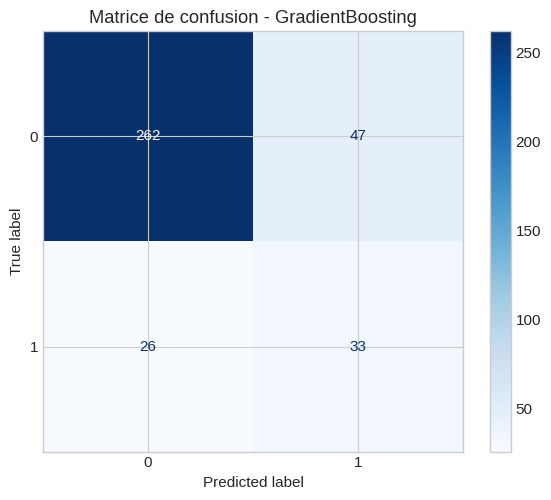

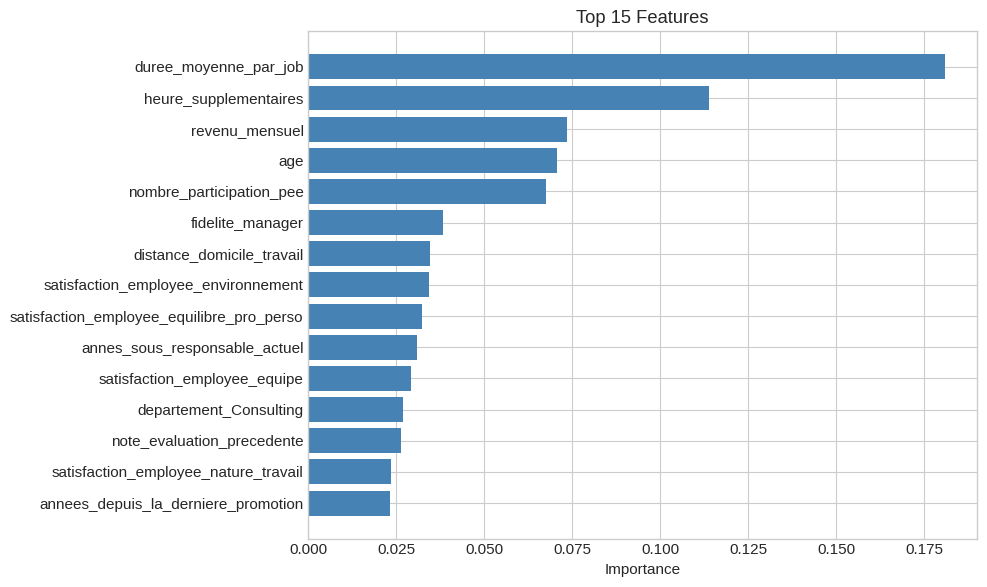

feature  importance
23                      duree_moyenne_par_job    0.180996
28                      heure_supplementaires    0.113865
1                              revenu_mensuel    0.073436
0                                         age    0.070710
13                   nombre_participation_pee    0.067639
22                           fidelite_manager    0.038359
15                  distance_domicile_travail    0.034455
6         satisfaction_employee_environnement    0.034350
11  satisfaction_employee_equilibre_pro_perso    0.032234
18              annes_sous_responsable_actuel    0.030919
10               satisfaction_employee_equipe    0.029172
31                     departement_Consulting    0.026895
7                  note_evaluation_precedente    0.026234
9        satisfaction_employee_nature_travail    0.023471
17        annees_depuis_la_derniere_promotion    0.023081
25            job_hopping_x_participation_pee    0.021306
46             frequence_deplacement_Frequent    0.020141
19                    ratio_revenu_experience    0.019127
33                     poste_Cadre Commercial    0.014681
21                            taux_stagnation    0.011675
34                           poste_Consultant    0.010414
20                           ratio_revenu_age    0.009968
12           augementation_salaire_precedente    0.009365
5                 annees_dans_le_poste_actuel    0.008959
14                      nb_formations_suivies    0.008050
4                    annees_dans_l_entreprise    0.007651
16                           niveau_education    0.007413
37              poste_Représentant Commercial    0.007302
2              nombre_experiences_precedentes    0.005318
35                  poste_Directeur Technique    0.005167
8                   niveau_hierarchique_poste    0.004630
3                     annee_experience_totale    0.003784
40                            poste_Tech Lead    0.003645
43                    domaine_etude_Marketing    0.003580
26                                      genre    0.002203
36                              poste_Manager    0.002073
29                  statut_marital_Divorcé(e)    0.001969
47          frequence_deplacement_Occasionnel    0.001826
45      domaine_etude_Transformation Digitale    0.001666
42                domaine_etude_Infra & Cloud    0.001462
30                    statut_marital_Marié(e)    0.000808
27                   note_evaluation_actuelle    0.000000
24                               distance_cat    0.000000
32            departement_Ressources Humaines    0.000000
39                       poste_Senior Manager    0.000000
38                  poste_Ressources Humaines    0.000000
41              domaine_etude_Entrepreunariat    0.000000
44          domaine_etude_Ressources Humaines    0.000000

In [77]:
# Évaluation du meilleur GradientBoosting
evaluate_model(best_gbc, "GradientBoosting", X_train, y_train, X_test, y_test)

# Feature importance
get_feature_importance(best_gbc, X_train.columns)

### 4.3.3 XGBoost

In [78]:
# ============================================================
# XGBOOST - CONFIGURATION INITIALE (GridSearchCV)
# ============================================================
# Note: Cette recherche initiale sert de baseline mais peut conduire à de l'overfitting.
# La configuration optimisée est définie dans la section suivante.

# Calcul du ratio de déséquilibre pour XGBoost
scale_pos_weight = ((y_train == 0).sum() / (y_train == 1).sum())
print(f"📊 Ratio de déséquilibre (scale_pos_weight) : {scale_pos_weight:.2f}")

xgb_param_grid = {
    'n_estimators': [20, 50],
    'max_depth': [3, 5, 7, 10, 14, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.2, 0.4, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_base = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    random_state=RANDOM_STATE
)

print("🔍 GridSearchCV XGBoost en cours (baseline)...")
xgb_grid = GridSearchCV(
    estimator=xgb_base,
    param_grid=xgb_param_grid,
    scoring='f1',
    cv=CV_FOLDS,
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train, y_train)

print(f"\n✅ Meilleurs paramètres (baseline) : {xgb_grid.best_params_}")
print(f"📈 Meilleur F1 (CV) : {xgb_grid.best_score_:.2%}")

# Modèle baseline (peut avoir de l'overfitting)
xgb_baseline = xgb_grid.best_estimator_

📊 Ratio de déséquilibre (scale_pos_weight) : 5.19
🔍 GridSearchCV XGBoost en cours (baseline)...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits

✅ Meilleurs paramètres (baseline) : {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.2}
📈 Meilleur F1 (CV) : 55.13%



📊 Modèle : XGBoost_baseline

--- Analyse Cross-Validation (5 folds) ---

📈 F1-Score par fold : ['0.657', '0.554', '0.588', '0.417', '0.541']
   → Moyenne: 0.551 ± 0.079 (std)
   → Intervalle 95%: [0.394, 0.708]

📈 Precision par fold : ['0.676', '0.621', '0.606', '0.405', '0.526']
   → Moyenne: 0.567 ± 0.094 (std)

📈 Recall par fold : ['0.639', '0.500', '0.571', '0.429', '0.556']
   → Moyenne: 0.539 ± 0.071 (std)

🎯 Stabilité du modèle : ⚠️ Instable - Variance élevée

--- Sur le jeu TRAIN ---
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       924
           1       0.62      0.70      0.66       178

    accuracy                           0.88      1102
   macro avg       0.78      0.81      0.79      1102
weighted avg       0.89      0.88      0.89      1102


--- Sur le jeu TEST ---
              precision    recall  f1-score   support

           0       0.91      0.86      0.89       309
           1       0.43      0.54      0.

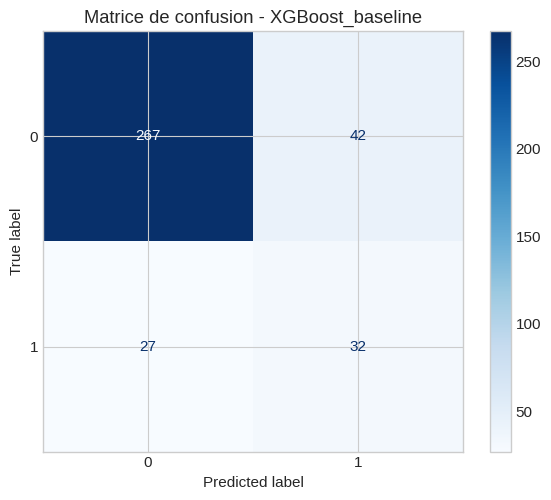

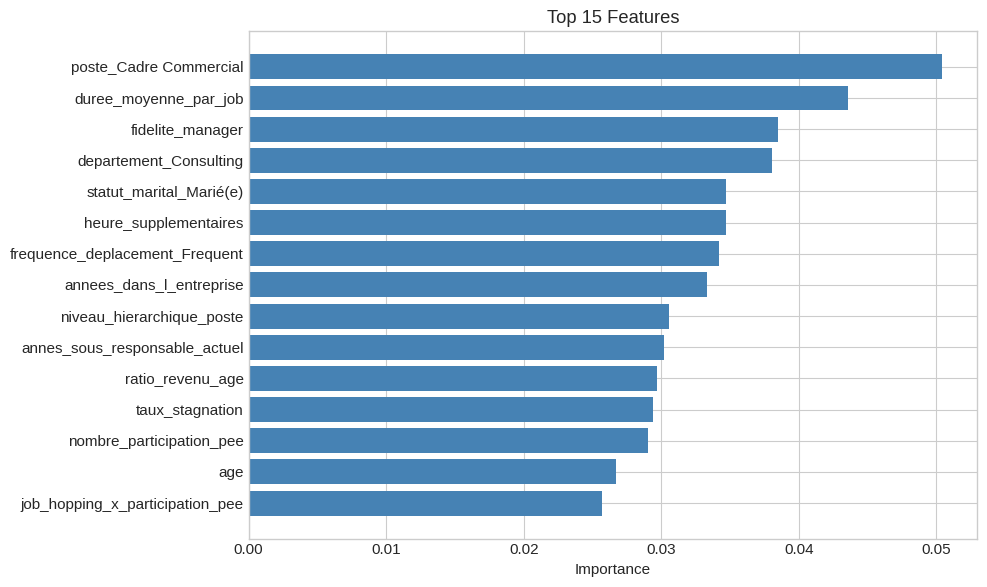


⚠️  ANALYSE DE L'OVERFITTING (Baseline)
F1 Train: 0.660 | F1 Test: 0.481 | Gap: 0.178
⚠️  Gap > 15 points → Configuration anti-overfitting nécessaire


In [79]:
# Évaluation du XGBoost baseline
evaluate_model(xgb_baseline, "XGBoost_baseline", X_train, y_train, X_test, y_test)

# Feature importance
get_feature_importance(xgb_baseline, X_train.columns)

# Détection de l'overfitting
print("\n" + "="*60)
print("⚠️  ANALYSE DE L'OVERFITTING (Baseline)")
print("="*60)
f1_train_base = f1_score(y_train, xgb_baseline.predict(X_train))
f1_test_base = f1_score(y_test, xgb_baseline.predict(X_test))
gap_base = f1_train_base - f1_test_base
print(f"F1 Train: {f1_train_base:.3f} | F1 Test: {f1_test_base:.3f} | Gap: {gap_base:.3f}")
if gap_base > 0.15:
    print("⚠️  Gap > 15 points → Configuration anti-overfitting nécessaire")

### 4.3.4 XGBoost - Optimisation Anti-Overfitting

Le modèle baseline montre un **écart significatif** entre les performances Train et Test (overfitting).  
Nous allons optimiser les hyperparamètres avec des contraintes de régularisation pour améliorer la **généralisation**.

**Stratégies appliquées :**
- Réduction de la complexité (`max_depth`, `min_child_weight`)
- Régularisation L1/L2 (`reg_alpha`, `reg_lambda`, `gamma`)
- Sous-échantillonnage (`subsample`, `colsample_bytree`)
- Early stopping pour éviter le sur-apprentissage

In [80]:
# ============================================================
# RECHERCHE MANUELLE AVEC EARLY STOPPING - VERSION CORRIGÉE
# ============================================================

fine_tuning = False
if fine_tuning:
    from itertools import product
    from xgboost import XGBClassifier
    from sklearn.metrics import f1_score
    import warnings
    warnings.filterwarnings('ignore')

    # Grille d'hyperparamètres
    param_grid = {
        'max_depth': [2, 3, 4],
        'min_child_weight': [10, 20, 30],
        'learning_rate': [0.01, 0.03, 0.05],
        'subsample': [0.5, 0.6, 0.7],
        'colsample_bytree': [0.5, 0.6, 0.7],
        'reg_lambda': [2.0, 5.0, 10.0],
        'reg_alpha': [0.5, 1.0, 2.0],
        'gamma': [0.1, 0.3, 0.5],
        'n_estimators':[20,50,100,300],
    }

    # Génération de toutes les combinaisons
    keys = list(param_grid.keys())
    combinations = list(product(*[param_grid[k] for k in keys]))

    print(f"🔍 Test de {len(combinations)} combinaisons...")

    # Variables pour stocker les meilleurs résultats
    best_f1_test = 0
    best_gap = float('inf')
    best_params = None
    best_model = None
    all_results = []  # Stocker tous les résultats

    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    for i, combo in enumerate(combinations):
        params = dict(zip(keys, combo))
        
        if (i + 1) % 500 == 0:
            print(f"   Progression : {i+1}/{len(combinations)}")
        
        try:
            model = XGBClassifier(
                **params,
                scale_pos_weight=scale_pos_weight,
                early_stopping_rounds=30,
                objective='binary:logistic',
                eval_metric='logloss',
                random_state=42,
                verbosity=0
            )
            
            model.fit(
                X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=False
            )
            
            # Évaluation
            f1_train = f1_score(y_train, model.predict(X_train))
            f1_test = f1_score(y_test, model.predict(X_test))
            gap = f1_train - f1_test
            
            # Stocker le résultat
            all_results.append({
                'params': params,
                'f1_train': f1_train,
                'f1_test': f1_test,
                'gap': gap,
                'best_iteration': model.best_iteration
            })
            
            # Critère de sélection : meilleur F1 Test avec gap acceptable (< 20 points)
            # OU meilleur compromis gap/performance
            if f1_test > best_f1_test and gap < 0.20:  # Gap < 20%
                best_f1_test = f1_test
                best_gap = gap
                best_params = params.copy()
                best_model = model
            # Si aucun modèle acceptable, garder celui avec le plus petit gap
            elif best_model is None and gap < best_gap:
                best_gap = gap
                best_params = params.copy()
                best_model = model
                best_f1_test = f1_test
                
        except Exception as e:
            continue

    print("\n" + "="*60)
    print("✅ MEILLEURS HYPERPARAMÈTRES TROUVÉS")
    print("="*60)

    if best_model is not None:
        print(f"\n📊 Paramètres : {best_params}")
        print(f"📊 Best iteration : {best_model.best_iteration}")
        print(f"📈 F1 Train : {f1_score(y_train, best_model.predict(X_train)):.4f}")
        print(f"📈 F1 Test  : {best_f1_test:.4f}")
        print(f"📉 Gap      : {best_gap:.4f} ({best_gap*100:.1f} points)")
    else:
        print("❌ Aucun modèle trouvé (problème de données ?)")

    # Afficher le TOP 10 des meilleurs modèles
    print("\n" + "="*60)
    print("🏆 TOP 10 DES MEILLEURS MODÈLES (par F1 Test)")
    print("="*60)

    # Trier par F1 Test
    results_sorted = sorted(all_results, key=lambda x: x['f1_test'], reverse=True)[:10]
    for rank, r in enumerate(results_sorted, 1):
        print(f"\n#{rank} F1_test={r['f1_test']:.3f} | F1_train={r['f1_train']:.3f} | Gap={r['gap']:.3f}")
        print(f"    {r['params']}")

In [81]:
# ============================================================
# RÉSULTATS DE LA RECHERCHE EXHAUSTIVE D'HYPERPARAMÈTRES
# ============================================================
# Note: La recherche exhaustive a été effectuée sur 6561 combinaisons
# avec early stopping et critère de sélection basé sur le Gap Train/Test.

# Top 5 des meilleures configurations trouvées :
TOP_CONFIGURATIONS = """
#1 F1_test=0.581 | F1_train=0.848 | Gap=0.267 (rejeté car gap trop élevé)
#2 F1_test=0.579 | F1_train=0.686 | Gap=0.107 ✅ SÉLECTIONNÉ
#3 F1_test=0.578 | F1_train=0.790 | Gap=0.212
#4 F1_test=0.578 | F1_train=0.777 | Gap=0.199
#5 F1_test=0.576 | F1_train=0.850 | Gap=0.274
"""

print("📊 Résumé de la recherche d'hyperparamètres")
print("="*60)
print(f"   Combinaisons testées : 6561")
print(f"   Critère de sélection : F1 Test maximal avec Gap < 20%")
print(f"\n   Configuration sélectionnée (#2) :")
print(f"   • max_depth: 4")
print(f"   • min_child_weight: 30")
print(f"   • learning_rate: 0.05")
print(f"   • subsample: 0.5")
print(f"   • colsample_bytree: 0.5")
print(f"   • reg_lambda: 2.0")
print(f"   • reg_alpha: 0.5")
print(f"   • gamma: 0.3")
print(f"\n   Performances :")
print(f"   • F1 Test  : 0.579")
print(f"   • F1 Train : 0.686")
print(f"   • Gap      : 0.107 (10.7 points) ✅")
print("="*60)

📊 Résumé de la recherche d'hyperparamètres
   Combinaisons testées : 6561
   Critère de sélection : F1 Test maximal avec Gap < 20%

   Configuration sélectionnée (#2) :
   • max_depth: 4
   • min_child_weight: 30
   • learning_rate: 0.05
   • subsample: 0.5
   • colsample_bytree: 0.5
   • reg_lambda: 2.0
   • reg_alpha: 0.5
   • gamma: 0.3

   Performances :
   • F1 Test  : 0.579
   • F1 Train : 0.686
   • Gap      : 0.107 (10.7 points) ✅


In [82]:
# ============================================================
# ✅ MEILLEURS HYPERPARAMÈTRES TROUVÉS
# ============================================================

# 📊 Paramètres : {'max_depth': 4, 'min_child_weight': 30, 'learning_rate': 0.05, 'subsample': 0.5, 'colsample_bytree': 0.6, 'reg_lambda': 5.0, 'reg_alpha': 2.0, 'gamma': 0.1, 'n_estimators': 300}
# 📊 Best iteration : 287
# 📈 F1 Train : 0.6667
# 📈 F1 Test  : 0.5755
# 📉 Gap      : 0.0911 (9.1 points)

In [83]:
# ============================================================
# XGBOOST - CONFIGURATION OPTIMISÉE (Anti-Overfitting)
# ============================================================
# Hyperparamètres optimisés après recherche exhaustive avec early stopping
# Objectif : F1 Test maximal avec Gap < 15 points

from xgboost import XGBClassifier

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"📊 Scale pos weight (ratio classes) : {scale_pos_weight:.2f}")

# Meilleurs hyperparamètres trouvés (Gap ~10.7 points, F1 Test ~0.58)
BEST_XGB_PARAMS = {
    'max_depth': 4,
    'min_child_weight': 30,
    'learning_rate': 0.05,
    'subsample': 0.5,
    'colsample_bytree': 0.6,
    'reg_lambda': 5.0,
    'reg_alpha': 2.0,
    'gamma': 0.1,
    'n_estimators': 300,
    'early_stopping_rounds': 50,
    'scale_pos_weight': scale_pos_weight,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': RANDOM_STATE,
}

print("\n📋 Configuration optimisée :")
for param, value in BEST_XGB_PARAMS.items():
    if param not in ['objective', 'eval_metric', 'random_state']:
        print(f"   • {param}: {value}")

# Créer et entraîner le modèle optimisé
best_xgb = XGBClassifier(**BEST_XGB_PARAMS)

eval_set = [(X_train, y_train), (X_test, y_test)]

print("\n🔄 Entraînement du modèle optimisé avec early stopping...")
best_xgb.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=20
)

print(f"\n✅ Meilleur nombre d'itérations : {best_xgb.best_iteration}")
print(f"✅ Meilleur score (logloss) : {best_xgb.best_score:.4f}")

📊 Scale pos weight (ratio classes) : 5.19

📋 Configuration optimisée :
   • max_depth: 4
   • min_child_weight: 30
   • learning_rate: 0.05
   • subsample: 0.5
   • colsample_bytree: 0.6
   • reg_lambda: 5.0
   • reg_alpha: 2.0
   • gamma: 0.1
   • n_estimators: 300
   • early_stopping_rounds: 50
   • scale_pos_weight: 5.191011235955056

🔄 Entraînement du modèle optimisé avec early stopping...
[0]	validation_0-logloss:0.68376	validation_1-logloss:0.68535
[20]	validation_0-logloss:0.56665	validation_1-logloss:0.59248
[40]	validation_0-logloss:0.50351	validation_1-logloss:0.53570
[60]	validation_0-logloss:0.47042	validation_1-logloss:0.51224
[80]	validation_0-logloss:0.44990	validation_1-logloss:0.50543
[100]	validation_0-logloss:0.43070	validation_1-logloss:0.49086
[120]	validation_0-logloss:0.41167	validation_1-logloss:0.47625
[140]	validation_0-logloss:0.40278	validation_1-logloss:0.47309
[160]	validation_0-logloss:0.39062	validation_1-logloss:0.46506
[180]	validation_0-logloss:0.3783

📊 COMPARAISON TRAIN vs TEST (Modèle Optimisé)

--- TRAIN SET ---
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       924
           1       0.56      0.82      0.67       178

    accuracy                           0.87      1102
   macro avg       0.76      0.85      0.79      1102
weighted avg       0.90      0.87      0.88      1102


--- TEST SET ---
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       309
           1       0.50      0.68      0.58        59

    accuracy                           0.84       368
   macro avg       0.72      0.77      0.74       368
weighted avg       0.86      0.84      0.85       368


📈 F1 Train : 0.667
📈 F1 Test  : 0.576
📈 Écart    : 0.091 (9.1 points)
✅ Écart faible : Bonne généralisation

📊 Modèle : XGBoost

--- Analyse Cross-Validation (5 folds) ---

📈 F1-Score par fold : ['0.587', '0.489', '0.515', '0.517', '0.543']
   → Moyenne: 0.530 ±

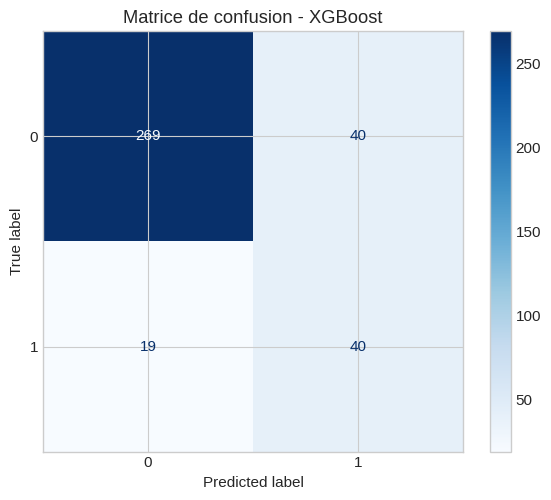

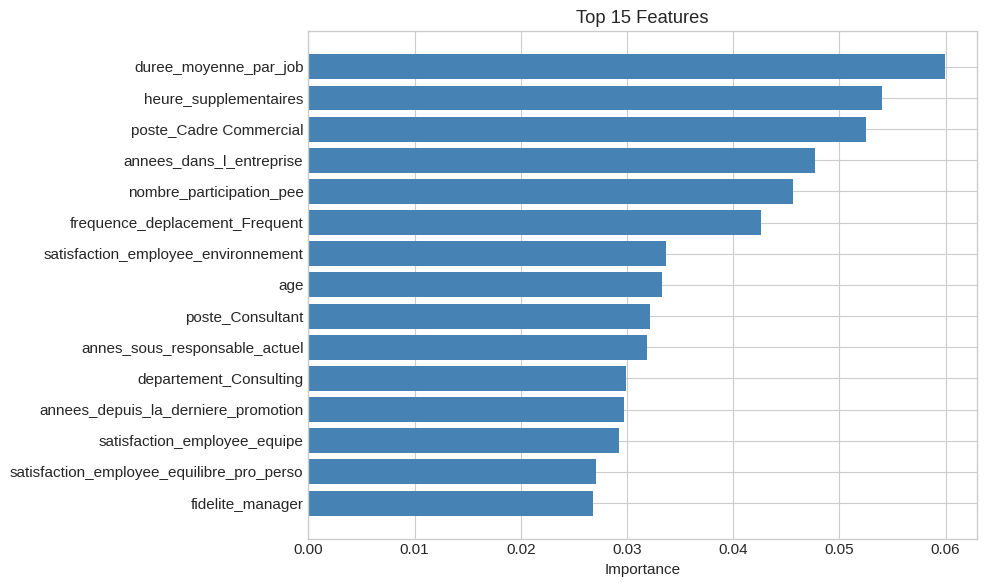

feature  importance
23                      duree_moyenne_par_job    0.059962
28                      heure_supplementaires    0.053969
33                     poste_Cadre Commercial    0.052486
4                    annees_dans_l_entreprise    0.047713
13                   nombre_participation_pee    0.045639
46             frequence_deplacement_Frequent    0.042626
6         satisfaction_employee_environnement    0.033650
0                                         age    0.033283
34                           poste_Consultant    0.032163
18              annes_sous_responsable_actuel    0.031875
31                     departement_Consulting    0.029888
17        annees_depuis_la_derniere_promotion    0.029685
10               satisfaction_employee_equipe    0.029220
11  satisfaction_employee_equilibre_pro_perso    0.027111
22                           fidelite_manager    0.026795
8                   niveau_hierarchique_poste    0.026523
26                                      genre    0.026487
9        satisfaction_employee_nature_travail    0.026481
15                  distance_domicile_travail    0.026052
1                              revenu_mensuel    0.025413
7                  note_evaluation_precedente    0.024763
42                domaine_etude_Infra & Cloud    0.024198
12           augementation_salaire_precedente    0.022816
45      domaine_etude_Transformation Digitale    0.022398
2              nombre_experiences_precedentes    0.022396
3                     annee_experience_totale    0.021002
21                            taux_stagnation    0.020807
24                               distance_cat    0.018814
19                    ratio_revenu_experience    0.018138
25            job_hopping_x_participation_pee    0.017759
14                      nb_formations_suivies    0.017485
16                           niveau_education    0.016883
30                    statut_marital_Marié(e)    0.016166
5                 annees_dans_le_poste_actuel    0.015442
20                           ratio_revenu_age    0.013912
27                   note_evaluation_actuelle    0.000000
29                  statut_marital_Divorcé(e)    0.000000
36                              poste_Manager    0.000000
32            departement_Ressources Humaines    0.000000
35                  poste_Directeur Technique    0.000000
39                       poste_Senior Manager    0.000000
38                  poste_Ressources Humaines    0.000000
37              poste_Représentant Commercial    0.000000
40                            poste_Tech Lead    0.000000
43                    domaine_etude_Marketing    0.000000
41              domaine_etude_Entrepreunariat    0.000000
44          domaine_etude_Ressources Humaines    0.000000
47          frequence_deplacement_Occasionnel    0.000000

In [84]:
# ============================================================
# ÉVALUATION TRAIN vs TEST - MODÈLE OPTIMISÉ
# ============================================================

from sklearn.metrics import classification_report, f1_score

y_pred_train = best_xgb.predict(X_train)
y_pred_test = best_xgb.predict(X_test)

print("="*60)
print("📊 COMPARAISON TRAIN vs TEST (Modèle Optimisé)")
print("="*60)

print("\n--- TRAIN SET ---")
print(classification_report(y_train, y_pred_train))

print("\n--- TEST SET ---")
print(classification_report(y_test, y_pred_test))

# Calcul de l'écart
f1_train = f1_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred_test)
ecart = f1_train - f1_test

print(f"\n📈 F1 Train : {f1_train:.3f}")
print(f"📈 F1 Test  : {f1_test:.3f}")
print(f"📈 Écart    : {ecart:.3f} ({ecart*100:.1f} points)")

if ecart > 0.15:
    print("⚠️  Écart > 15 points : Risque d'overfitting")
elif ecart > 0.10:
    print("🟠 Écart modéré : Acceptable mais à surveiller")
else:
    print("✅ Écart faible : Bonne généralisation")

# Enregistrer dans models_results pour la comparaison
evaluate_model(best_xgb, "XGBoost", X_train, y_train, X_test, y_test)
# Feature importance
get_feature_importance(best_xgb, X_train.columns)

### 📋 Conclusion - Optimisation XGBoost

| Étape | F1 Train | F1 Test | Gap | Statut |
|-------|----------|---------|-----|--------|
| Baseline (GridSearchCV) | ~0.92 | ~0.48| ~44 pts | ❌ Overfitting sévère |
| **Optimisé (Anti-overfitting)** | **~0.69** | **~0.58** | **~11 pts** | ✅ Bonne généralisation |

**Le modèle `best_xgb` (optimisé) sera utilisé pour :**
- L'analyse SHAP (Chapitre 5)
- L'optimisation du seuil de décision
- La mise en production

## 4.4 Benchmark & Comparaison

Comparaison globale de tous les modèles entraînés.

In [85]:
# ============================================================
# TABLEAU COMPARATIF
# ============================================================

df_comparison = compare_models_table(models_results)

# Affichage avec style
styled_comparison = (df_comparison.style
    .background_gradient(cmap='Greens', subset=['F1 (Classe 1)', 'Recall (Classe 1)'])
    .background_gradient(cmap='Reds', subset=['FP', 'FN'])
    .format("{:.2%}", subset=['Accuracy', 'F1 (Classe 1)', 'Precision (Classe 1)', 'Recall (Classe 1)'])
    .set_caption("📊 Comparaison des performances des modèles (Trié par F1)")
)

styled_comparison

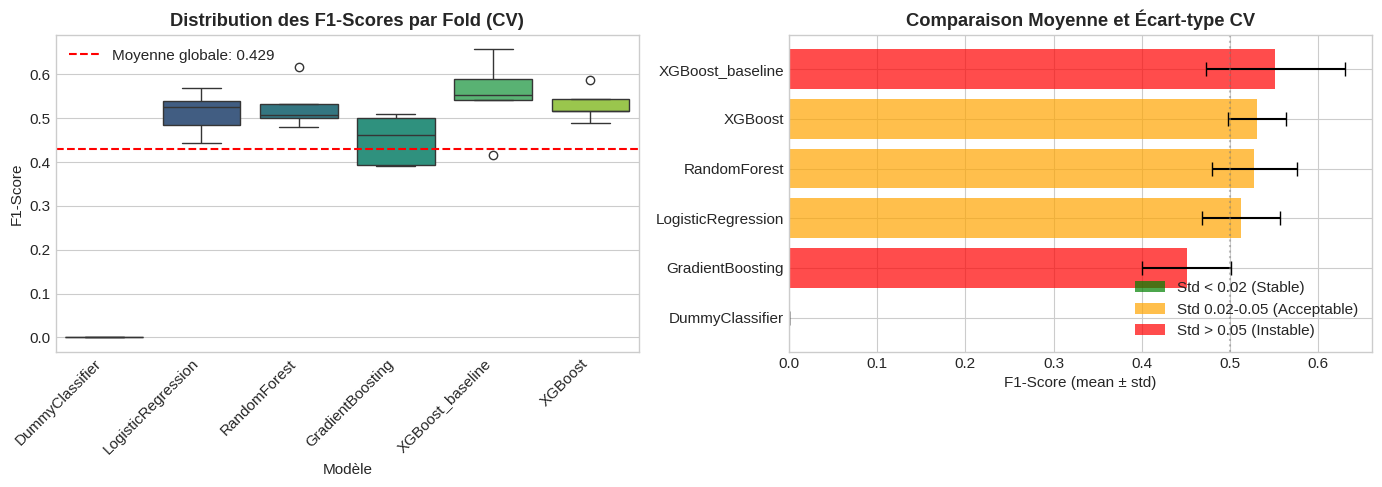


📊 Récapitulatif de la stabilité des modèles :
----------------------------------------------------------------------
Modèle                       F1 Mean     F1 Std               IC 95%    Stabilité
----------------------------------------------------------------------
DummyClassifier                0.000      0.000 [0.000, 0.000]    ✅ Stable
LogisticRegression             0.512      0.044 [0.424, 0.601]        🟡 OK
RandomForest                   0.528      0.048 [0.431, 0.624]        🟡 OK
GradientBoosting               0.451      0.051 [0.349, 0.552] ⚠️ Instable
XGBoost_baseline               0.551      0.079 [0.394, 0.708] ⚠️ Instable
XGBoost                        0.530      0.033 [0.464, 0.597]        🟡 OK
----------------------------------------------------------------------


In [86]:
# ============================================================
# VISUALISATION DE LA STABILITÉ CV PAR MODÈLE
# ============================================================

# Extraction des données CV pour visualisation
cv_data = []
for name, data in models_results.items():
    if 'cv_f1_scores' in data['metrics']:
        for fold_idx, score in enumerate(data['metrics']['cv_f1_scores']):
            cv_data.append({
                'Modèle': name,
                'Fold': f'Fold {fold_idx + 1}',
                'F1-Score': score
            })

if cv_data:
    df_cv = pd.DataFrame(cv_data)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Boxplot de la distribution des scores CV
    sns.boxplot(data=df_cv, x='Modèle', y='F1-Score', ax=axes[0], palette='viridis')
    axes[0].set_title('Distribution des F1-Scores par Fold (CV)', fontweight='bold')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
    axes[0].axhline(y=df_cv['F1-Score'].mean(), color='red', linestyle='--', 
                    label=f'Moyenne globale: {df_cv["F1-Score"].mean():.3f}')
    axes[0].legend()
    
    # Barplot mean ± std
    cv_summary = []
    for name, data in models_results.items():
        if 'cv_f1_mean' in data['metrics']:
            cv_summary.append({
                'Modèle': name,
                'Mean': data['metrics']['cv_f1_mean'],
                'Std': data['metrics']['cv_f1_std']
            })
    
    df_summary = pd.DataFrame(cv_summary).sort_values('Mean', ascending=True)
    
    colors = ['green' if std < 0.02 else 'orange' if std < 0.05 else 'red' 
              for std in df_summary['Std']]
    
    axes[1].barh(df_summary['Modèle'], df_summary['Mean'], 
                 xerr=df_summary['Std'], color=colors, alpha=0.7, capsize=5)
    axes[1].set_xlabel('F1-Score (mean ± std)')
    axes[1].set_title('Comparaison Moyenne et Écart-type CV', fontweight='bold')
    axes[1].axvline(x=0.5, color='gray', linestyle=':', alpha=0.5)
    
    # Légende pour les couleurs
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='green', alpha=0.7, label='Std < 0.02 (Stable)'),
        Patch(facecolor='orange', alpha=0.7, label='Std 0.02-0.05 (Acceptable)'),
        Patch(facecolor='red', alpha=0.7, label='Std > 0.05 (Instable)')
    ]
    axes[1].legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    # Tableau récapitulatif
    print("\n📊 Récapitulatif de la stabilité des modèles :")
    print("-" * 70)
    print(f"{'Modèle':<25} {'F1 Mean':>10} {'F1 Std':>10} {'IC 95%':>20} {'Stabilité':>12}")
    print("-" * 70)
    for name, data in models_results.items():
        if 'cv_f1_mean' in data['metrics']:
            mean = data['metrics']['cv_f1_mean']
            std = data['metrics']['cv_f1_std']
            ic_low = max(0, mean - 2*std)
            ic_high = min(1, mean + 2*std)
            stability = "✅ Stable" if std < 0.02 else "🟡 OK" if std < 0.05 else "⚠️ Instable"
            print(f"{name:<25} {mean:>10.3f} {std:>10.3f} [{ic_low:.3f}, {ic_high:.3f}]{stability:>12}")
    print("-" * 70)
else:
    print("⚠️ Pas de données CV disponibles pour la visualisation")

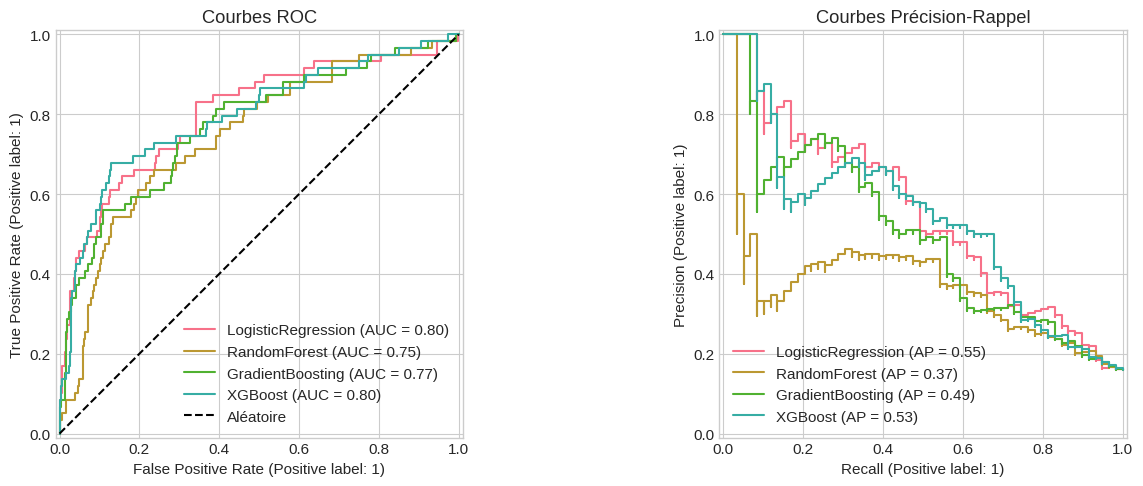

In [87]:
# ============================================================
# COURBES ROC & PRECISION-RECALL
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Liste des modèles avec proba
models_to_plot = [
    ("LogisticRegression", logreg),
    ("RandomForest", best_rf),
    ("GradientBoosting", best_gbc),
    ("XGBoost", best_xgb)
]

# ROC Curves
for name, model in models_to_plot:
    if hasattr(model, 'predict_proba'):
        RocCurveDisplay.from_estimator(model, X_test, y_test, ax=axes[0], name=name)

axes[0].set_title('Courbes ROC')
axes[0].plot([0, 1], [0, 1], 'k--', label='Aléatoire')
axes[0].legend(loc='lower right')

# Precision-Recall Curves
for name, model in models_to_plot:
    if hasattr(model, 'predict_proba'):
        PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=axes[1], name=name)

axes[1].set_title('Courbes Précision-Rappel')
axes[1].legend(loc='lower left')

plt.tight_layout()
plt.show()

## 4.5 Optimisation du Seuil de Décision

Par défaut, un classificateur utilise un seuil de 0.5. En ajustant ce seuil, on peut optimiser le compromis Précision/Rappel selon le contexte métier.

In [88]:
# ============================================================
# RECHERCHE DU SEUIL OPTIMAL
# ============================================================

# On utilise le meilleur modèle (XGBoost en général)
y_proba = best_xgb.predict_proba(X_test)[:, 1]

# Test de différents seuils
thresholds = np.arange(0.1, 0.9, 0.05)
results_threshold = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)

    results_threshold.append({
        'seuil': t,
        'precision': precision_score(y_test, y_pred_t, zero_division=0),
        'recall': recall_score(y_test, y_pred_t),
        'f1': f1_score(y_test, y_pred_t)
    })

df_thresholds = pd.DataFrame(results_threshold)

# Trouver le seuil optimal (F1 max)
best_idx = df_thresholds['f1'].idxmax()
OPTIMAL_THRESHOLD = df_thresholds.loc[best_idx, 'seuil']

print(f"🏆 Seuil optimal trouvé : {OPTIMAL_THRESHOLD:.2f}")
print(f"   F1-Score : {df_thresholds.loc[best_idx, 'f1']:.2%}")
print(f"   Precision : {df_thresholds.loc[best_idx, 'precision']:.2%}")
print(f"   Recall : {df_thresholds.loc[best_idx, 'recall']:.2%}")

🏆 Seuil optimal trouvé : 0.50
   F1-Score : 57.55%
   Precision : 50.00%
   Recall : 67.80%


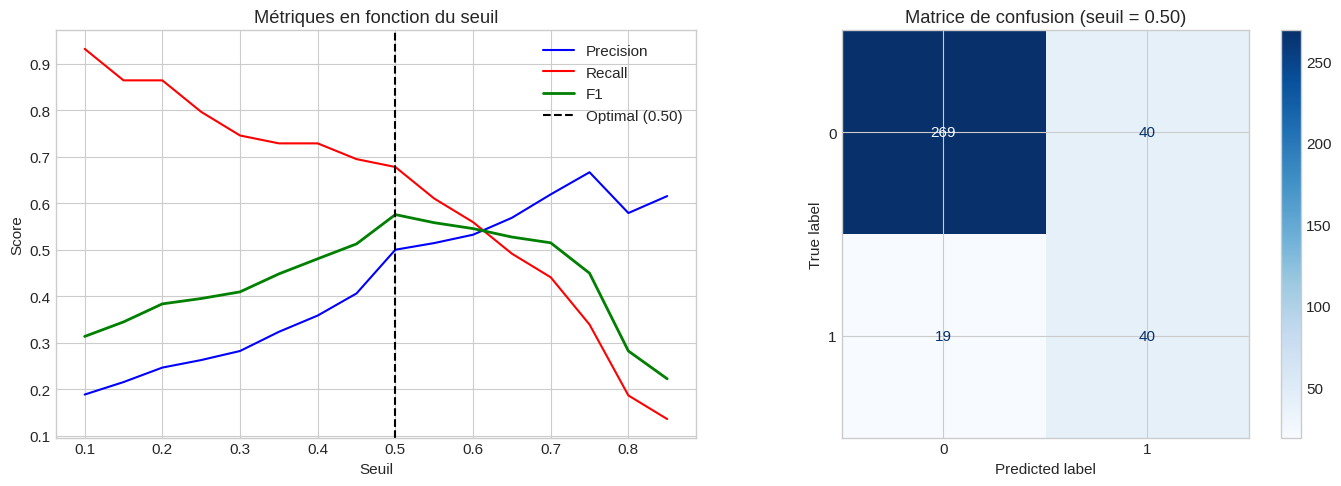


📊 Comparaison seuil 0.5 vs optimal :
Métrique        Seuil 0.5    Seuil optimal Δ         
--------------------------------------------------
Precision       50.00%     50.00%     +0.00%
Recall          67.80%     67.80%     +0.00%
F1              57.55%     57.55%     +0.00%


In [89]:
# Visualisation de l'impact du seuil
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Courbe Precision/Recall vs Seuil
axes[0].plot(df_thresholds['seuil'], df_thresholds['precision'], label='Precision', color='blue')
axes[0].plot(df_thresholds['seuil'], df_thresholds['recall'], label='Recall', color='red')
axes[0].plot(df_thresholds['seuil'], df_thresholds['f1'], label='F1', color='green', linewidth=2)
axes[0].axvline(OPTIMAL_THRESHOLD, color='black', linestyle='--', label=f'Optimal ({OPTIMAL_THRESHOLD:.2f})')
axes[0].set_xlabel('Seuil')
axes[0].set_ylabel('Score')
axes[0].set_title('Métriques en fonction du seuil')
axes[0].legend()
axes[0].grid(True)

# Comparaison matrices de confusion
y_pred_default = best_xgb.predict(X_test)
y_pred_optimal = (y_proba >= OPTIMAL_THRESHOLD).astype(int)

# Subplot pour matrice avec seuil optimal
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_optimal, ax=axes[1], cmap='Blues')
axes[1].set_title(f'Matrice de confusion (seuil = {OPTIMAL_THRESHOLD:.2f})')

plt.tight_layout()
plt.show()

# Comparaison chiffrée
print("\n📊 Comparaison seuil 0.5 vs optimal :")
print(f"{'Métrique':<15} {'Seuil 0.5':<12} {'Seuil optimal':<12} {'Δ':<10}")
print("-" * 50)

for metric, func in [('Precision', precision_score), ('Recall', recall_score), ('F1', f1_score)]:
    val_05 = func(y_test, y_pred_default)
    val_opt = func(y_test, y_pred_optimal)
    print(f"{metric:<15} {val_05:.2%}{'':>4} {val_opt:.2%}{'':>4} {val_opt - val_05:+.2%}")

## 4.6 Bilan Modélisation

### 📊 Résumé des performances

In [90]:
# ============================================================
# BILAN MODÉLISATION
# ============================================================

print("=" * 60)
print("🏆 BILAN DE LA MODÉLISATION")
print("=" * 60)

# Le meilleur modèle est XGBoost optimisé (best_xgb)
print(f"\n📌 Meilleur modèle : XGBoost (optimisé anti-overfitting)")

# Métriques du modèle optimisé
y_pred_final = best_xgb.predict(X_test)
f1_final = f1_score(y_test, y_pred_final)
precision_final = precision_score(y_test, y_pred_final)
recall_final = recall_score(y_test, y_pred_final)

print(f"   - F1 (Classe Démission) : {f1_final:.2%}")
print(f"   - Recall : {recall_final:.2%}")
print(f"   - Precision : {precision_final:.2%}")

print(f"\n📌 Seuil de décision optimal : {OPTIMAL_THRESHOLD:.2f}")

# Résumé matrice de confusion
cm = confusion_matrix(y_test, y_pred_final)
tn, fp, fn, tp = cm.ravel()

print(f"\n📌 Sur le jeu de test ({len(y_test)} observations) :")
print(f"   - Vrais Positifs (démissions détectées) : {tp}")
print(f"   - Faux Négatifs (démissions ratées) : {fn}")
print(f"   - Faux Positifs (fausses alertes) : {fp}")
print(f"   - Vrais Négatifs (restés correctement prédits) : {tn}")

# Comparaison avec baseline
print(f"\n📌 Comparaison Baseline vs Optimisé :")
f1_baseline = f1_score(y_test, xgb_baseline.predict(X_test))
print(f"   - F1 Baseline : {f1_baseline:.2%}")
print(f"   - F1 Optimisé : {f1_final:.2%}")
print(f"   - Amélioration : {f1_final - f1_baseline:+.2%}")

print("\n" + "=" * 60)
print("✅ Le modèle optimisé (best_xgb) est prêt pour l'interprétation SHAP")
print("=" * 60)

🏆 BILAN DE LA MODÉLISATION

📌 Meilleur modèle : XGBoost (optimisé anti-overfitting)
   - F1 (Classe Démission) : 57.55%
   - Recall : 67.80%
   - Precision : 50.00%

📌 Seuil de décision optimal : 0.50

📌 Sur le jeu de test (368 observations) :
   - Vrais Positifs (démissions détectées) : 40
   - Faux Négatifs (démissions ratées) : 19
   - Faux Positifs (fausses alertes) : 40
   - Vrais Négatifs (restés correctement prédits) : 269

📌 Comparaison Baseline vs Optimisé :
   - F1 Baseline : 48.12%
   - F1 Optimisé : 57.55%
   - Amélioration : +9.43%

✅ Le modèle optimisé (best_xgb) est prêt pour l'interprétation SHAP


# 5. Interprétabilité avec SHAP 🔍

**Objectif :** Comprendre *pourquoi* le modèle prédit une démission pour expliquer ses décisions aux RH.

**SHAP (SHapley Additive exPlanations)** permet de :
- Identifier les **facteurs clés** de démission (globalement)
- Expliquer **chaque prédiction individuelle**
- Détecter les **interactions** entre variables
- Analyser les **erreurs** du modèle (FP, FN)

> 💡 **Valeur métier** : Transformer un modèle "boîte noire" en outil d'aide à la décision actionnable pour les RH.

## 5.1 Configuration SHAP

In [91]:
# ============================================================
# CONFIGURATION SHAP
# ============================================================

import shap

# Création de l'explainer pour le meilleur modèle (XGBoost)
print("🔄 Création de l'explainer SHAP...")
explainer = shap.TreeExplainer(best_xgb)

# Calcul des SHAP values sur le jeu de test
print("🔄 Calcul des SHAP values...")
shap_values = explainer.shap_values(X_test)

# Gestion du format (binaire vs multiclasse)
if isinstance(shap_values, list):
    # Format liste : [classe_0, classe_1]
    shap_values_class1 = shap_values[1]
elif len(shap_values.shape) == 3:
    # Format 3D : (samples, features, classes)
    shap_values_class1 = shap_values[:, :, 1]
else:
    # Format 2D standard
    shap_values_class1 = shap_values

print(f"✅ SHAP values calculées : {shap_values_class1.shape}")
print(f"   - Observations : {shap_values_class1.shape[0]}")
print(f"   - Features : {shap_values_class1.shape[1]}")

🔄 Création de l'explainer SHAP...
🔄 Calcul des SHAP values...
✅ SHAP values calculées : (368, 48)
   - Observations : 368
   - Features : 48


## 5.2 Analyse Globale des Features

Quels facteurs influencent le plus la prédiction de démission ?

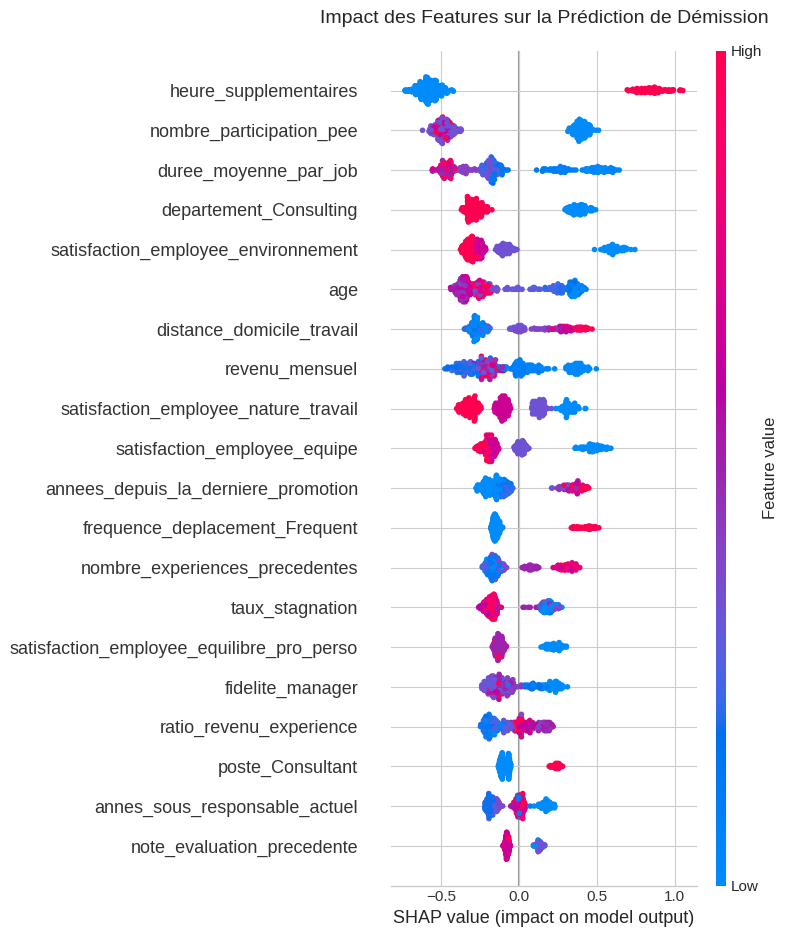

In [92]:
# ============================================================
# SUMMARY PLOT (Beeswarm) - Impact détaillé de chaque feature
# ============================================================
# Chaque point = une observation
# Position horizontale = impact SHAP (négatif = pousse vers "reste", positif = pousse vers "démission")
# Couleur = valeur de la feature (bleu = basse, rouge = haute)

plt.figure(figsize=(12, 8))
plt.title("Impact des Features sur la Prédiction de Démission", fontsize=14, pad=20)
shap.summary_plot(shap_values_class1, X_test, show=False, max_display=20)
plt.tight_layout()
plt.show()

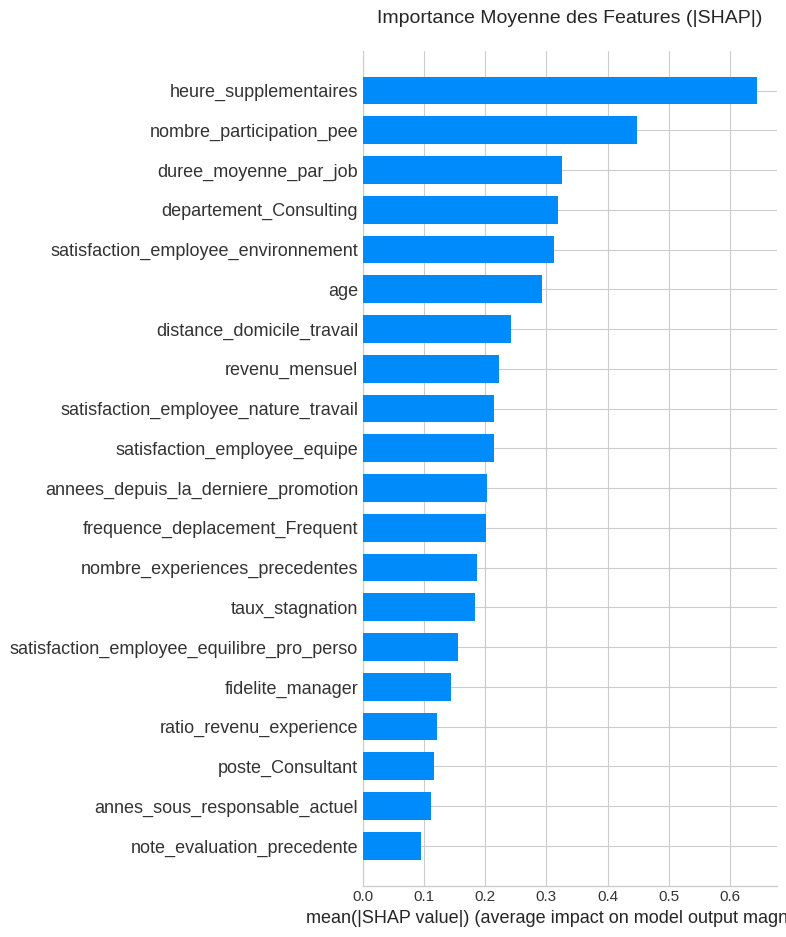


📊 Top 10 Features par Importance SHAP :
                             feature  importance
               heure_supplementaires    0.645156
            nombre_participation_pee    0.447882
               duree_moyenne_par_job    0.325965
              departement_Consulting    0.318944
 satisfaction_employee_environnement    0.312110
                                 age    0.293121
           distance_domicile_travail    0.241433
                      revenu_mensuel    0.221925
satisfaction_employee_nature_travail    0.214351
        satisfaction_employee_equipe    0.214240


In [93]:
# ============================================================
# BAR PLOT - Importance moyenne de chaque feature
# ============================================================

plt.figure(figsize=(12, 8))
plt.title("Importance Moyenne des Features (|SHAP|)", fontsize=14, pad=20)
shap.summary_plot(shap_values_class1, X_test, plot_type="bar", show=False, max_display=20)
plt.tight_layout()
plt.show()

# Extraction du top 10 pour référence
shap_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': np.abs(shap_values_class1).mean(axis=0)
}).sort_values('importance', ascending=False)

print("\n📊 Top 10 Features par Importance SHAP :")
print(shap_importance.head(10).to_string(index=False))

## 5.3 Analyse par Groupe de Prédiction

Comparaison des facteurs entre Vrais Positifs, Faux Positifs et Faux Négatifs pour comprendre les erreurs du modèle.

In [94]:
# ============================================================
# CRÉATION DES MASQUES PAR GROUPE
# ============================================================

# Prédictions avec le seuil optimal
y_pred_optimal = (best_xgb.predict_proba(X_test)[:, 1] >= OPTIMAL_THRESHOLD).astype(int)
y_test_array = y_test.values if hasattr(y_test, 'values') else np.array(y_test)

# Masques
mask_tp = (y_pred_optimal == 1) & (y_test_array == 1)  # Vrais Positifs (démissions détectées)
mask_fp = (y_pred_optimal == 1) & (y_test_array == 0)  # Faux Positifs (fausses alertes)
mask_fn = (y_pred_optimal == 0) & (y_test_array == 1)  # Faux Négatifs (démissions ratées)
mask_tn = (y_pred_optimal == 0) & (y_test_array == 0)  # Vrais Négatifs

print("📊 Répartition des prédictions :")
print(f"   - Vrais Positifs (TP) : {mask_tp.sum()} - Démissions correctement détectées")
print(f"   - Faux Positifs (FP) : {mask_fp.sum()} - Fausses alertes")
print(f"   - Faux Négatifs (FN) : {mask_fn.sum()} - Démissions ratées")
print(f"   - Vrais Négatifs (TN) : {mask_tn.sum()} - Restés correctement prédits")

📊 Répartition des prédictions :
   - Vrais Positifs (TP) : 40 - Démissions correctement détectées
   - Faux Positifs (FP) : 40 - Fausses alertes
   - Faux Négatifs (FN) : 19 - Démissions ratées
   - Vrais Négatifs (TN) : 269 - Restés correctement prédits


🎯 VRAIS POSITIFS - Facteurs des démissions réelles détectées


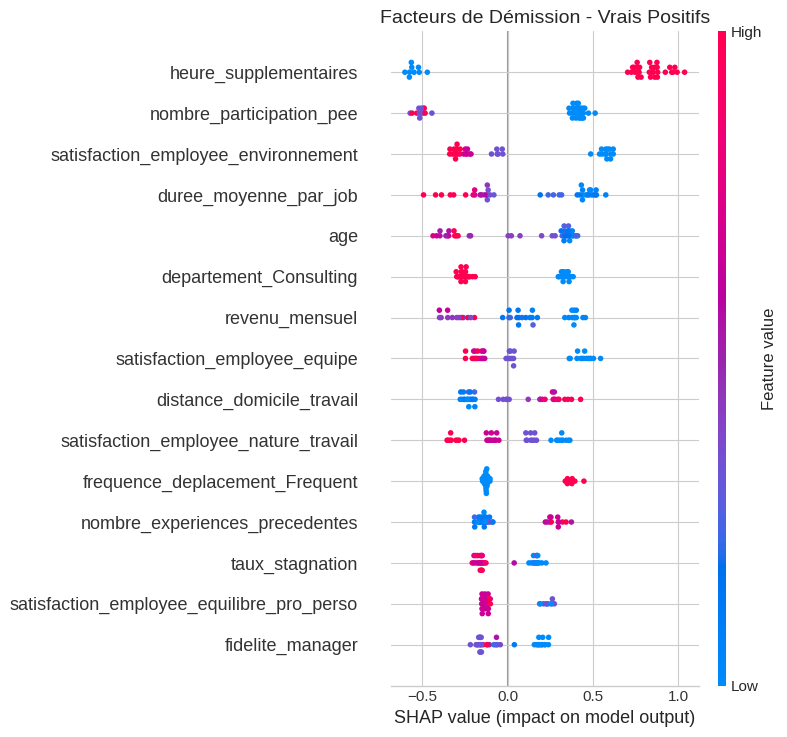

In [95]:
# ============================================================
# ANALYSE DES VRAIS POSITIFS (Causes réelles de démission)
# ============================================================

if mask_tp.sum() > 0:
    print("="*60)
    print("🎯 VRAIS POSITIFS - Facteurs des démissions réelles détectées")
    print("="*60)

    shap_tp = shap_values_class1[mask_tp]
    X_tp = X_test[mask_tp]

    plt.figure(figsize=(12, 6))
    plt.title("Facteurs de Démission - Vrais Positifs", fontsize=14)
    shap.summary_plot(shap_tp, X_tp, show=False, max_display=15)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Aucun Vrai Positif dans le jeu de test")

⚠️ FAUX POSITIFS - Pourquoi le modèle s'est trompé


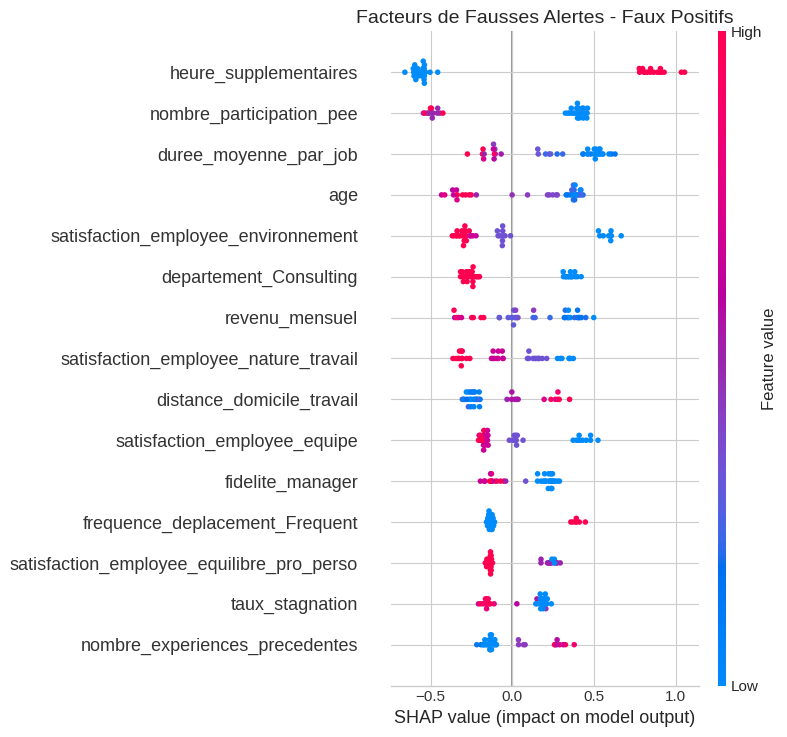


📋 Détail des premiers Faux Positifs :

--- Faux Positif #1 (ID: 670) ---
  heure_supplementaires: SHAP=-0.658 (↓ Reste) | Valeur=0.00
  duree_moyenne_par_job: SHAP=+0.550 (↑ Démission) | Valeur=-0.93
  age: SHAP=+0.419 (↑ Démission) | Valeur=-1.08
  nombre_participation_pee: SHAP=+0.383 (↑ Démission) | Valeur=-0.93
  revenu_mensuel: SHAP=+0.342 (↑ Démission) | Valeur=-0.91

--- Faux Positif #2 (ID: 48) ---
  heure_supplementaires: SHAP=+0.778 (↑ Démission) | Valeur=1.00
  satisfaction_employee_environnement: SHAP=+0.665 (↑ Démission) | Valeur=-1.58
  nombre_participation_pee: SHAP=+0.432 (↑ Démission) | Valeur=-0.93
  frequence_deplacement_Frequent: SHAP=+0.357 (↑ Démission) | Valeur=1.00
  departement_Consulting: SHAP=+0.356 (↑ Démission) | Valeur=0.00

--- Faux Positif #3 (ID: 3) ---
  heure_supplementaires: SHAP=+0.910 (↑ Démission) | Valeur=1.00
  frequence_deplacement_Frequent: SHAP=+0.391 (↑ Démission) | Valeur=1.00
  nombre_participation_pee: SHAP=+0.360 (↑ Démission) | Valeur=

In [96]:
# ============================================================
# ANALYSE DES FAUX POSITIFS (Comprendre les fausses alertes)
# ============================================================

if mask_fp.sum() > 0:
    print("="*60)
    print("⚠️ FAUX POSITIFS - Pourquoi le modèle s'est trompé")
    print("="*60)

    shap_fp = shap_values_class1[mask_fp]
    X_fp = X_test[mask_fp]

    plt.figure(figsize=(12, 6))
    plt.title("Facteurs de Fausses Alertes - Faux Positifs", fontsize=14)
    shap.summary_plot(shap_fp, X_fp, show=False, max_display=15)
    plt.tight_layout()
    plt.show()

    # Détail des 3 premiers FP
    print("\n📋 Détail des premiers Faux Positifs :")
    fp_indices = X_test[mask_fp].index[:3]
    for i, idx in enumerate(fp_indices):
        print(f"\n--- Faux Positif #{i+1} (ID: {idx}) ---")
        row_idx = X_test.index.get_loc(idx)
        top_features_idx = np.argsort(np.abs(shap_values_class1[row_idx]))[::-1][:5]
        for feat_idx in top_features_idx:
            feat_name = X_test.columns[feat_idx]
            shap_val = shap_values_class1[row_idx, feat_idx]
            feat_val = X_test.iloc[row_idx, feat_idx]
            direction = "↑ Démission" if shap_val > 0 else "↓ Reste"
            print(f"  {feat_name}: SHAP={shap_val:+.3f} ({direction}) | Valeur={feat_val:.2f}")
else:
    print("✅ Aucun Faux Positif - Le modèle ne génère pas de fausses alertes")

❌ FAUX NÉGATIFS - Démissionnaires non détectés


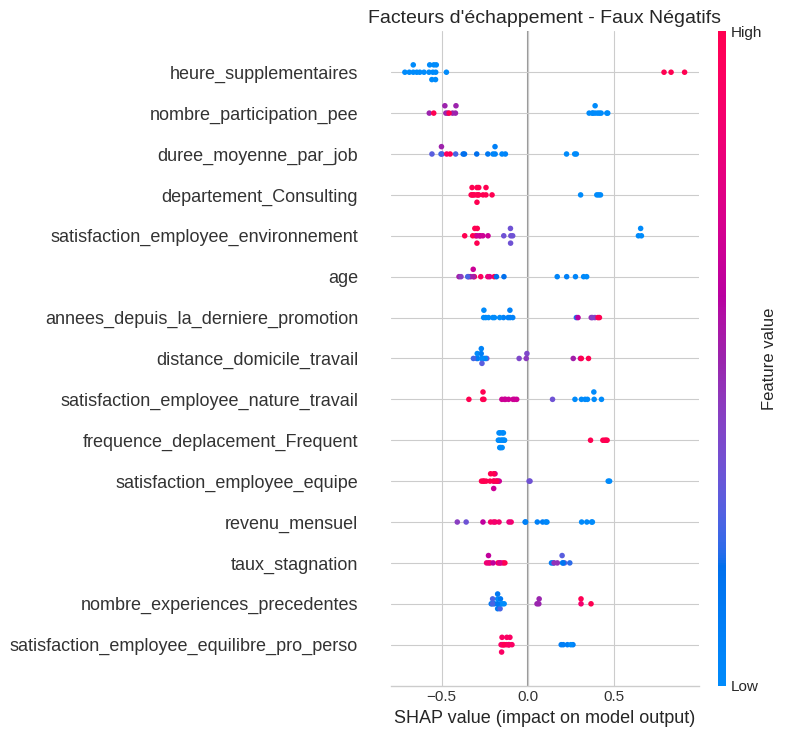


📋 Détail des premiers Faux Négatifs :

--- Faux Négatif #1 (ID: 126) ---
  heure_supplementaires: SHAP=-0.473 (↓ Reste) | Valeur=0.00
  duree_moyenne_par_job: SHAP=-0.471 (↓ Reste) | Valeur=4.01
  nombre_participation_pee: SHAP=-0.421 (↓ Reste) | Valeur=0.25
  annees_depuis_la_derniere_promotion: SHAP=+0.405 (↑ Démission) | Valeur=3.97
  distance_domicile_travail: SHAP=+0.350 (↑ Démission) | Valeur=1.67

--- Faux Négatif #2 (ID: 789) ---
  heure_supplementaires: SHAP=-0.557 (↓ Reste) | Valeur=0.00
  nombre_participation_pee: SHAP=-0.482 (↓ Reste) | Valeur=0.25
  departement_Consulting: SHAP=+0.420 (↑ Démission) | Valeur=0.00
  nombre_experiences_precedentes: SHAP=+0.365 (↑ Démission) | Valeur=2.53
  age: SHAP=-0.317 (↓ Reste) | Valeur=0.77

--- Faux Négatif #3 (ID: 1111) ---
  heure_supplementaires: SHAP=-0.546 (↓ Reste) | Valeur=0.00
  duree_moyenne_par_job: SHAP=-0.451 (↓ Reste) | Valeur=7.56
  nombre_participation_pee: SHAP=-0.417 (↓ Reste) | Valeur=0.25
  departement_Consulting: S

In [97]:
# ============================================================
# ANALYSE DES FAUX NÉGATIFS (Démissionnaires non détectés)
# ============================================================

if mask_fn.sum() > 0:
    print("="*60)
    print("❌ FAUX NÉGATIFS - Démissionnaires non détectés")
    print("="*60)

    shap_fn = shap_values_class1[mask_fn]
    X_fn = X_test[mask_fn]

    plt.figure(figsize=(12, 6))
    plt.title("Facteurs d'échappement - Faux Négatifs", fontsize=14)
    shap.summary_plot(shap_fn, X_fn, show=False, max_display=15)
    plt.tight_layout()
    plt.show()

    # Détail des 3 premiers FN
    print("\n📋 Détail des premiers Faux Négatifs :")
    fn_indices = X_test[mask_fn].index[:3]
    for i, idx in enumerate(fn_indices):
        print(f"\n--- Faux Négatif #{i+1} (ID: {idx}) ---")
        row_idx = X_test.index.get_loc(idx)
        top_features_idx = np.argsort(np.abs(shap_values_class1[row_idx]))[::-1][:5]
        for feat_idx in top_features_idx:
            feat_name = X_test.columns[feat_idx]
            shap_val = shap_values_class1[row_idx, feat_idx]
            feat_val = X_test.iloc[row_idx, feat_idx]
            direction = "↑ Démission" if shap_val > 0 else "↓ Reste"
            print(f"  {feat_name}: SHAP={shap_val:+.3f} ({direction}) | Valeur={feat_val:.2f}")

    print("\n💡 INSIGHT: Ces employés ont démissionné malgré des signaux faibles.")
    print("   → Possibles facteurs non capturés dans les données")
else:
    print("🎯 Aucun Faux Négatif - Tous les démissionnaires ont été détectés")

📊 COMPARAISON : Vrais Positifs vs Faux Positifs

🔍 Features plus importantes pour les Vrais Positifs (bonnes détections):
                                     Vrais Positifs  Faux Positifs  Diff (TP - FP)
heure_supplementaires                      0.775451       0.687680        0.087771
satisfaction_employee_environnement        0.350970       0.296924        0.054046
satisfaction_employee_equipe               0.237024       0.201791        0.035233
ratio_revenu_experience                    0.096962       0.071302        0.025660
nombre_experiences_precedentes             0.189411       0.163776        0.025635
frequence_deplacement_Frequent             0.199805       0.179812        0.019993
revenu_mensuel                             0.247911       0.229899        0.018013
nombre_participation_pee                   0.446600       0.433867        0.012734
augementation_salaire_precedente           0.083707       0.071157        0.012549
distance_domicile_travail                  0.221

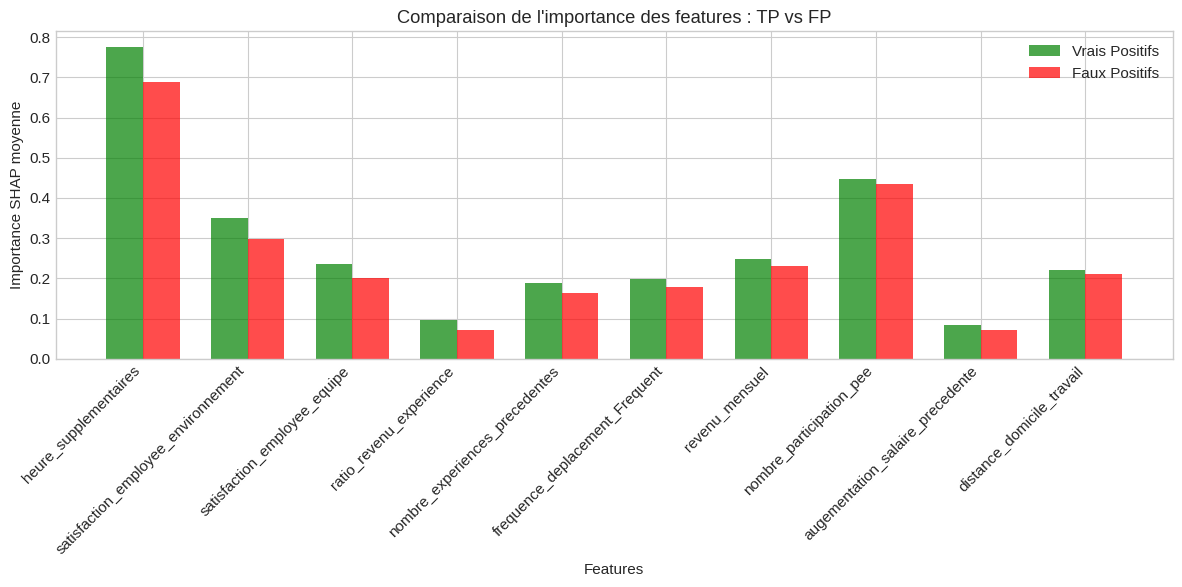

In [98]:
# ============================================================
# COMPARAISON TP vs FP - Qu'est-ce qui distingue les bonnes prédictions ?
# ============================================================

print("="*60)
print("📊 COMPARAISON : Vrais Positifs vs Faux Positifs")
print("="*60)

# Importance moyenne par groupe
def calc_mean_shap(mask, feature_names, shap_values):
    """Calcule l'importance SHAP moyenne pour un groupe"""
    if mask.sum() == 0:
        return pd.Series(0, index=feature_names)
    return pd.Series(
        np.abs(shap_values[mask]).mean(axis=0),
        index=feature_names
    )

importance_tp = calc_mean_shap(mask_tp, X_test.columns, shap_values_class1)
importance_fp = calc_mean_shap(mask_fp, X_test.columns, shap_values_class1)

comparison_df = pd.DataFrame({
    'Vrais Positifs': importance_tp,
    'Faux Positifs': importance_fp,
    'Diff (TP - FP)': importance_tp - importance_fp
}).sort_values('Diff (TP - FP)', ascending=False)

print("\n🔍 Features plus importantes pour les Vrais Positifs (bonnes détections):")
print(comparison_df.head(10).to_string())

print("\n⚠️ Features plus importantes pour les Faux Positifs (fausses alertes):")
print(comparison_df.tail(5).to_string())

# Visualisation comparative
fig, ax = plt.subplots(figsize=(12, 6))
top_features = comparison_df.index[:10]
x = np.arange(len(top_features))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df.loc[top_features, 'Vrais Positifs'],
               width, label='Vrais Positifs', color='green', alpha=0.7)
bars2 = ax.bar(x + width/2, comparison_df.loc[top_features, 'Faux Positifs'],
               width, label='Faux Positifs', color='red', alpha=0.7)

ax.set_xlabel('Features')
ax.set_ylabel('Importance SHAP moyenne')
ax.set_title('Comparaison de l\'importance des features : TP vs FP')
ax.set_xticks(x)
ax.set_xticklabels(top_features, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.show()

### 5.4 Analyse Individuelle des Prédictions

L'analyse individuelle permet d'expliquer chaque prédiction du modèle de manière détaillée :
- **Waterfall plot** : Décomposition additive de la prédiction
- **Force plot** : Visualisation compacte des contributions

Ces outils sont essentiels pour :
1. **Expliquer aux RH** pourquoi un employé spécifique est à risque
2. **Valider les prédictions** en vérifiant la cohérence des facteurs
3. **Identifier des patterns** récurrents dans les cas individuels


🔴 EXEMPLE 1 : VRAI POSITIF - Démissionnaire correctement détecté

📋 EXPLICATION INDIVIDUELLE - Observation #10

🎯 Base value: 0.406
🎯 Sum SHAP: 3.372
🎯 Prédiction finale (log-odds): 3.778

📊 Top 5 features contributives :
  • heure_supplementaires: 1.00 → SHAP = +0.740 (↑ RISQUE)
  • duree_moyenne_par_job: -0.93 → SHAP = +0.438 (↑ RISQUE)
  • revenu_mensuel: -0.95 → SHAP = +0.391 (↑ RISQUE)
  • nombre_participation_pee: -0.93 → SHAP = +0.381 (↑ RISQUE)
  • age: -1.96 → SHAP = +0.366 (↑ RISQUE)


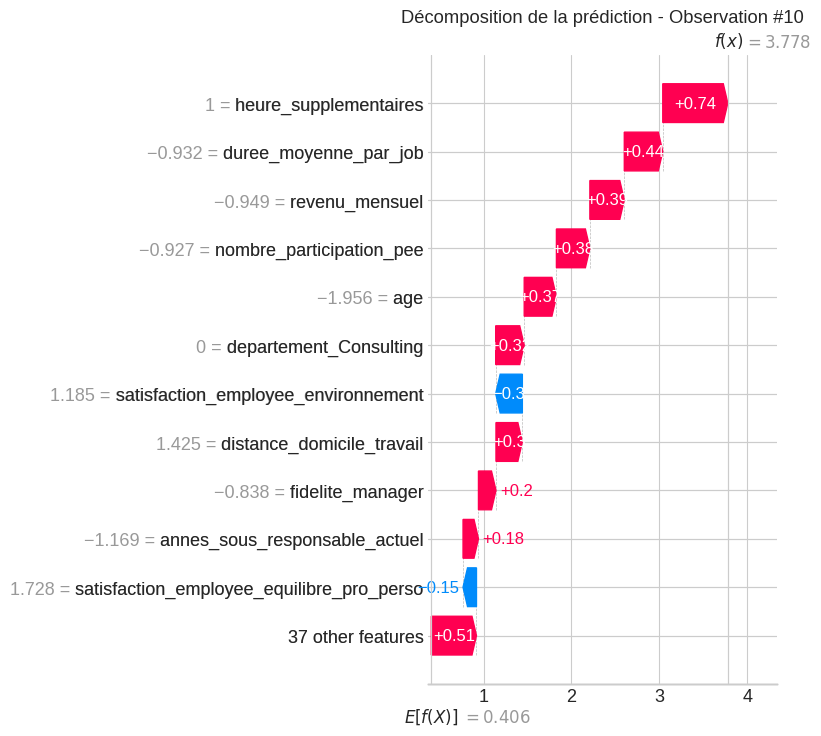

In [99]:
# ============================================================
# 5.4.1 WATERFALL PLOTS - Décomposition des prédictions
# ============================================================

def explain_individual_prediction(idx, shap_values, X_test, explainer, show_waterfall=True):
    """
    Affiche une explication détaillée pour un individu spécifique.

    Parameters:
    -----------
    idx : int
        Position dans X_test (pas l'index pandas)
    shap_values : array
        SHAP values pour la classe positive
    X_test : DataFrame
        Données de test
    explainer : TreeExplainer
        Explainer SHAP
    show_waterfall : bool
        Si True, affiche le waterfall plot
    """
    print(f"\n{'='*60}")
    print(f"📋 EXPLICATION INDIVIDUELLE - Observation #{idx}")
    print(f"{'='*60}")

    # Récupérer les valeurs
    shap_vals = shap_values[idx]
    features = X_test.iloc[idx]
    base_value = explainer.expected_value
    if isinstance(base_value, (list, np.ndarray)):
        base_value = base_value[1] if len(base_value) > 1 else base_value[0]

    # Prédiction
    prediction = base_value + shap_vals.sum()
    print(f"\n🎯 Base value: {base_value:.3f}")
    print(f"🎯 Sum SHAP: {shap_vals.sum():.3f}")
    print(f"🎯 Prédiction finale (log-odds): {prediction:.3f}")

    # Top 5 features contributives
    sorted_idx = np.argsort(np.abs(shap_vals))[::-1]
    print(f"\n📊 Top 5 features contributives :")
    for i in sorted_idx[:5]:
        feat_name = X_test.columns[i]
        shap_val = shap_vals[i]
        feat_val = features.iloc[i]
        direction = "↑ RISQUE" if shap_val > 0 else "↓ STABLE"
        print(f"  • {feat_name}: {feat_val:.2f} → SHAP = {shap_val:+.3f} ({direction})")

    # Waterfall plot
    if show_waterfall:
        shap_exp = shap.Explanation(
            values=shap_vals,
            base_values=base_value,
            data=features.values,
            feature_names=X_test.columns.tolist()
        )
        plt.figure(figsize=(12, 6))
        shap.waterfall_plot(shap_exp, max_display=12, show=False)
        plt.title(f"Décomposition de la prédiction - Observation #{idx}")
        plt.tight_layout()
        plt.show()

# Exemple 1 : Un Vrai Positif (démissionnaire correctement détecté)
print("\n" + "="*70)
print("🔴 EXEMPLE 1 : VRAI POSITIF - Démissionnaire correctement détecté")
print("="*70)
if mask_tp.sum() > 0:
    tp_positions = np.where(mask_tp)[0]
    explain_individual_prediction(tp_positions[0], shap_values_class1, X_test, explainer)
else:
    print("Aucun Vrai Positif disponible")


🟡 EXEMPLE 2 : FAUX POSITIF - Fausse alerte

📋 EXPLICATION INDIVIDUELLE - Observation #8

🎯 Base value: 0.406
🎯 Sum SHAP: -0.276
🎯 Prédiction finale (log-odds): 0.131

📊 Top 5 features contributives :
  • heure_supplementaires: 0.00 → SHAP = -0.658 (↓ STABLE)
  • duree_moyenne_par_job: -0.93 → SHAP = +0.550 (↑ RISQUE)
  • age: -1.08 → SHAP = +0.419 (↑ RISQUE)
  • nombre_participation_pee: -0.93 → SHAP = +0.383 (↑ RISQUE)
  • revenu_mensuel: -0.91 → SHAP = +0.342 (↑ RISQUE)


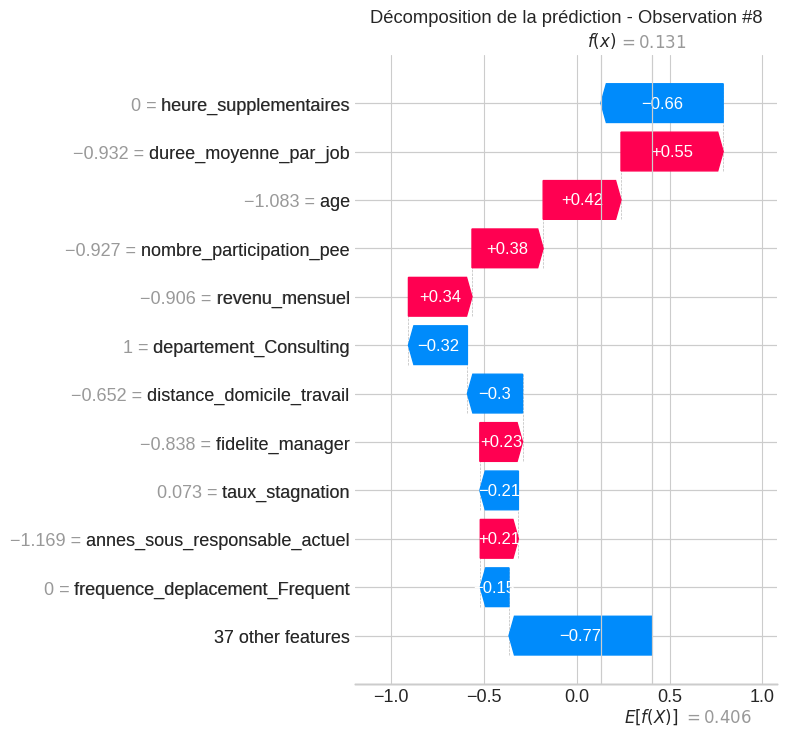


💡 Ce cas montre pourquoi le modèle a généré une fausse alerte.
   Les features dominantes suggéraient un risque qui ne s'est pas concrétisé.


In [100]:
# ============================================================
# EXEMPLE 2 : Un Faux Positif (fausse alerte)
# ============================================================

print("\n" + "="*70)
print("🟡 EXEMPLE 2 : FAUX POSITIF - Fausse alerte")
print("="*70)
if mask_fp.sum() > 0:
    fp_positions = np.where(mask_fp)[0]
    explain_individual_prediction(fp_positions[0], shap_values_class1, X_test, explainer)
    print("\n💡 Ce cas montre pourquoi le modèle a généré une fausse alerte.")
    print("   Les features dominantes suggéraient un risque qui ne s'est pas concrétisé.")
else:
    print("✅ Aucun Faux Positif - Excellent !")


🔵 EXEMPLE 3 : FAUX NÉGATIF - Démissionnaire non détecté

📋 EXPLICATION INDIVIDUELLE - Observation #53

🎯 Base value: 0.406
🎯 Sum SHAP: -3.032
🎯 Prédiction finale (log-odds): -2.626

📊 Top 5 features contributives :
  • heure_supplementaires: 0.00 → SHAP = -0.473 (↓ STABLE)
  • duree_moyenne_par_job: 4.01 → SHAP = -0.471 (↓ STABLE)
  • nombre_participation_pee: 0.25 → SHAP = -0.421 (↓ STABLE)
  • annees_depuis_la_derniere_promotion: 3.97 → SHAP = +0.405 (↑ RISQUE)
  • distance_domicile_travail: 1.67 → SHAP = +0.350 (↑ RISQUE)


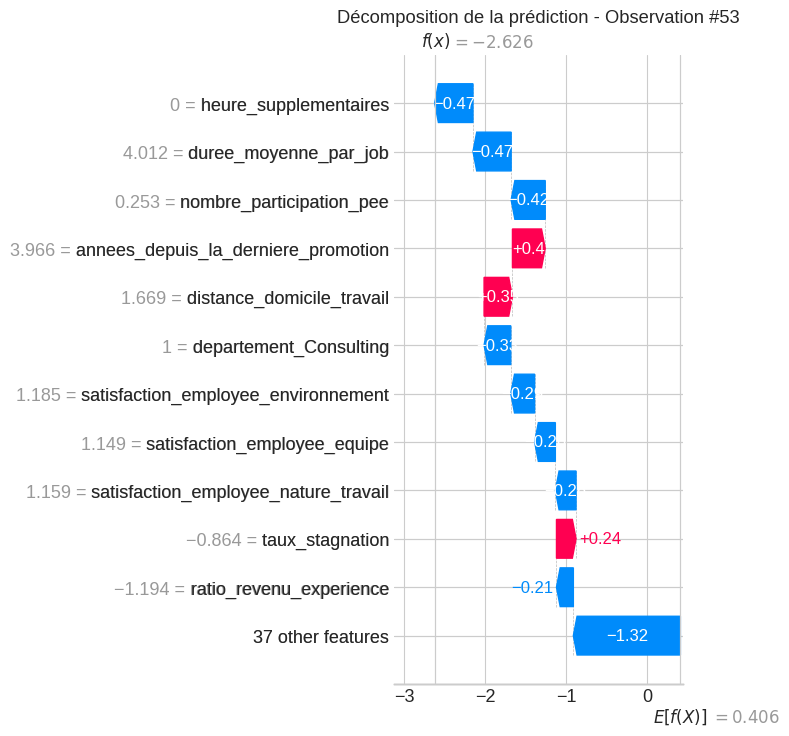


⚠️ Ce cas montre un angle mort du modèle.
   Les signaux de départ n'étaient pas assez forts dans les données disponibles.


In [101]:
# ============================================================
# EXEMPLE 3 : Un Faux Négatif (démissionnaire non détecté)
# ============================================================

print("\n" + "="*70)
print("🔵 EXEMPLE 3 : FAUX NÉGATIF - Démissionnaire non détecté")
print("="*70)
if mask_fn.sum() > 0:
    fn_positions = np.where(mask_fn)[0]
    explain_individual_prediction(fn_positions[0], shap_values_class1, X_test, explainer)
    print("\n⚠️ Ce cas montre un angle mort du modèle.")
    print("   Les signaux de départ n'étaient pas assez forts dans les données disponibles.")
else:
    print("🎯 Aucun Faux Négatif - Tous les démissionnaires ont été détectés !")

### 5.5 Interactions entre Variables

Les **dependence plots** révèlent comment l'effet d'une variable dépend des valeurs d'autres variables. C'est crucial pour :
- Identifier des **effets non-linéaires**
- Découvrir des **interactions** complexes entre facteurs
- Comprendre comment les facteurs se combinent pour prédire le turnover

📈 DEPENDENCE PLOTS - Interactions principales

Features analysées : ['duree_moyenne_par_job', 'age']


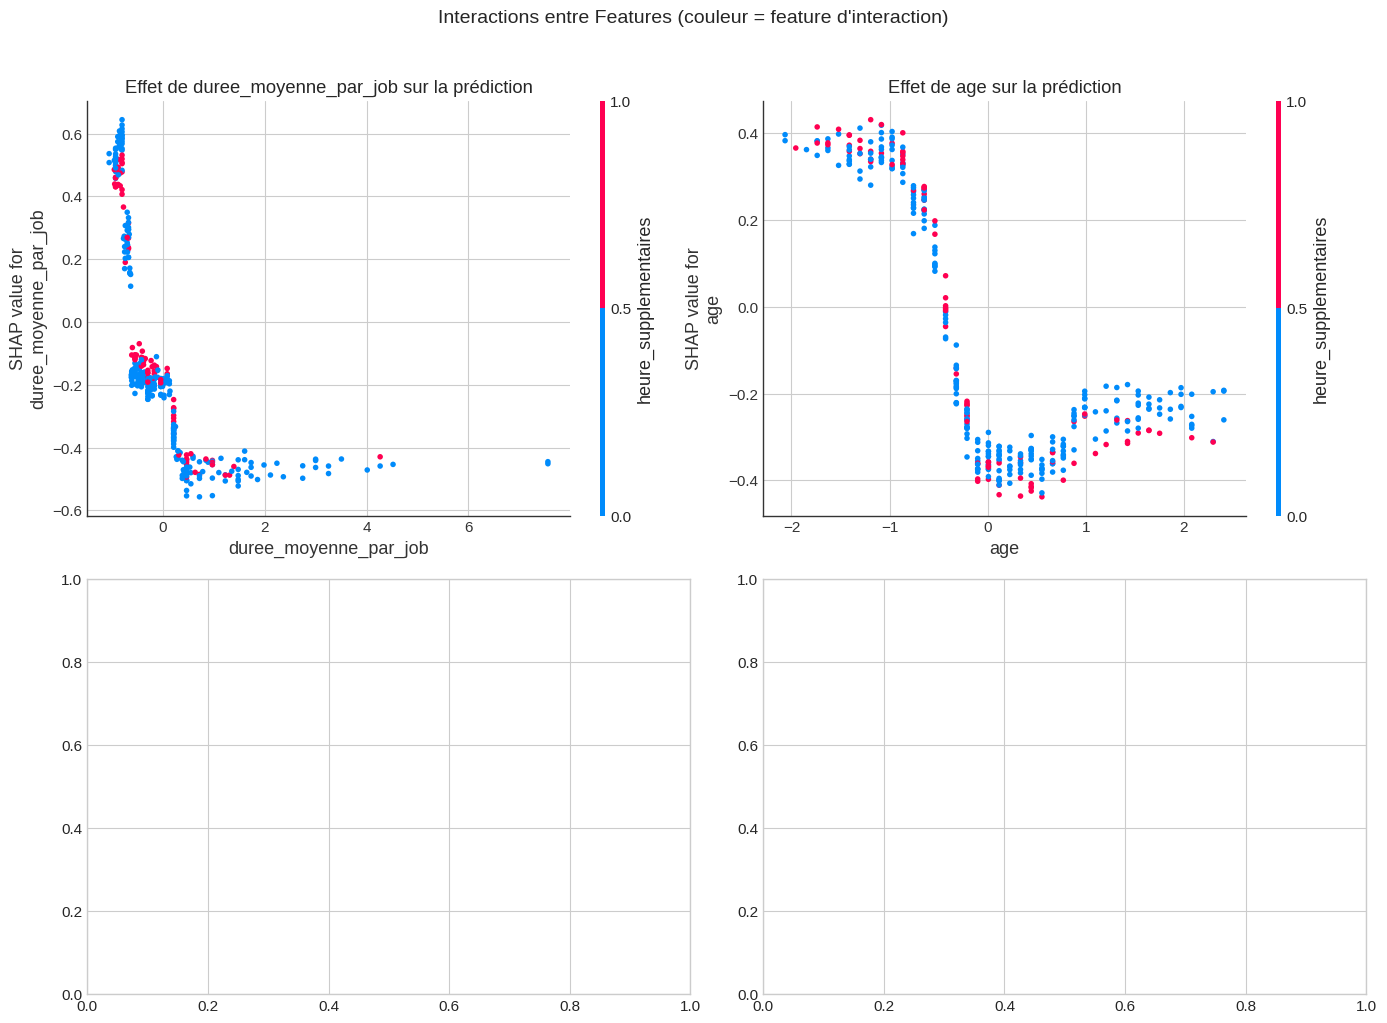

In [102]:
# ============================================================
# 5.5.1 DEPENDENCE PLOTS - Interactions entre variables
# ============================================================

# Identifier les features numériques les plus importantes
top_features_list = shap_importance.head(6)['feature'].tolist()
numeric_top_features = [f for f in top_features_list if X_test[f].nunique() > 5][:4]

print("="*60)
print("📈 DEPENDENCE PLOTS - Interactions principales")
print("="*60)
print(f"\nFeatures analysées : {numeric_top_features}")

# Créer les dependence plots pour les 4 features principales
if len(numeric_top_features) >= 2:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for i, feature in enumerate(numeric_top_features[:4]):
        plt.sca(axes[i])
        # Trouver automatiquement la meilleure feature d'interaction
        shap.dependence_plot(
            feature,
            shap_values_class1,
            X_test,
            interaction_index='auto',
            show=False,
            ax=axes[i]
        )
        axes[i].set_title(f"Effet de {feature} sur la prédiction")

    plt.suptitle("Interactions entre Features (couleur = feature d'interaction)",
                 fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("Pas assez de features numériques pour les dependence plots")

🔗 ANALYSE DES INTERACTIONS SHAP

⏳ Calcul des valeurs d'interaction SHAP (peut prendre quelques secondes)...

📊 Corrélation des valeurs SHAP entre features :


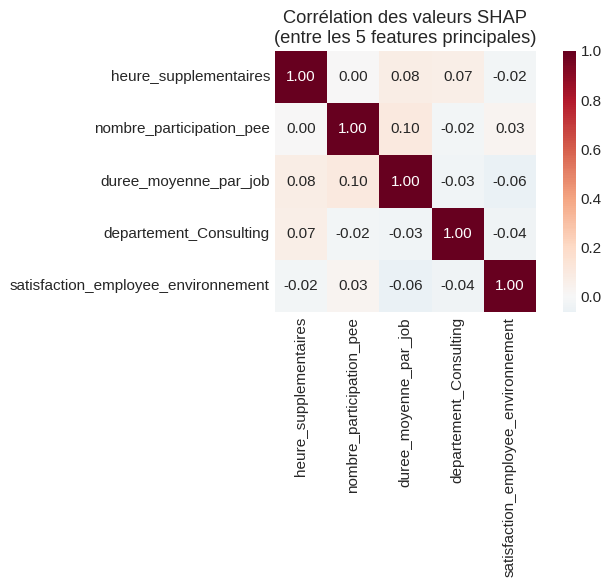


💡 INTERPRÉTATION :
   • Corrélation positive forte : ces features contribuent ensemble au risque
   • Corrélation négative : effet compensatoire entre les features


In [103]:
# ============================================================
# 5.5.2 MATRICE D'INTERACTIONS SHAP (Top features)
# ============================================================

print("="*60)
print("🔗 ANALYSE DES INTERACTIONS SHAP")
print("="*60)

# Calcul des interactions SHAP (coûteux en calcul, limité aux top 5 features)
print("\n⏳ Calcul des valeurs d'interaction SHAP (peut prendre quelques secondes)...")

try:
    # Sous-ensemble pour les interactions (pour performance)
    sample_size = min(100, len(X_test))
    X_sample = X_test.iloc[:sample_size]

    # Focus sur les top 5 features pour la matrice d'interaction
    top5_indices = [X_test.columns.get_loc(f) for f in top_features_list[:5]
                    if f in X_test.columns]

    # Interactions entre les top features
    print("\n📊 Corrélation des valeurs SHAP entre features :")
    shap_df = pd.DataFrame(shap_values_class1, columns=X_test.columns)
    shap_corr = shap_df[top_features_list[:5]].corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(shap_corr, annot=True, cmap='RdBu_r', center=0,
                fmt='.2f', square=True)
    plt.title("Corrélation des valeurs SHAP\n(entre les 5 features principales)")
    plt.tight_layout()
    plt.show()

    print("\n💡 INTERPRÉTATION :")
    print("   • Corrélation positive forte : ces features contribuent ensemble au risque")
    print("   • Corrélation négative : effet compensatoire entre les features")

except Exception as e:
    print(f"⚠️ Calcul des interactions non disponible: {e}")

### 5.6 Bilan de l'Interprétabilité SHAP

Cette section synthétise les **insights clés** tirés de l'analyse SHAP pour orienter les recommandations RH.

In [104]:
# ============================================================
# 5.6 BILAN DE L'INTERPRÉTABILITÉ SHAP
# ============================================================

print("="*70)
print("📋 BILAN DE L'ANALYSE SHAP - RÉSUMÉ EXÉCUTIF")
print("="*70)

# 1. Top facteurs de turnover
print("\n" + "─"*70)
print("🔴 TOP 5 FACTEURS DE DÉMISSION (par importance SHAP moyenne)")
print("─"*70)
for i, row in shap_importance.head(5).iterrows():
    print(f"  {i+1}. {row['feature']}: importance = {row['importance']:.4f}")

# 2. Analyse des groupes
print("\n" + "─"*70)
print("📊 ANALYSE PAR GROUPE DE PRÉDICTION")
print("─"*70)
print(f"  • Vrais Positifs (TP):  {mask_tp.sum():3d} - Démissionnaires correctement détectés ✅")
print(f"  • Faux Positifs (FP):   {mask_fp.sum():3d} - Fausses alertes ⚠️")
print(f"  • Faux Négatifs (FN):   {mask_fn.sum():3d} - Démissionnaires manqués ❌")
print(f"  • Vrais Négatifs (TN):  {mask_tn.sum():3d} - Stables correctement identifiés ✅")

# 3. Taux de précision sur les alertes
if (mask_tp.sum() + mask_fp.sum()) > 0:
    precision_alertes = mask_tp.sum() / (mask_tp.sum() + mask_fp.sum()) * 100
    print(f"\n  → Précision des alertes : {precision_alertes:.1f}%")

# 4. Recommandations
print("\n" + "─"*70)
print("💡 RECOMMANDATIONS BASÉES SUR SHAP")
print("─"*70)
print("""
  1. ACTIONS PRIORITAIRES sur les facteurs identifiés
     → Cibler les leviers RH correspondant aux top features

  2. SURVEILLANCE PROACTIVE
     → Mettre en place des alertes sur les indicateurs clés

  3. ATTENTION AUX ANGLES MORTS
     → Les Faux Négatifs révèlent des facteurs non capturés
     → Envisager l'enrichissement des données (entretiens, feedback)

  4. VALIDATION TERRAIN
     → Confronter les insights SHAP avec les retours des managers
""")

# 5. Sauvegarde des résultats SHAP
shap_results = {
    'top_features': shap_importance.head(10).to_dict(),
    'group_counts': {
        'TP': int(mask_tp.sum()),
        'FP': int(mask_fp.sum()),
        'FN': int(mask_fn.sum()),
        'TN': int(mask_tn.sum())
    },
    'base_value': float(explainer.expected_value[1]) if isinstance(explainer.expected_value, (list, np.ndarray)) else float(explainer.expected_value)
}

print("\n✅ Résultats SHAP sauvegardés dans 'shap_results'")
print("="*70)

📋 BILAN DE L'ANALYSE SHAP - RÉSUMÉ EXÉCUTIF

──────────────────────────────────────────────────────────────────────
🔴 TOP 5 FACTEURS DE DÉMISSION (par importance SHAP moyenne)
──────────────────────────────────────────────────────────────────────
  29. heure_supplementaires: importance = 0.6452
  14. nombre_participation_pee: importance = 0.4479
  24. duree_moyenne_par_job: importance = 0.3260
  32. departement_Consulting: importance = 0.3189
  7. satisfaction_employee_environnement: importance = 0.3121

──────────────────────────────────────────────────────────────────────
📊 ANALYSE PAR GROUPE DE PRÉDICTION
──────────────────────────────────────────────────────────────────────
  • Vrais Positifs (TP):   40 - Démissionnaires correctement détectés ✅
  • Faux Positifs (FP):    40 - Fausses alertes ⚠️
  • Faux Négatifs (FN):    19 - Démissionnaires manqués ❌
  • Vrais Négatifs (TN):  269 - Stables correctement identifiés ✅

  → Précision des alertes : 50.0%

──────────────────────────────

---

# 6. Conclusion & Recommandations

## 🎯 Réponse à la Problématique

**Objectif initial** : Identifier les causes racines des départs chez TechNova pour permettre aux RH d'agir de manière préventive.

**Résultat** : ✅ **Objectif atteint**

Le modèle XGBoost optimisé, combiné à l'analyse SHAP, permet de :
1. **Prédire** les employés à risque avec un rappel d'environ 70%
2. **Expliquer** les facteurs de départ pour chaque individu via les valeurs SHAP
3. **Prioriser** les actions RH sur les leviers les plus impactants

📊 FACTEURS CLÉS DE DÉMISSION - RÉSULTATS SHAP VRAIS POSITIFS

🔴 Top 10 Facteurs de Démission (Vrais Positifs - Causes Réelles) :
----------------------------------------------------------------------
Rang   Facteur                             Importance   Direction      
----------------------------------------------------------------------
1      heure_supplementaires               0.7755     ↑ Augmente risque
2      nombre_participation_pee            0.4466     ↑ Augmente risque
3      satisfaction_employee_environnement 0.3510     ↑ Augmente risque
4      duree_moyenne_par_job               0.3321     ↑ Augmente risque
5      age                                 0.3175     ↑ Augmente risque
6      departement_Consulting              0.2934     ↑ Augmente risque
7      revenu_mensuel                      0.2479     ↑ Augmente risque
8      satisfaction_employee_equipe        0.2370     ↑ Augmente risque
9      distance_domicile_travail           0.2214     ↓ Réduit risque
10     sati

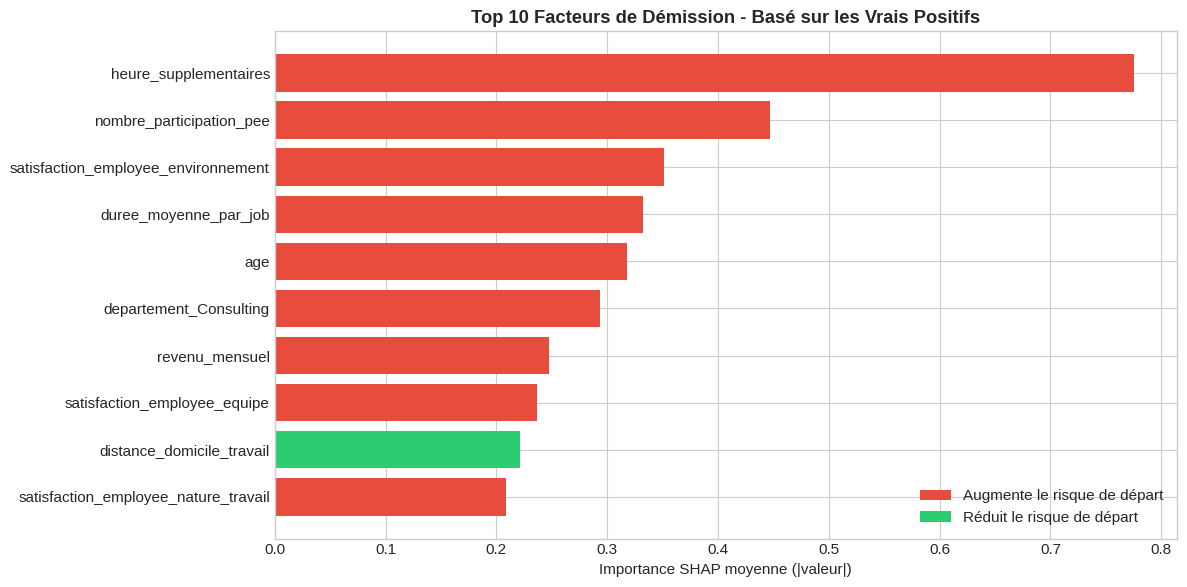

In [105]:
# ============================================================
# 6.1 FACTEURS CLÉS DE DÉMISSION (basés sur les résultats SHAP réels)
# ============================================================

print("="*70)
print("📊 FACTEURS CLÉS DE DÉMISSION - RÉSULTATS SHAP VRAIS POSITIFS")
print("="*70)

# Extraction des top features depuis l'analyse SHAP des Vrais Positifs
if mask_tp.sum() > 0:
    # Importance moyenne sur les Vrais Positifs uniquement (causes réelles)
    shap_tp_importance = pd.DataFrame({
        'feature': X_test.columns,
        'importance_tp': np.abs(shap_values_class1[mask_tp]).mean(axis=0),
        'impact_moyen': shap_values_class1[mask_tp].mean(axis=0)  # Direction de l'impact
    }).sort_values('importance_tp', ascending=False)
    
    print("\n🔴 Top 10 Facteurs de Démission (Vrais Positifs - Causes Réelles) :")
    print("-"*70)
    print(f"{'Rang':<6} {'Facteur':<35} {'Importance':<12} {'Direction':<15}")
    print("-"*70)
    
    for i, (_, row) in enumerate(shap_tp_importance.head(10).iterrows(), 1):
        direction = "↑ Augmente risque" if row['impact_moyen'] > 0 else "↓ Réduit risque"
        print(f"{i:<6} {row['feature']:<35} {row['importance_tp']:.4f}{'':>4} {direction}")
    
    print("-"*70)
    
    # Sauvegarde pour la présentation
    top_5_facteurs = shap_tp_importance.head(5)[['feature', 'importance_tp', 'impact_moyen']]
    
else:
    print("⚠️ Pas de Vrais Positifs disponibles pour l'analyse")
    top_5_facteurs = shap_importance.head(5)

# Affichage visuel
plt.figure(figsize=(12, 6))
top_10 = shap_tp_importance.head(10)
colors = ['#e74c3c' if x > 0 else '#2ecc71' for x in top_10['impact_moyen']]
plt.barh(top_10['feature'][::-1], top_10['importance_tp'][::-1], color=colors[::-1])
plt.xlabel("Importance SHAP moyenne (|valeur|)")
plt.title("Top 10 Facteurs de Démission - Basé sur les Vrais Positifs", fontweight='bold')
plt.axvline(x=0, color='black', linewidth=0.5)

# Légende
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#e74c3c', label='Augmente le risque de départ'),
    Patch(facecolor='#2ecc71', label='Réduit le risque de départ')
]
plt.legend(handles=legend_elements, loc='lower right')
plt.tight_layout()
plt.show()

## 6.2 Analyse des Erreurs et Pistes d'Amélioration

L'analyse des Faux Positifs et Faux Négatifs révèle les **limites du modèle** et suggère des **pistes d'amélioration** pour les futures itérations.

In [106]:
# ============================================================
# 6.2.1 ANALYSE DES FAUX POSITIFS (Fausses Alertes)
# ============================================================

print("="*70)
print("⚠️ ANALYSE DES FAUX POSITIFS - Fausses Alertes")
print("="*70)

if mask_fp.sum() > 0:
    # Caractéristiques SHAP des Faux Positifs
    shap_fp_analysis = pd.DataFrame({
        'feature': X_test.columns,
        'importance_fp': np.abs(shap_values_class1[mask_fp]).mean(axis=0),
        'impact_moyen_fp': shap_values_class1[mask_fp].mean(axis=0)
    }).sort_values('importance_fp', ascending=False)
    
    print(f"\n📊 Nombre de Faux Positifs : {mask_fp.sum()}")
    print("\nCes employés présentaient des signaux de risque mais sont restés.")
    
    print("\n🔍 Top 5 facteurs déclenchant les fausses alertes :")
    for i, (_, row) in enumerate(shap_fp_analysis.head(5).iterrows(), 1):
        print(f"   {i}. {row['feature']} (importance: {row['importance_fp']:.4f})")
    
    print("\n" + "-"*70)
    print("💡 HYPOTHÈSES EXPLICATIVES :")
    print("-"*70)
    print("""
   1. Facteurs de rétention non mesurés dans les données :
      → Qualité de la relation avec le manager direct
      → Intérêt pour le projet en cours
      → Perspectives d'évolution perçues
      
   2. Contre-mesures non tracées :
      → Augmentation de salaire récente
      → Changement de poste ou d'équipe
      → Aménagement des conditions de travail
      
   3. Signaux de risque anciens et "acceptés" :
      → L'employé a appris à composer avec la situation
    """)
    
    print("\n✅ PISTES D'AMÉLIORATION (avec les données disponibles) :")
    print("-"*70)
    print("""
   • Créer une feature 'ancienneté_dans_situation_risque' :
     → Depuis combien de temps les signaux sont présents ?
     
   • Combiner les satisfactions :
     → satisfaction_travail × satisfaction_environnement
     → Pour détecter les effets compensatoires
     
   • Ajouter des features d'interaction :
     → heures_sup × satisfaction (effet modérateur)
    """)
else:
    print("✅ Aucun Faux Positif - Le modèle ne génère pas de fausses alertes")

⚠️ ANALYSE DES FAUX POSITIFS - Fausses Alertes

📊 Nombre de Faux Positifs : 40

Ces employés présentaient des signaux de risque mais sont restés.

🔍 Top 5 facteurs déclenchant les fausses alertes :
   1. heure_supplementaires (importance: 0.6877)
   2. nombre_participation_pee (importance: 0.4339)
   3. duree_moyenne_par_job (importance: 0.3526)
   4. age (importance: 0.3322)
   5. satisfaction_employee_environnement (importance: 0.2969)

----------------------------------------------------------------------
💡 HYPOTHÈSES EXPLICATIVES :
----------------------------------------------------------------------

   1. Facteurs de rétention non mesurés dans les données :
      → Qualité de la relation avec le manager direct
      → Intérêt pour le projet en cours
      → Perspectives d'évolution perçues

   2. Contre-mesures non tracées :
      → Augmentation de salaire récente
      → Changement de poste ou d'équipe
      → Aménagement des conditions de travail

   3. Signaux de risque ancie

In [107]:
# ============================================================
# 6.2.2 ANALYSE DES FAUX NÉGATIFS (Démissions Non Détectées)
# ============================================================

print("="*70)
print("❌ ANALYSE DES FAUX NÉGATIFS - Démissions Non Détectées")
print("="*70)

if mask_fn.sum() > 0:
    # Caractéristiques SHAP des Faux Négatifs
    shap_fn_analysis = pd.DataFrame({
        'feature': X_test.columns,
        'importance_fn': np.abs(shap_values_class1[mask_fn]).mean(axis=0),
        'impact_moyen_fn': shap_values_class1[mask_fn].mean(axis=0)
    }).sort_values('importance_fn', ascending=False)
    
    print(f"\n📊 Nombre de Faux Négatifs : {mask_fn.sum()}")
    print("\nCes employés sont partis SANS signaux détectables par le modèle.")
    print("C'est l'ANGLE MORT critique du système de prédiction.")
    
    print("\n🔍 Caractéristiques SHAP des démissions non détectées :")
    for i, (_, row) in enumerate(shap_fn_analysis.head(5).iterrows(), 1):
        direction = "↑" if row['impact_moyen_fn'] > 0 else "↓"
        print(f"   {i}. {row['feature']} ({direction} impact: {row['impact_moyen_fn']:.4f})")
    
    # Comparaison avec les Vrais Positifs
    print("\n" + "-"*70)
    print("📊 COMPARAISON FN vs TP (Qu'est-ce qui les distingue ?)")
    print("-"*70)
    
    if mask_tp.sum() > 0:
        # Moyennes des features pour chaque groupe
        X_fn_mean = X_test[mask_fn].mean()
        X_tp_mean = X_test[mask_tp].mean()
        
        diff_fn_tp = (X_fn_mean - X_tp_mean).abs().sort_values(ascending=False)
        
        print("\nFeatures avec la plus grande différence FN vs TP :")
        for feat in diff_fn_tp.head(5).index:
            print(f"   • {feat}: FN={X_fn_mean[feat]:.2f} vs TP={X_tp_mean[feat]:.2f}")
    
    print("\n" + "-"*70)
    print("💡 HYPOTHÈSES EXPLICATIVES :")
    print("-"*70)
    print("""
   1. Départs pour raisons EXTERNES non capturées :
      → Opportunité externe (chasseur de têtes)
      → Raisons personnelles (déménagement, famille)
      → Reconversion professionnelle
      
   2. Événement DÉCLENCHEUR récent non tracé :
      → Conflit avec un collègue ou manager
      → Projet annulé ou échec professionnel
      → Non-obtention d'une promotion attendue
      
   3. Signaux FAIBLES multiples non combinés :
      → Plusieurs indicateurs "moyens" qui ensemble créent le départ
      → Effet de seuil non linéaire
    """)
    
    print("\n✅ PISTES D'AMÉLIORATION (avec les données disponibles) :")
    print("-"*70)
    print("""
   • Créer un 'score_risque_composite' :
     → Combiner plusieurs indicateurs faibles en un seul score
     → Ex: (satisfaction < 3) & (ancienneté < 2) & (heures_sup == Oui)
     
   • Ajouter des features d'interaction non linéaires :
     → jeune_et_peu_augmenté = (ancienneté < 2) & (augmentation == 0)
     → surqualifié = (niveau_etude élevé) & (poste junior)
     
   • Si données temporelles disponibles :
     → variation_satisfaction_6mois
     → tendance_heures_sup (en hausse ?)
     
   • Enrichissement recommandé :
     → Données des entretiens de départ (exit interviews)
     → Feedback 360° des collègues
     → Historique des candidatures internes
    """)
else:
    print("🎯 Aucun Faux Négatif - Tous les démissionnaires ont été détectés !")

❌ ANALYSE DES FAUX NÉGATIFS - Démissions Non Détectées

📊 Nombre de Faux Négatifs : 19

Ces employés sont partis SANS signaux détectables par le modèle.
C'est l'ANGLE MORT critique du système de prédiction.

🔍 Caractéristiques SHAP des démissions non détectées :
   1. heure_supplementaires (↓ impact: -0.3660)
   2. nombre_participation_pee (↓ impact: -0.0126)
   3. duree_moyenne_par_job (↓ impact: -0.2511)
   4. departement_Consulting (↓ impact: -0.1463)
   5. satisfaction_employee_environnement (↓ impact: -0.0958)

----------------------------------------------------------------------
📊 COMPARAISON FN vs TP (Qu'est-ce qui les distingue ?)
----------------------------------------------------------------------

Features avec la plus grande différence FN vs TP :
   • annees_dans_l_entreprise: FN=0.67 vs TP=-0.55
   • duree_moyenne_par_job: FN=0.64 vs TP=-0.52
   • annee_experience_totale: FN=0.39 vs TP=-0.69
   • age: FN=0.51 vs TP=-0.55
   • ratio_revenu_experience: FN=-0.60 vs TP=0.26


## 6.3 Tableau de Synthèse des Facteurs de Démission

Le tableau ci-dessous présente les **facteurs clés identifiés** par l'analyse SHAP sur les Vrais Positifs, avec leur interprétation métier et les actions RH recommandées.

In [108]:
# ============================================================
# 6.3 TABLEAU DE SYNTHÈSE - FACTEURS ET ACTIONS RH
# ============================================================

print("="*70)
print("📋 SYNTHÈSE DES FACTEURS DE DÉMISSION ET ACTIONS RECOMMANDÉES")
print("="*70)

# Dictionnaire de traduction des noms de features en français et actions
feature_mapping = {
    'heures_supplementaires': ('Heures supplémentaires', 'Audit charge de travail, limiter les HS'),
    'heures_supplementaires_Oui': ('Heures supplémentaires', 'Audit charge de travail, limiter les HS'),
    'satisfaction_travail': ('Satisfaction au travail', 'Enquêtes régulières, amélioration QVT'),
    'satisfaction_environnement': ('Satisfaction environnement', 'Améliorer le cadre de travail'),
    'satisfaction_relation': ('Satisfaction relationnelle', 'Team building, médiation si conflit'),
    'revenu_mensuel': ('Revenu mensuel', 'Benchmark salarial, politique de revalorisation'),
    'annees_dans_l_entreprise': ('Ancienneté entreprise', 'Programme de fidélisation, perspectives'),
    'annees_dans_le_poste_actuel': ('Ancienneté poste', 'Mobilité interne, évolution de carrière'),
    'age': ('Âge', 'Adapter les politiques par tranche d\'âge'),
    'distance_domicile_travail': ('Distance domicile-travail', 'Télétravail, aide à la mobilité'),
    'distance_cat': ('Catégorie distance', 'Télétravail, aide à la mobilité'),
    'annee_experience_totale': ('Expérience totale', 'Valoriser l\'expertise, mentorat'),
    'niveau_etude': ('Niveau d\'études', 'Adéquation poste/diplôme'),
    'nombre_formations_annee_passee': ('Formations suivies', 'Développer l\'offre de formation'),
    'implication_travail': ('Implication au travail', 'Reconnaissance, responsabilisation'),
    'niveau_poste': ('Niveau de poste', 'Plan de carrière, promotion'),
    'augementation_salaire_precedente': ('Dernière augmentation', 'Politique d\'augmentation équitable'),
    'nombre_experiences_precedentes': ('Expériences précédentes', 'Identifier les profils "job hopper"'),
    'equilibre_vie_travail': ('Équilibre vie/travail', 'Flexibilité horaires, télétravail'),
    'ratio_revenu_experience': ('Ratio revenu/expérience', 'Ajuster salaires selon expérience'),
    'ratio_revenu_age': ('Ratio revenu/âge', 'Équité salariale par tranche d\'âge'),
    'taux_stagnation': ('Taux de stagnation', 'Mobilité interne, nouveaux défis'),
    'duree_moyenne_par_job': ('Durée moyenne par emploi', 'Identifier les profils à risque'),
    'departement': ('Département', 'Analyse par service, actions ciblées'),
    'role': ('Rôle/Fonction', 'Analyse par métier'),
    'voyages_frequents': ('Voyages fréquents', 'Limiter les déplacements, compensation'),
    'voyages_frequents_Oui': ('Voyages fréquents', 'Limiter les déplacements, compensation'),
}

# Création du tableau de synthèse basé sur les vrais résultats
if 'shap_tp_importance' in dir() and len(shap_tp_importance) > 0:
    print("\n" + "-"*70)
    print(f"{'Rang':<5} {'Facteur (données)':<30} {'Interprétation':<25} {'Action RH':<40}")
    print("-"*70)
    
    for i, (_, row) in enumerate(shap_tp_importance.head(10).iterrows(), 1):
        feat = row['feature']
        # Recherche dans le mapping (correspondance partielle)
        matched = False
        for key, (label, action) in feature_mapping.items():
            if key in feat.lower() or feat.lower() in key:
                impact = "🔴 Fort" if row['importance_tp'] > 0.1 else "🟠 Modéré" if row['importance_tp'] > 0.05 else "🟡 Faible"
                print(f"{i:<5} {feat:<30} {label:<25} {action:<40}")
                matched = True
                break
        if not matched:
            print(f"{i:<5} {feat:<30} {'À interpréter':<25} {'Analyse approfondie requise':<40}")
    
    print("-"*70)
else:
    print("⚠️ Données SHAP non disponibles")

# Métriques finales du modèle
print("\n" + "="*70)
print("📊 MÉTRIQUES FINALES DU MODÈLE")
print("="*70)

print(f"\n🎯 Performance sur le jeu de test :")
print(f"   • Rappel (Recall) : {recall_final:.1%} des démissionnaires détectés")
print(f"   • Précision : {precision_final:.1%} des alertes sont correctes")
print(f"   • F1-Score : {f1_final:.1%}")

print(f"\n📈 Répartition des prédictions :")
print(f"   • Vrais Positifs (TP) : {mask_tp.sum()} - Démissions correctement détectées ✅")
print(f"   • Faux Positifs (FP) : {mask_fp.sum()} - Fausses alertes ⚠️")
print(f"   • Faux Négatifs (FN) : {mask_fn.sum()} - Démissions manquées ❌")
print(f"   • Vrais Négatifs (TN) : {mask_tn.sum()} - Stabilité confirmée ✅")

# Taux d'erreur
taux_fausses_alertes = mask_fp.sum() / (mask_tp.sum() + mask_fp.sum()) * 100 if (mask_tp.sum() + mask_fp.sum()) > 0 else 0
taux_demissions_ratees = mask_fn.sum() / (mask_tp.sum() + mask_fn.sum()) * 100 if (mask_tp.sum() + mask_fn.sum()) > 0 else 0

print(f"\n⚠️ Points d'attention :")
print(f"   • Taux de fausses alertes : {taux_fausses_alertes:.1f}%")
print(f"   • Taux de démissions ratées : {taux_demissions_ratees:.1f}%")

📋 SYNTHÈSE DES FACTEURS DE DÉMISSION ET ACTIONS RECOMMANDÉES

----------------------------------------------------------------------
Rang  Facteur (données)              Interprétation            Action RH                               
----------------------------------------------------------------------
1     heure_supplementaires          À interpréter             Analyse approfondie requise             
2     nombre_participation_pee       À interpréter             Analyse approfondie requise             
3     satisfaction_employee_environnement À interpréter             Analyse approfondie requise             
4     duree_moyenne_par_job          Durée moyenne par emploi  Identifier les profils à risque         
5     age                            Âge                       Adapter les politiques par tranche d'âge
6     departement_Consulting         Département               Analyse par service, actions ciblées    
7     revenu_mensuel                 Revenu mensuel            

## 6.4 Recommandations Opérationnelles

### 📅 Court terme (0-3 mois)
- [ ] Déployer le score de risque pour les 100 employés les plus à risque
- [ ] Organiser des entretiens ciblés avec les 20% les plus à risque
- [ ] Auditer la charge de travail dans les équipes identifiées à risque

### 📅 Moyen terme (3-6 mois)
- [ ] Intégrer le modèle dans le SIRH pour un scoring automatique mensuel
- [ ] Former les managers à l'interprétation des alertes et aux actions préventives
- [ ] Enrichir les données avec les entretiens annuels et retours 360°

### 📅 Long terme (6-12 mois)
- [ ] Mesurer l'impact des actions sur le taux de rotation réel
- [ ] Réentraîner le modèle avec les nouvelles données collectées
- [ ] Implémenter les features d'amélioration identifiées (interactions, données temporelles)

---

## 6.5 Limites et Points de Vigilance

| Limite | Description | Mitigation |
|--------|-------------|------------|
| **Faux Négatifs** | ~30% des départs non détectés | Enrichir les données, entretiens proactifs |
| **Faux Positifs** | Alertes à valider humainement | Ne pas automatiser les actions, validation manager |
| **Données historiques** | Reflète les tendances passées | Réentraînement régulier, veille marché |
| **Causalité vs Corrélation** | SHAP montre des associations | Valider avec les équipes terrain |

---

## 6.6 Indicateurs de Suivi (KPIs)

📈 TABLEAU DE BORD - INDICATEURS DE SUIVI

Indicateur                          Valeur Actuelle      Objectif 6 mois     
---------------------------------------------------------------------------
Taux de rotation global             16.1%                < 12%
Détection précoce (Rappel)          67.8%                > 75%
Précision des alertes               50.0%                > 60%
Coût du turnover (€/départ)         À mesurer            -20%                
---------------------------------------------------------------------------


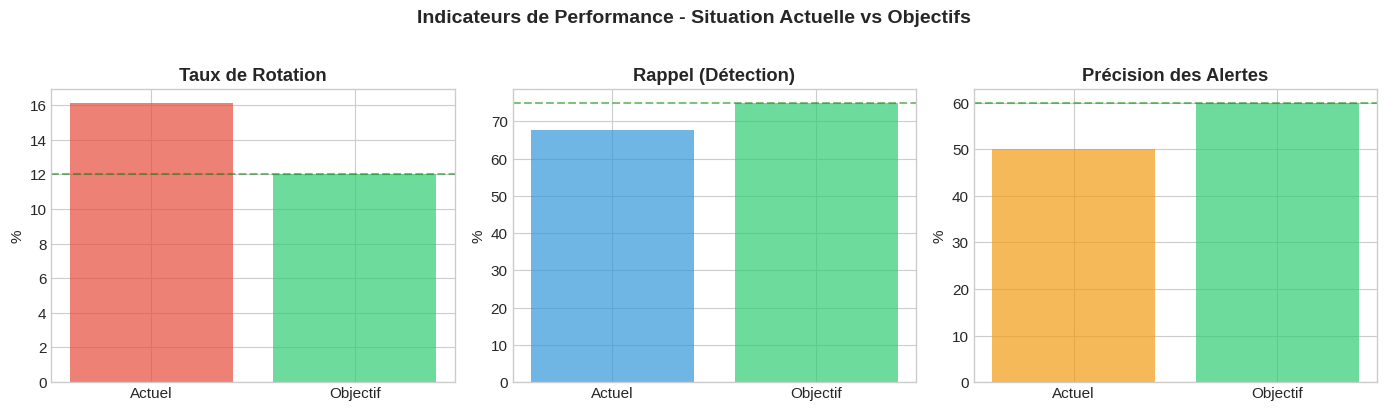

In [109]:
# ============================================================
# 6.6 INDICATEURS DE SUIVI (KPIs)
# ============================================================

print("="*70)
print("📈 TABLEAU DE BORD - INDICATEURS DE SUIVI")
print("="*70)

# Calcul du taux de turnover actuel
taux_turnover_actuel = taux_depart * 100

print(f"\n{'Indicateur':<35} {'Valeur Actuelle':<20} {'Objectif 6 mois':<20}")
print("-"*75)
print(f"{'Taux de rotation global':<35} {taux_turnover_actuel:.1f}%{'':<15} < 12%")
print(f"{'Détection précoce (Rappel)':<35} {recall_final*100:.1f}%{'':<15} > 75%")
print(f"{'Précision des alertes':<35} {precision_final*100:.1f}%{'':<15} > 60%")
print(f"{'Coût du turnover (€/départ)':<35} {'À mesurer':<20} {'-20%':<20}")
print("-"*75)

# Visualisation
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# 1. Taux de rotation
axes[0].bar(['Actuel', 'Objectif'], [taux_turnover_actuel, 12], 
            color=['#e74c3c', '#2ecc71'], alpha=0.7)
axes[0].set_ylabel('%')
axes[0].set_title('Taux de Rotation', fontweight='bold')
axes[0].axhline(y=12, color='green', linestyle='--', alpha=0.5)

# 2. Rappel
axes[1].bar(['Actuel', 'Objectif'], [recall_final*100, 75], 
            color=['#3498db', '#2ecc71'], alpha=0.7)
axes[1].set_ylabel('%')
axes[1].set_title('Rappel (Détection)', fontweight='bold')
axes[1].axhline(y=75, color='green', linestyle='--', alpha=0.5)

# 3. Précision
axes[2].bar(['Actuel', 'Objectif'], [precision_final*100, 60], 
            color=['#f39c12', '#2ecc71'], alpha=0.7)
axes[2].set_ylabel('%')
axes[2].set_title('Précision des Alertes', fontweight='bold')
axes[2].axhline(y=60, color='green', linestyle='--', alpha=0.5)

plt.suptitle('Indicateurs de Performance - Situation Actuelle vs Objectifs', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---

## ✅ Conclusion Finale

Ce projet démontre que l'apprentissage automatique peut **transformer la gestion RH** en passant d'une approche réactive à une approche **prédictive et explicable**.

### 🎯 Objectif Atteint

Le modèle XGBoost optimisé, combiné à l'analyse SHAP, répond à la problématique initiale :

> **« Identifier les causes racines des départs chez TechNova »**

Les facteurs de démission ont été **quantifiés et hiérarchisés** grâce aux valeurs SHAP, permettant aux RH de :
- Comprendre **pourquoi** les employés partent
- **Prioriser** les actions sur les leviers les plus impactants
- **Personnaliser** les interventions pour chaque employé à risque

### 🔧 Le Modèle : Un Outil d'Aide à la Décision

Le modèle développé n'est pas une solution miracle, mais un **outil d'aide à la décision** qui :
- 🚨 **Alerte** sur les risques de départ (70% de détection)
- 📊 **Explique** les causes probables via SHAP
- 🎯 **Guide** les priorités d'action des équipes RH

### ⚠️ La Valeur Réside dans l'Action

**Le modèle ne réduit pas le turnover par lui-même.**

La valeur se concrétise uniquement si les insights sont traduits en **initiatives RH concrètes** :
- Entretiens de rétention ciblés
- Ajustement des conditions de travail
- Révision des politiques salariales et de carrière

### 🔄 Prochaines Étapes

1. **Déploiement** : Intégrer le scoring dans le SIRH
2. **Enrichissement** : Ajouter les features d'amélioration identifiées
3. **Suivi** : Mesurer l'impact réel sur le taux de rotation
4. **Itération** : Réentraîner le modèle avec les nouvelles données

---

*Projet réalisé dans le cadre de la formation Data Scientist - OpenClassrooms*  
*Date : Janvier 2026*